# make_grid:
## Make high res grid, choose either GEBCO_v2023 or bedmachine v3
### Version id:
### bedmachine v3
### completely redoing interpolating and smoothing to reduce halo-ing/fringing high rx1 in cavities

In [1]:

run ='vand'
vers='1km_v1'
plotting = False

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import xarray as xr
import scipy.io as sio
from scipy.interpolate import griddata
import datetime
import cmocean
# import h5py
import bathy_smoother
# import pyresample


import socket
comp_name = socket.gethostname()
if comp_name=='SEES-3PV4VV3':
    print('running locally')
else:
    os.chdir('/g/data/jk72/deg581/vanderford-setup/notebooks')
    
#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.smoothing_Laplacian_rx0 import smoothing_Laplacian_rx0
from ext.tools.uvp_masks import uvp_masks



out_path = os.path.join(data_dir,'proc',run+'_'+vers+'_grd.nc')


# define coordinate transforms
## convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# load my functions for calculating rx0,rx1 and adjusting the grid
# from ext.tools.calc_z import calc_z as calc_z_old
from functions import GridStiffness
from functions.GridAdjustments import adjustWCT,adjustMask,smoothRegion,minWCTRegion

# Set model vertical coordinate settings

N=25
Vtransform=2
Vstretching=4
theta_s=4
theta_b=1
Tcline=350
hc=Tcline # if Vtransform==2, hc=Tcline


running locally



In [2]:
mr = 1
grid_xLims= (2390,2500) #km
grid_yLims= (-940,-720) #km
#establish the grid with grid point distances of mr/2 in km
#we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
#we need an extra line of u and v points at first to calculate all dx and dy on rho points
x,y = np.meshgrid(np.arange(grid_xLims[0],grid_xLims[1]+mr/2,mr/2),np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2))
x_rho = x[1::2,1::2]
y_rho = y[1::2,1::2]

lat,lon = inverse_polar_stereo(x_rho,y_rho,0,0,-71.0)

print('x_rho size is: ',x_rho.shape)

x_rho size is:  (220, 110)


In [3]:
GeoGrid=False
if GeoGrid:
    print('making grid points with geographic coordinates')
    res = 1/200
    xc = (107,110.9)
    yc = (-67,-64.5)
    
    Lats = np.arange(yc[0],yc[1]+res,res)
    Lons = np.arange(xc[0],xc[1]+res,res)
    
    lat,lon = np.meshgrid(Lats,Lons)
    
    lonr_to_x,latr_to_y = ll_to_ps.transform(lat,lon)
    
    x_rho = lonr_to_x/1000
    y_rho = latr_to_y/1000
    

quick plot of extents


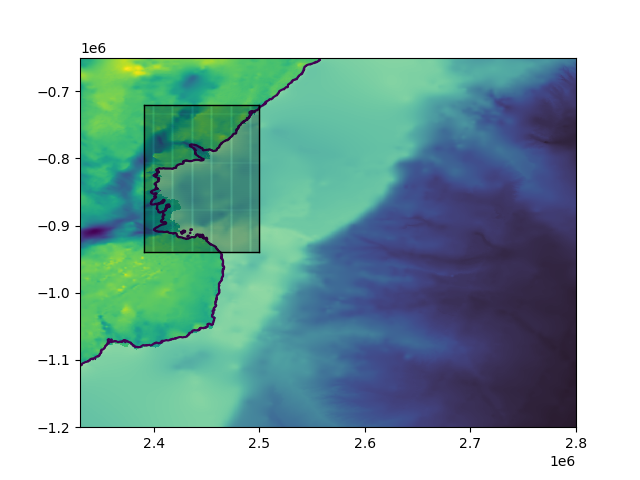

In [4]:
#load BM3 geometry
bedmachine_v3_path = os.path.join(data_dir,'raw','BedMachineAntarctica-v3','BedMachineAntarctica-v3.nc')

bm3_raw = xr.load_dataset(bedmachine_v3_path)

#subset bedmachine dataset
bm3=bm3_raw.sel(x=slice(2.33e6,2.8e6)).sel(y=slice(-.65e6,-1.2e6)) # note reversed y coord

# make XX and YY coordinates
X,Y = np.meshgrid(bm3.x,bm3.y)
bm3 = bm3.assign_coords({"X": (("y", "x"), X), "Y": (("y", "x"), Y)})

bm3_lat,bm3_lon = ps_to_ll.transform(bm3.X,bm3.Y)
bm3 = bm3.assign_coords({"lon": (("y", "x"), bm3_lon), "lat": (("y", "x"), bm3_lat)})

# make 'draft' abd 'bathy' variables
bm3["draft"]=-(bm3.thickness-bm3.surface) #draft is negative
bm3["bathy"]=-bm3.bed # bathy is postive



geom = bm3
# make masks
geom['mask_full']=bm3.mask
geom["mask_ice"]=np.isfinite(geom.mask_full.where(geom.mask_full==3,np.NaN))
geom["mask_ocean"]=np.isfinite(geom.mask_full.where((geom.mask_full==0)|(geom.mask_full==3),np.NaN))

%matplotlib widget
print('quick plot of extents')
plt.close('all')
masked_ice = geom.draft.where(geom.draft!=0,np.NaN).copy()
plt.pcolormesh(geom.X,geom.Y,geom.bathy,cmap='cmo.deep')
plt.pcolormesh(geom.X,geom.Y,masked_ice)

plt.contour(geom.X,geom.Y,geom.draft+geom.bathy,levels=0)
plt.plot(x_rho*1000,y_rho*1000,'ko',markersize=1,alpha=0.02,mec=None)
plt.plot(x_rho[0,:]*1000,y_rho[0,:]*1000,'k',linewidth=1)
plt.plot(x_rho[-1,:]*1000,y_rho[-1,:]*1000,'k',linewidth=1)
plt.plot(x_rho[:,0]*1000,y_rho[:,0]*1000,'k',linewidth=1)
plt.plot(x_rho[:,-1]*1000,y_rho[:,-1]*1000,'k',linewidth=1)
plt.show()

In [5]:
bm3_raw

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 b''
    mask       (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    firn       (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    surface    (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    thickness  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bed        (y, x) float32 -5.916e+03 -5.92e+03 ... -3.664e+03 -3.664e+03
    errbed     (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    source     (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    dataid     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    geoid      (y, x) int16 -1 -1 -1 -1 -1 -1 -1 ... -19 -19 -19 -19 -19 -19 -19
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

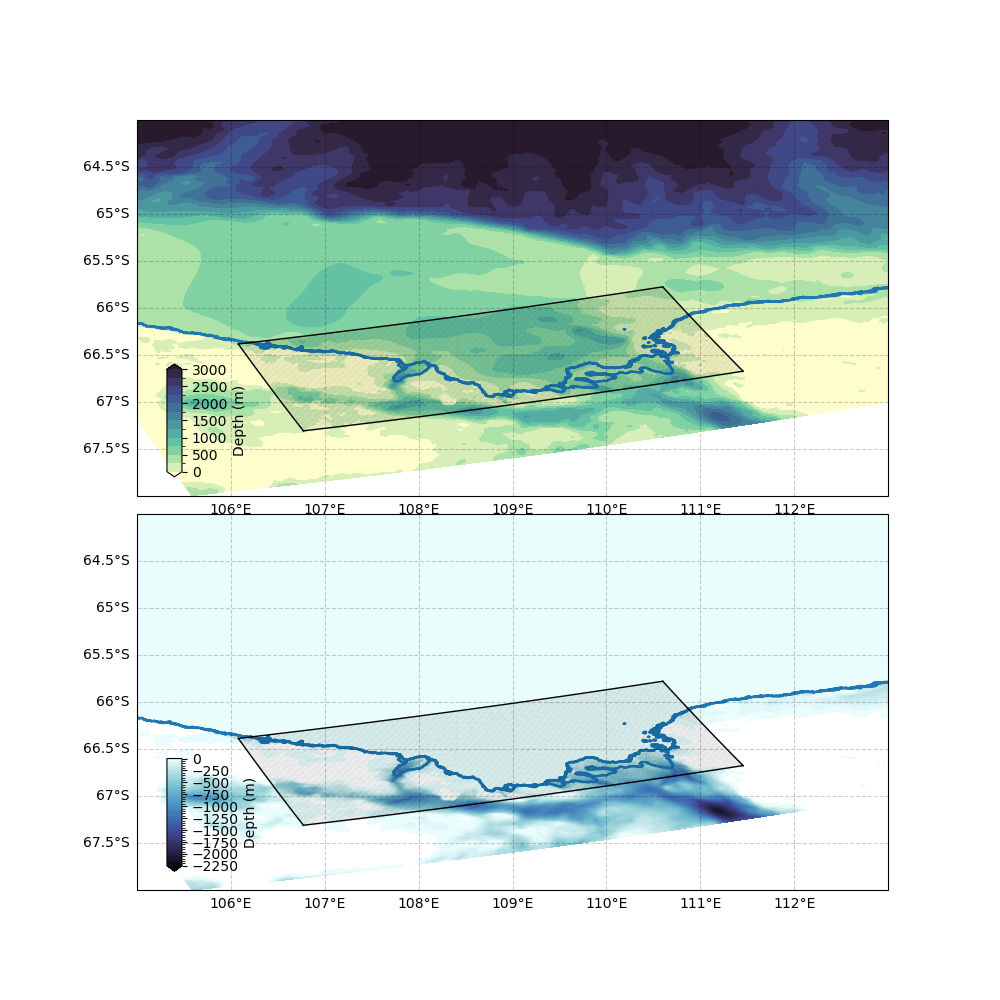

In [6]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.set_extent([105, 113, -68, -64])

    
#add data
im = (geom['bathy']).plot.contourf(x='lon',y='lat',cmap='cmo.deep',levels=np.array([*np.arange(00,3250,250)]),add_colorbar=False)
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')
ax.plot(lon,lat,'ko',markersize=1,alpha=0.02,mec=None)
ax.plot(lon[0,:],lat[0,:],'k',linewidth=1)
ax.plot(lon[-1,:],lat[-1,:],'k',linewidth=1)
ax.plot(lon[:,0],lat[:,0],'k',linewidth=1)
ax.plot(lon[:,-1],lat[:,-1],'k',linewidth=1)

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()


#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.set_extent([105, 113, -68, -64])

#add data
im = (geom.draft).plot.contourf(x='lon',y='lat',cmap='cmo.ice',levels=np.array([*np.arange(-2250,50,50)]),add_colorbar=False,extend='min')
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')
ax.plot(lon,lat,'ko',markersize=1,alpha=0.02,mec=None)
ax.plot(lon[0,:],lat[0,:],'k',linewidth=1)
ax.plot(lon[-1,:],lat[-1,:],'k',linewidth=1)
ax.plot(lon[:,0],lat[:,0],'k',linewidth=1)
ax.plot(lon[:,-1],lat[:,-1],'k',linewidth=1)

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()



In [7]:
%matplotlib inline


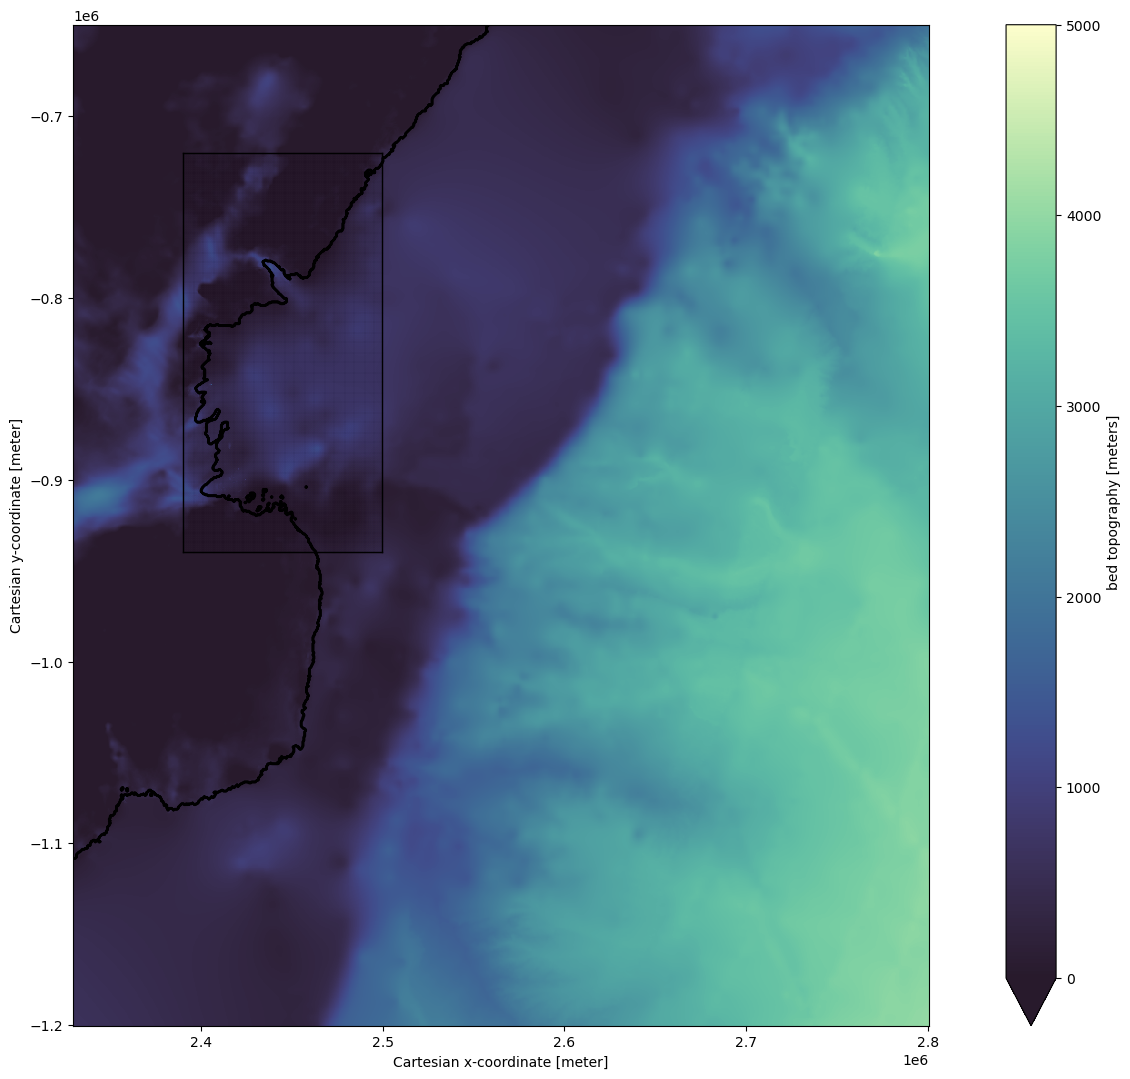

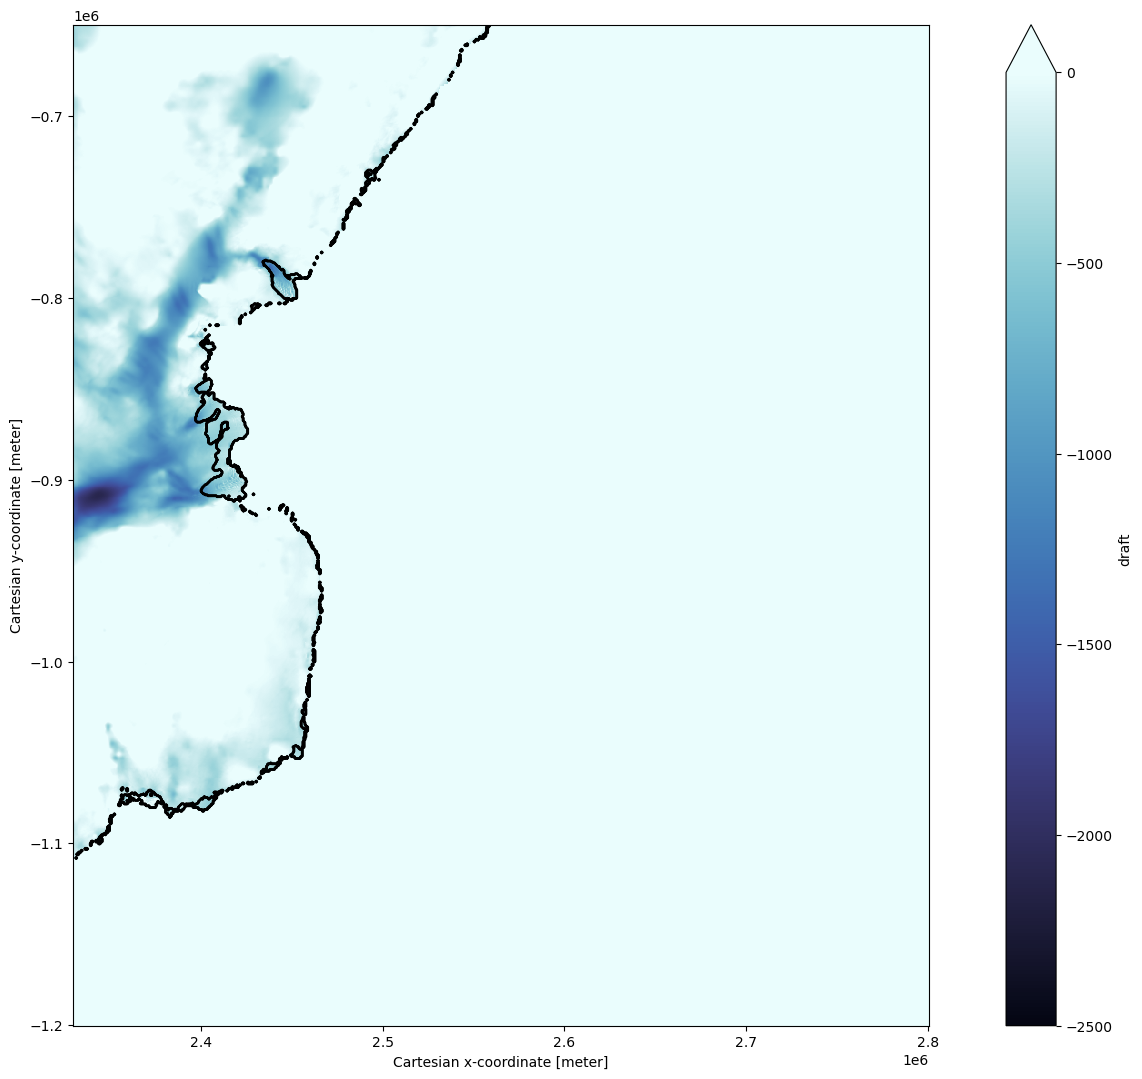

In [8]:
# plot of chosen subset
plt.close('all')
fig,ax=plt.subplots(figsize=(20,13))
geom.bathy.plot(vmin=000,vmax=5000,cmap='cmo.deep_r')
geom.mask_ocean.plot.contour(colors='k')
plt.plot(x_rho*1000,y_rho*1000,'ko',markersize=1,alpha=0.02,mec=None)
plt.plot(x_rho[0,:]*1000,y_rho[0,:]*1000,'k',linewidth=1)
plt.plot(x_rho[-1,:]*1000,y_rho[-1,:]*1000,'k',linewidth=1)
plt.plot(x_rho[:,0]*1000,y_rho[:,0]*1000,'k',linewidth=1)
plt.plot(x_rho[:,-1]*1000,y_rho[:,-1]*1000,'k',linewidth=1)
ax.set_aspect('equal','box')

plt.show()
fig,ax=plt.subplots(figsize=(20,13))
geom.draft.plot(vmin=-2500,vmax=0,cmap='cmo.ice')
geom.mask_ice.plot.contour(colors='k')
ax.set_aspect('equal','box')

In [9]:
#load south polar stereographic projection to convert from grid point distance in m to lat/lon and back

#get lat/lon coordinates at all grid points by shifting the grid to the lower left corner of the map
lat,lon = inverse_polar_stereo(x,y,0,0,-71.0)

#calculate curvilinear coordinate distances at rho points
dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])


#calculate curvilinear coordinate metrices
pm = 1.0/dx
pn = 1.0/dy
 
dndx = np.empty_like(pm)
dmde = np.empty_like(pn)

dndx[:,1:-1] = 0.5*(pn[:,2:] - pn[:,:-2])
dmde[1:-1,:] = 0.5*(pm[2:,:] - pm[:-2,:])

dndx[:,0]  = 2*dndx[:,1]  - dndx[:,2]
dndx[:,-1] = 2*dndx[:,-2] - dndx[:,-3]
dmde[0,:]  = 2*dmde[1,:]  - dmde[2,:]
dmde[-1,:] = 2*dmde[-2,:] - dmde[-3,:]

#subset lat and lon at rho, psi, u and v points
lon_rho = lon[1::2,1::2]
lat_rho = lat[1::2,1::2]

lon_psi = lon[2:-1:2,2:-1:2]
lat_psi = lat[2:-1:2,2:-1:2]

lon_u = lon[1::2,2:-1:2]
lat_u = lat[1::2,2:-1:2]

lon_v = lon[2:-1:2,1::2]
lat_v = lat[2:-1:2,1::2]

No such comm: 38266720c1be4b90a65e146919751f15


No such comm: eb3a3b98b7604b0a962aae60fa22afbe


No such comm: 6b6c21e0c5e843a78c6ac164b5b7205a


No such comm: aa1d7989478a4b2e95442d5060d9e0bf


No such comm: 3b8bccf07a7e46cf986701d04fe58d1f


No such comm: 6ab3bdadb497427693f958a29a45a7c4


No such comm: 19f2ea7d12674bb5a5eee14334892aa3


No such comm: 6e75de9007a14d0a8576c8ec08b06d78


No such comm: 984aa43e812545dc98287266da44bab4


No such comm: 5fd7e3a5da8e43d6bdb813e6ee051b3d


No such comm: 05b8bfcd469f4af1937c13b864d6ac42


In [10]:
# convert the final rho,psi,u,v points to x,y grid

x_rho,y_rho = ll_to_ps.transform(lat_rho,lon_rho)
x_psi,y_psi = ll_to_ps.transform(lat_psi,lon_psi)
x_u,y_u = ll_to_ps.transform(lat_u,lon_u)
x_v,y_v = ll_to_ps.transform(lat_v,lon_v)




In [11]:
lat_s = geom.lat.values.flatten()
lon_s = geom.lon.values.flatten()

In [12]:
# interpolate from the geometry grid to the new roms grid

from scipy.interpolate import griddata

def grid_data(data):
    return griddata((lon_s,lat_s),data,(lon_rho,lat_rho),'nearest')

roms_tmp = {}
for key in ['bathy','draft','mask_ice','mask_ocean']:
    roms_tmp[key] = grid_data(geom[key].values.flatten())
    print('interpolated',key)

interpolated bathy
interpolated draft
interpolated mask_ice
interpolated mask_ocean


In [13]:
if plotting:
    plt.close()
    for key,data in roms_tmp.items():
        fig,ax = plt.subplots(figsize=(15,10))
        if key=='draft':
            plot = ax.pcolormesh(data)        
        else:
            plot = ax.pcolormesh(data)
        ax.set_title(key)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('equal')
        plt.show()

  
Minimum r-value =  nan
Maximum r-value =  nan
Mean    r-value =  nan
Median  r-value =  nan


/home/woden/Documents/vanderford-setup/src/functions/GridStiffness.py:80: RuntimeWarning: divide by zero encountered in divide
  hx = abs(h[:,1:] - h[:,:-1]) / (h[:,1:] + h[:,:-1])
/home/woden/Documents/vanderford-setup/src/functions/GridStiffness.py:81: RuntimeWarning: divide by zero encountered in divide
  hy = abs(h[1:,:] - h[:-1,:]) / (h[1:,:] + h[:-1,:])
/home/woden/Documents/vanderford-setup/src/functions/GridStiffness.py:83: RuntimeWarning: invalid value encountered in multiply
  hx = hx * umask
/home/woden/Documents/vanderford-setup/src/functions/GridStiffness.py:84: RuntimeWarning: invalid value encountered in multiply
  hy = hy * vmask


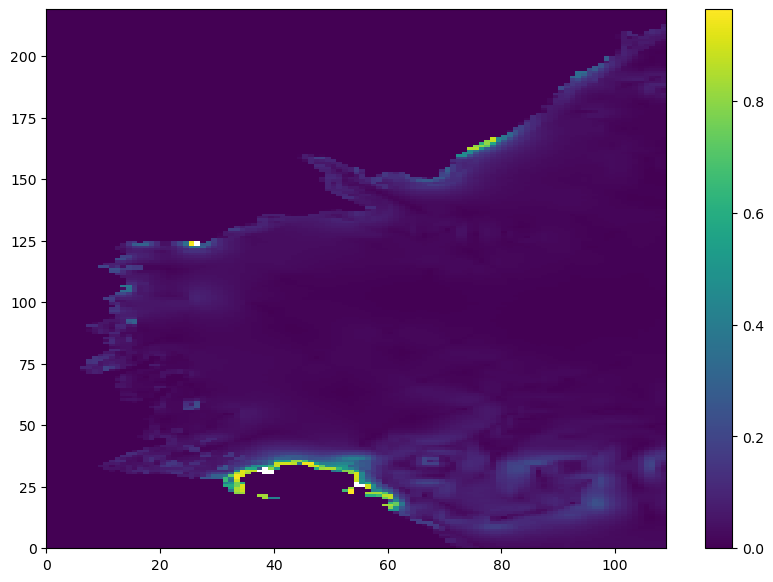

/home/woden/Documents/vanderford-setup/src/functions/GridStiffness.py:141: RuntimeWarning: divide by zero encountered in divide
  zx[k,:] = abs((z_w[k,1:,:] - z_w[k,:-1,:] + z_w[k-1,1:,:] - z_w[k-1,:-1,:]) /
/home/woden/Documents/vanderford-setup/src/functions/GridStiffness.py:143: RuntimeWarning: divide by zero encountered in divide
  zy[k,:] = abs((z_w[k,:,1:] - z_w[k,:,:-1] + z_w[k-1,:,1:] - z_w[k-1,:,:-1]) /
/home/woden/Documents/vanderford-setup/src/functions/GridStiffness.py:145: RuntimeWarning: invalid value encountered in multiply
  zx[k,:] = zx[k,:] * umask
/home/woden/Documents/vanderford-setup/src/functions/GridStiffness.py:146: RuntimeWarning: invalid value encountered in multiply
  zy[k,:] = zy[k,:] * vmask


  
Minimum r-value =  nan
Maximum r-value =  nan
Mean    r-value =  nan
Median  r-value =  nan


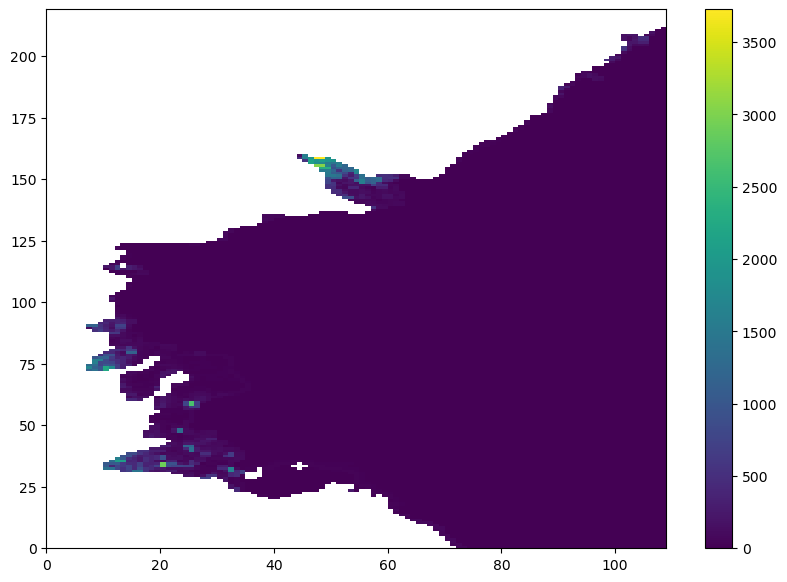

In [14]:

z_rho_pre,z_w_pre,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bathy'],roms_tmp['draft'])


fig = plt.figure(figsize=(10,7))
grd_rx0_pre=GridStiffness.rx0(roms_tmp['bathy'],roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx0_pre)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,7))
grd_rx1_pre=GridStiffness.rx1(z_w_pre,roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx1_pre)
plt.colorbar()
plt.show()

In [15]:
# # make amery mask for calculating cavity volume
# rough_mask = np.zeros(roms_tmp['draft'].shape)
# rough_mask[300:440,0:368]=1

# mask_amery = (roms_tmp['draft']<0) & (roms_tmp['mask_ocean']==1) & (rough_mask==1)

# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh(mask_amery)
# plt.colorbar()

# print('initial cavity volume')
# print(np.sum(mask_amery*(roms_tmp['draft']+roms_tmp['bathy'])*dx*dy),'m3')
# print(np.sum(mask_amery*(roms_tmp['draft']+roms_tmp['bathy'])*dx*dy)/1e12,'x10^12 m3')

# initial_volume = np.sum(mask_amery*(roms_tmp['draft']+roms_tmp['bathy'])*dx*dy)


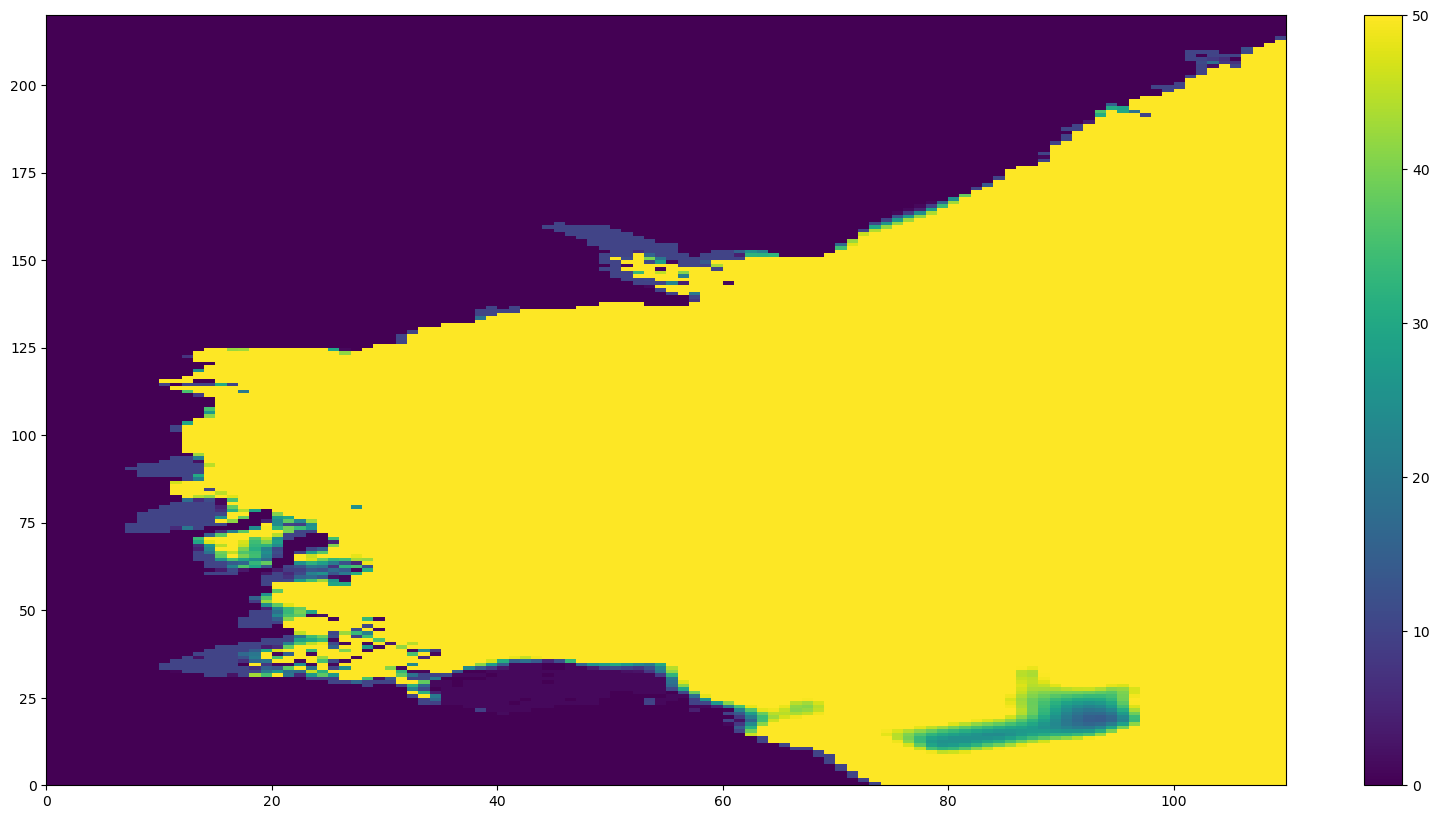

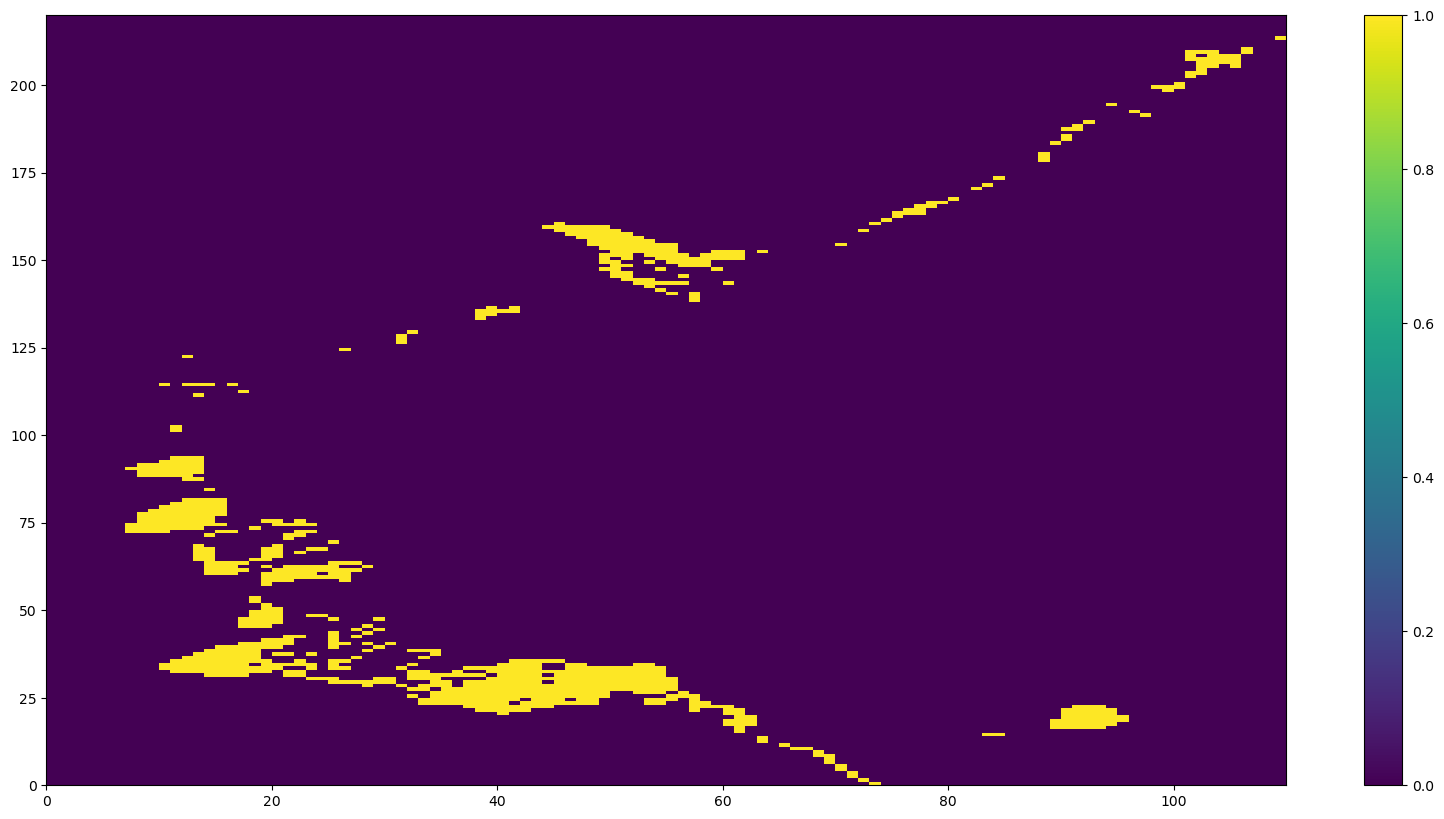

In [16]:
# First need to check for any badly masked points - before any smoothing happens
Thresh = 25

%matplotlib inline
fig = plt.figure(figsize=(20,10))
thin_WCT = (roms_tmp['bathy']+roms_tmp['draft'])*roms_tmp['mask_ocean']
plt.pcolormesh(thin_WCT,vmin=0,vmax=50)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
thin_WCT_mask = (thin_WCT<Thresh) & (roms_tmp['mask_ocean']==1)
plt.pcolormesh(thin_WCT_mask)
plt.colorbar()


In [17]:
# plt.figure()
# plot_where=120
# plt.plot(-roms_tmp['bathy'][:,plot_where],'.-')
# plt.plot(roms_tmp['draft'][:,plot_where],'.-')
# plt.plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# plt.axis((345,375,-2600,0))
# print(roms_tmp['bathy'][352,plot_where])
# print(roms_tmp['draft'][352,plot_where])
# print(roms_tmp['mask_ocean'][352,plot_where])
# print((roms_tmp['bathy'][352,plot_where]+roms_tmp['draft'][352,plot_where])*roms_tmp['mask_ocean'][352,plot_where])

# plt.figure()
# plot_where=270
# plt.plot(-roms_tmp['bathy'][:,plot_where],'.-')
# plt.plot(roms_tmp['draft'][:,plot_where],'.-')
# plt.plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# plt.axis((345,420,-1500,0))

# print(roms_tmp['bathy'][410,plot_where])
# print(roms_tmp['draft'][410,plot_where])
# print(roms_tmp['mask_ocean'][410,plot_where])
# print((roms_tmp['bathy'][410,plot_where]+roms_tmp['draft'][410,plot_where])*roms_tmp['mask_ocean'][410,plot_where])

# plt.show()
# plt.figure()
# plt.pcolormesh((roms_tmp['bathy']-roms_tmp['draft'])*roms_tmp['mask_ocean'])
# plt.axvline(plot_where,color='C1')
# plot_where=270
# plt.axvline(plot_where,color='C2')

# plt.axis((200,400,300,500))
# plt.colorbar()

# plt.show()
# plt.figure()
# plot_where=270
# plt.pcolormesh((roms_tmp['bathy']+roms_tmp['draft'])*roms_tmp['mask_ocean'],vmin=0,vmax=100)
# plt.axis((200,400,300,500))
# plt.colorbar()
# # plt.pcolormesh()

In [18]:
# do checks
print('min/max zice is',roms_tmp['draft'].min(),'/',roms_tmp['draft'].max())
print('min/max h is',roms_tmp['bathy'].min(),'/',roms_tmp['bathy'].max())
print('min/max wct is',(roms_tmp['draft']+roms_tmp['bathy']).min(),'/',(roms_tmp['draft']+roms_tmp['bathy']).max())

min/max zice is -1429.7563 / 384.28928
min/max h is -384.28928 / 1439.7563
min/max wct is 0.0 / 1293.0347


First round of smoothing
make masks
remove mountains etc
deepen ice until it is at least min_depth
begin smoothing
smooth wct
smooth ice
Old Max Roughness value is:  nan


/home/woden/Documents/pyroms/bathy_smoother/bathy_smoother/bathy_tools.py:38: RuntimeWarning: invalid value encountered in scalar divide
  delta = abs((dep1 - dep2) / (dep1 + dep2))


DeltaBathymetry =  1134.2220458984375
New Max Roughness value is:  nan
smooth bed
Old Max Roughness value is:  0.9642283916473389


DeltaBathymetry =  175.1298828125
New Max Roughness value is:  0.15145334601402283
  
Minimum r-value =  0.0
Maximum r-value =  0.15145334601402283
Mean    r-value =  0.01656894647898982
Median  r-value =  0.006615193095058203


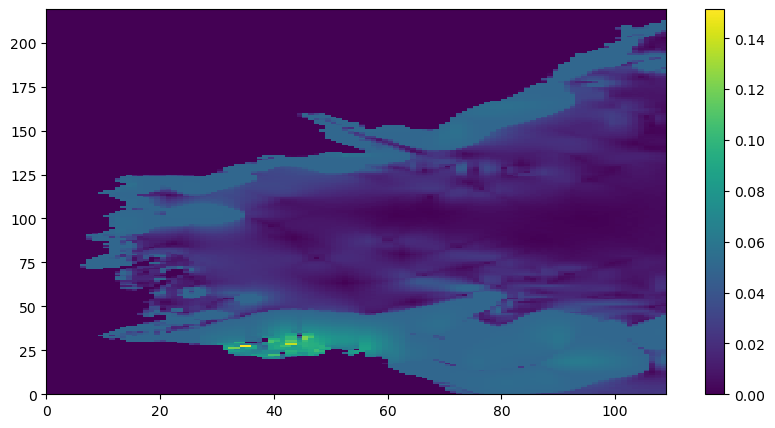

  
Minimum r-value =  0.0
Maximum r-value =  646049.1916273766
Mean    r-value =  80.76251941891168
Median  r-value =  0.1635315113710821


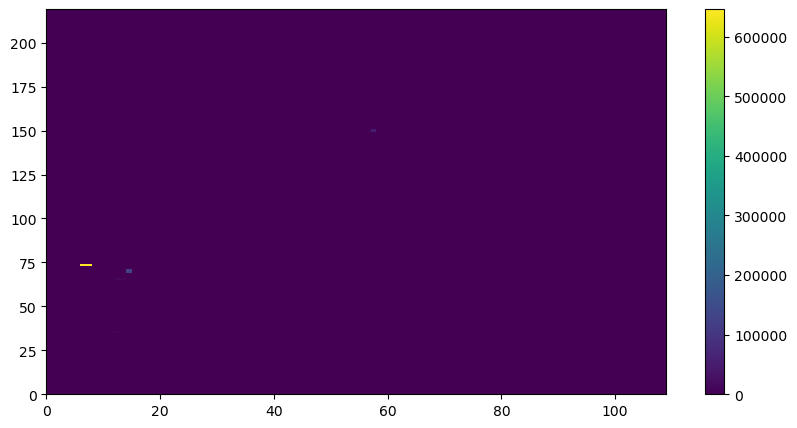

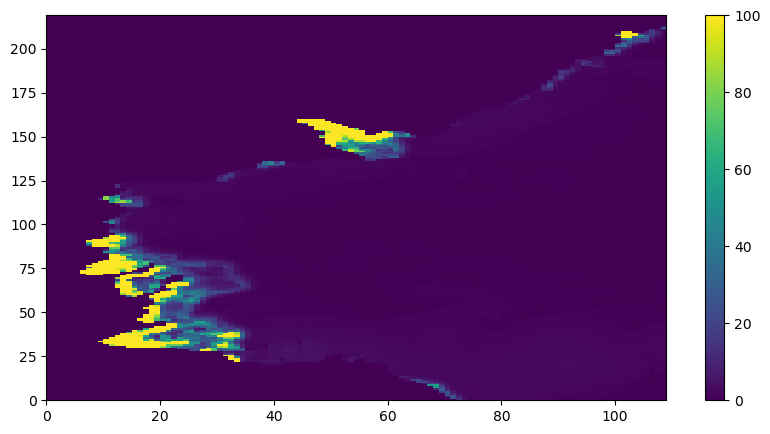

In [19]:
print('First round of smoothing')

print('make masks')
bed = roms_tmp['bathy'].copy()
bed_raw = roms_tmp['bathy'].copy()
ice = roms_tmp['draft'].copy()
mask = roms_tmp['mask_ocean'].copy()
maskNaN = mask.copy() # make a nan mask.
maskNaN = np.where(maskNaN==0,np.NaN,maskNaN)
mask_ice = ice.copy()
mask_ice[mask_ice<0]=1
mask_ice[mask_ice>=0]=0

# first, make any bedrock above MSL, and any ice above MSL to 0. (remove mountains)
print('remove mountains etc')
min_depth0=0.3
ice[ice>0] = 0
bed[bed < min_depth0] = min_depth0 #note that bathy cannot >=0

# for any locations where there is wct<min_depth0; deepen the ice a bit until it is at least min_depth0
print('deepen ice until it is at least min_depth')
wct = bed + ice
ice[wct<min_depth0] = -bed[wct<min_depth0] + min_depth0  
wct = bed + ice

# plt.figure()
# plot_where=120
# plt.plot(-roms_tmp['bathy'][:,plot_where],color='C0',marker='.')
# plt.plot(roms_tmp['draft'][:,plot_where],color='C1',marker='.')
# # plt.plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# plt.plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# plt.plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # plt.plot(-1000*mask[:,plot_where],'.-')
# plt.axis((345,375,-2600,0))

# make ice mask
mask_ice = ice.copy()
mask_ice[mask_ice>=0]=0
mask_ice[mask_ice<0]=1
mask_ice = mask_ice*mask
mask_openocean = (mask_ice==0)*mask

# smooth the wct and bed, then deepen the ice to correct for smoothed wct/bed.
print('begin smoothing')
# GOOD VALUE --> rx0in = 0.06
max_iter = 50

Area = 1/(pm*pn)

print('smooth wct')
# wct = bed+ice
# rx0in = 0.1
# wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,wct,rx0in,Area,max_iter)
print('smooth ice')
rx0in = 0.09
max_iter = 1
ice, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,ice,rx0in,Area,max_iter)

# print('now push bed down by new smoothed wct')
# bed = wct - ice

print('smooth bed')
rx0in = 0.05
max_iter = 50
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,bed,rx0in,Area,max_iter)
# bed = smoothing_Laplacian_rx0(mask,bed,rx0in)


# print('now, smooth bed')
# bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,bed,rx0in,Area,max_iter)

# ice_o = ice.copy()
# ice = (wct - bed)*mask_ice # need to correct, as this will have introduced 'false' ice in the open ocean.
# this occurs when the bathymetry was smoothered lower in the open ocean, and thus the wct-bed makes a negative zice.

# plt.figure(figsize=(10,7.5))
# plt.pcolormesh((ice-roms_tmp['draft'])*mask,vmin=-100,vmax=100,cmap='RdBu')
# plt.title('ice-roms_tmp[''draft'']')
# plt.colorbar()
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh(mask_ice)
# plt.title('mask_ice')
# plt.colorbar()
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh(ice*mask,vmin=-150)
# plt.title('ice*mask')
# plt.colorbar()
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh((bed+ice)*mask,vmax=150)
# plt.title('wct*mask')
# plt.colorbar()
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh(bed*mask,vmax=150)
# plt.title('bed*mask')
# plt.colorbar()


# plt.figure()
# plot_where=120
# plt.plot(-roms_tmp['bathy'][:,plot_where],color='C0',marker='.')
# plt.plot(roms_tmp['draft'][:,plot_where],color='C1',marker='.')
# plt.plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# plt.plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# plt.axis((345,375,-2600,0))



z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)

fig = plt.figure(figsize=(10,5))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
plt.pcolormesh(grd_rx1_mid,vmin=0,vmax=100)
plt.colorbar()
plt.show()


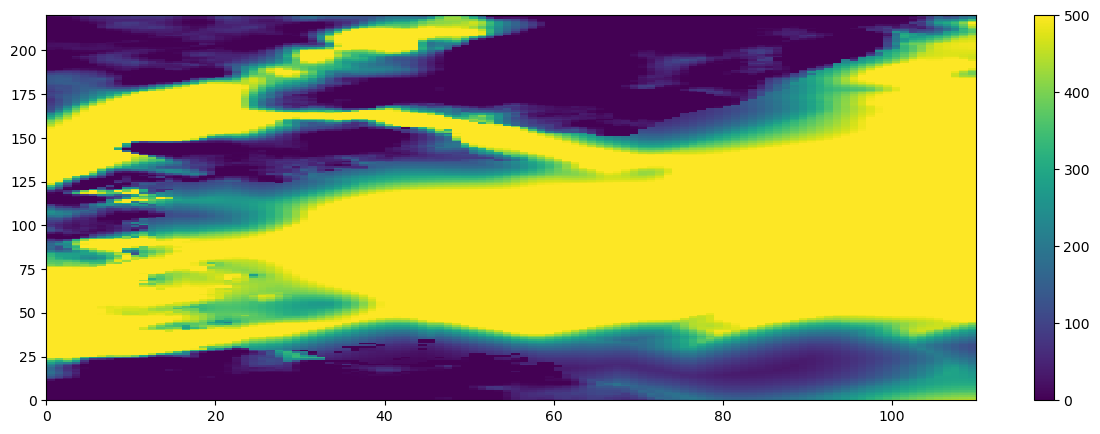

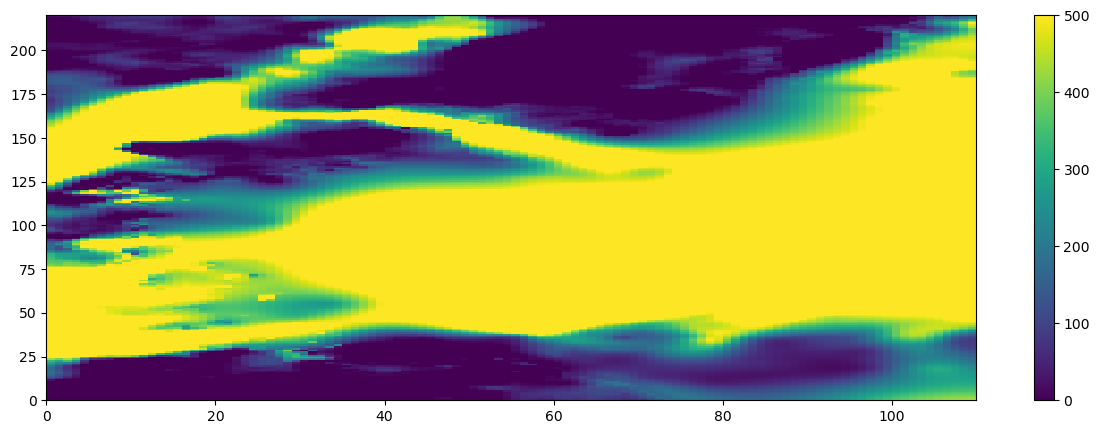

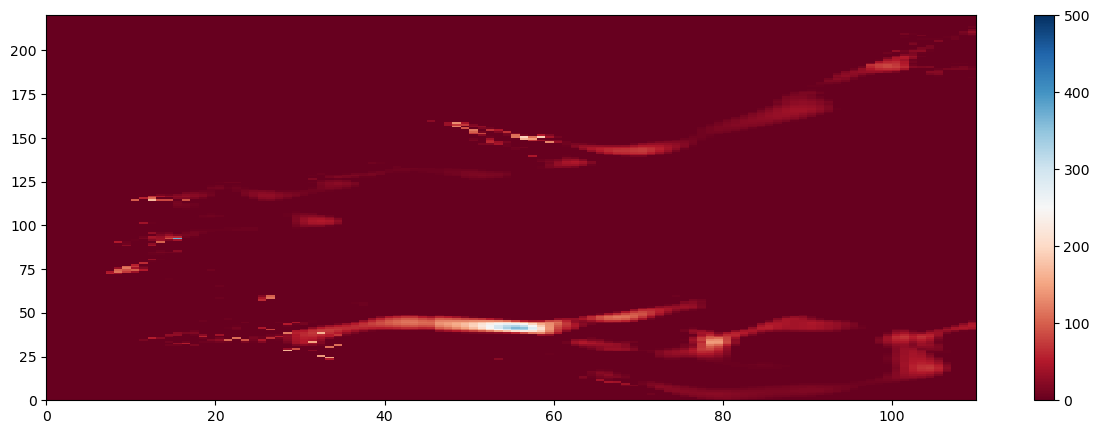

In [20]:
plt.figure(figsize=(15,5))
plt.pcolormesh(bed,vmin=00,vmax=500)
plt.colorbar()
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['bathy'],vmin=00,vmax=500)
plt.colorbar()
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['bathy']-bed,vmin=00,vmax=500,cmap='RdBu')
plt.colorbar()

Text(0.5, 1.0, 'draft - ice')

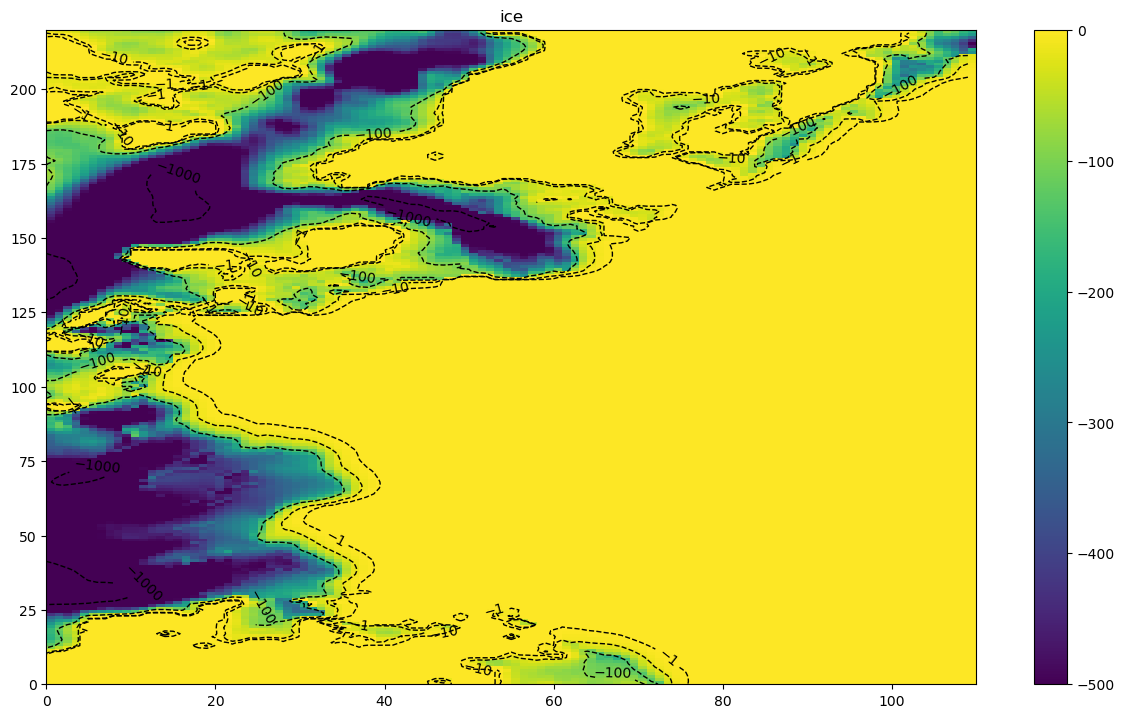

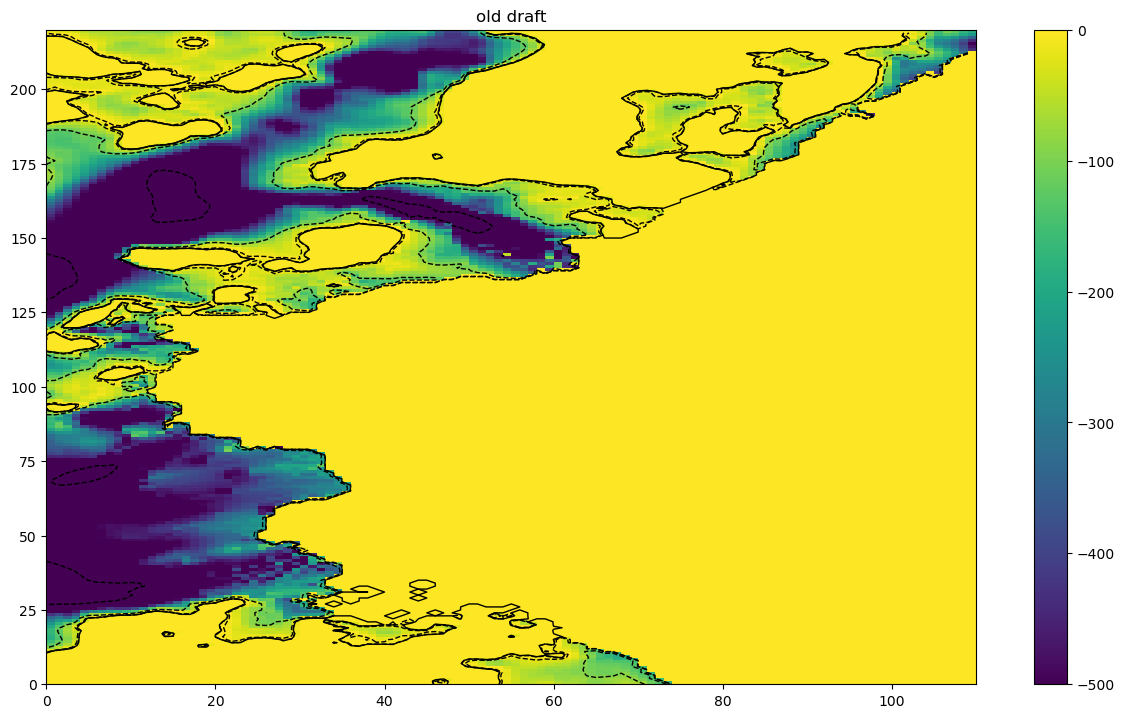

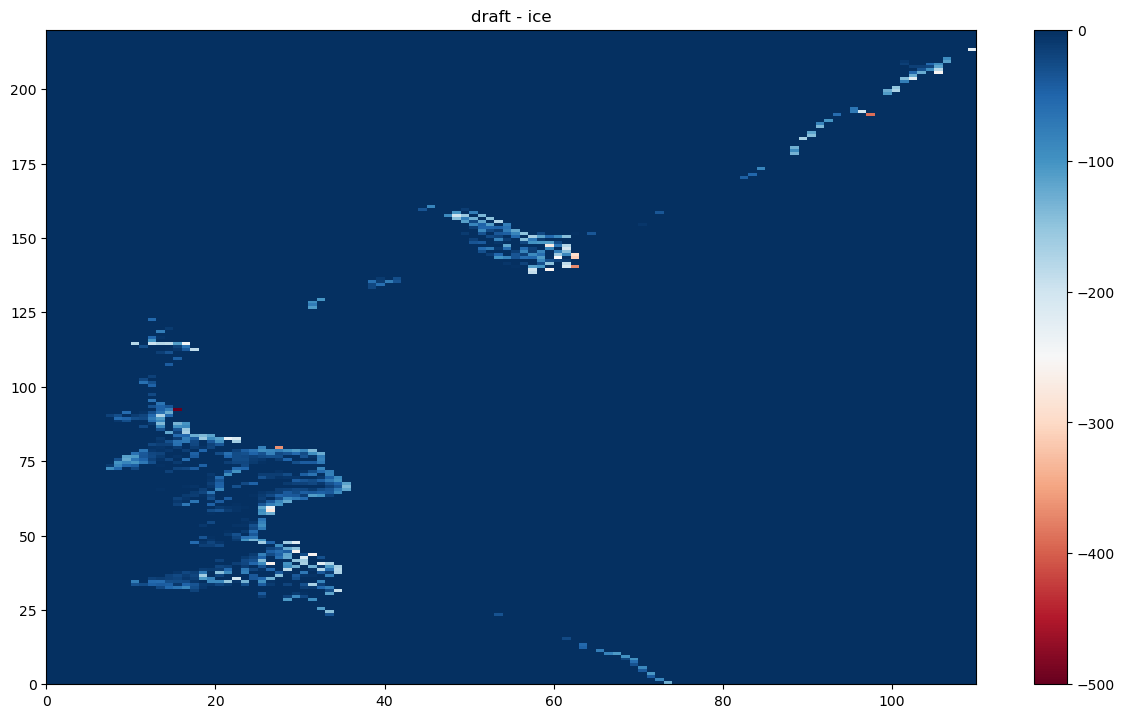

In [21]:
plt.figure(figsize=(15,8.5))
plt.pcolormesh(ice,vmin=-500,vmax=0)
plt.colorbar()
cs=plt.contour(ice,levels=(-1000,-100,-10,-1,0),colors='k',linewidths=1)
plt.clabel(cs)
plt.title('ice')
plt.figure(figsize=(15,8.5))
plt.pcolormesh(roms_tmp['draft'],vmin=-500,vmax=0)
plt.colorbar()
plt.title('old draft')
plt.contour(roms_tmp['draft'],levels=(-1000,-100,-10,-1,0),colors='k',linewidths=1)
plt.figure(figsize=(15,8.5))
plt.pcolormesh(roms_tmp['draft']-ice,vmin=-500,vmax=0,cmap='RdBu')
plt.colorbar()
plt.title('draft - ice')

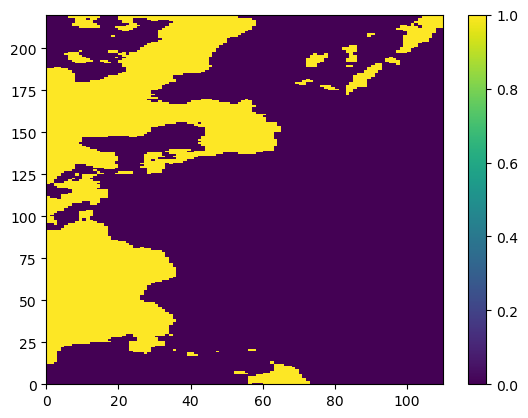

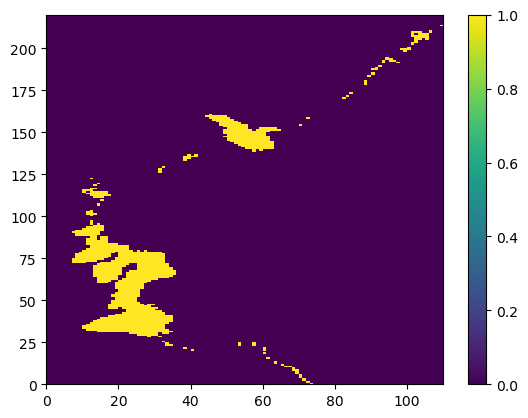

In [22]:
#mask new ice by old ice boundaries
mask_newice_50m = ice<-50
# ice = ice*mask_ice
ice = ice*mask_newice_50m
# plt.pcolormesh(mask_newice_1m)
plt.close('all')
plt.figure()
plt.pcolormesh(ice<-10)
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(mask_ice)
plt.colorbar()
plt.show()

deepen bedrock in shallow open ocean and thin cavity


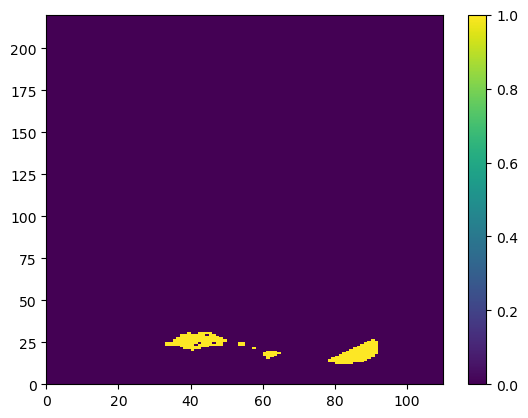

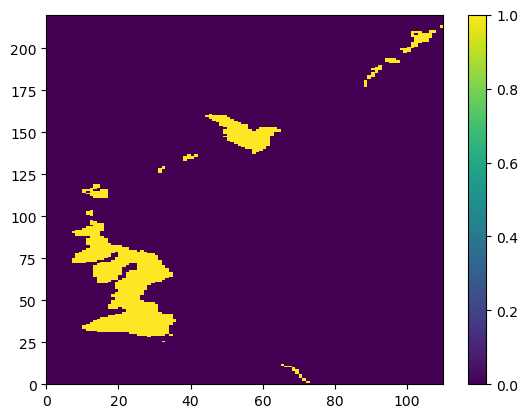

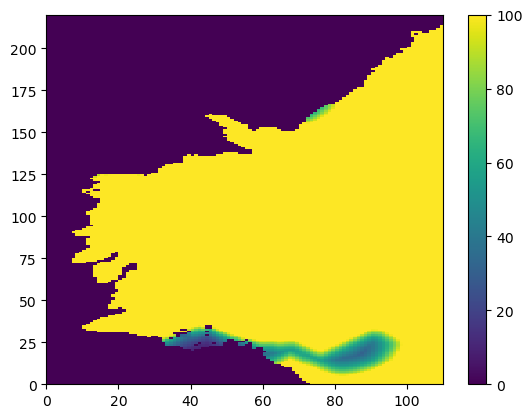

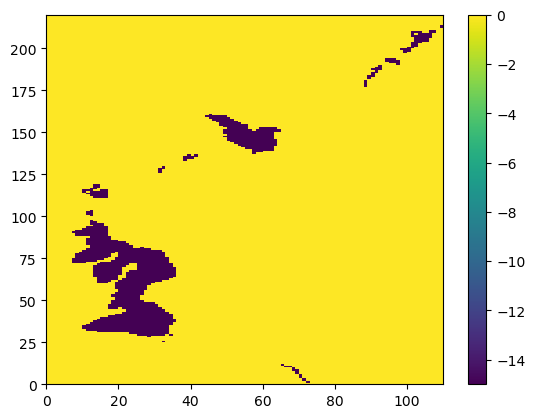

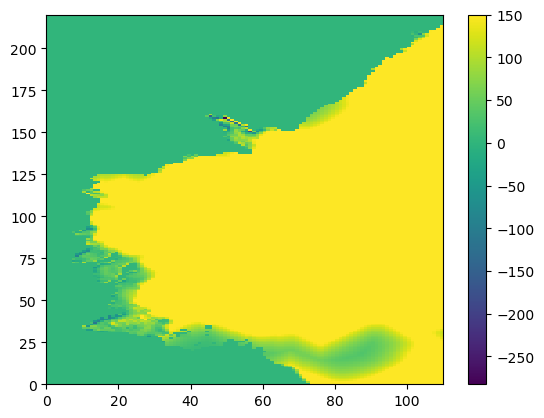

  
Minimum r-value =  0.0
Maximum r-value =  0.766558051109314
Mean    r-value =  0.018044484145824085
Median  r-value =  0.00601082481443882


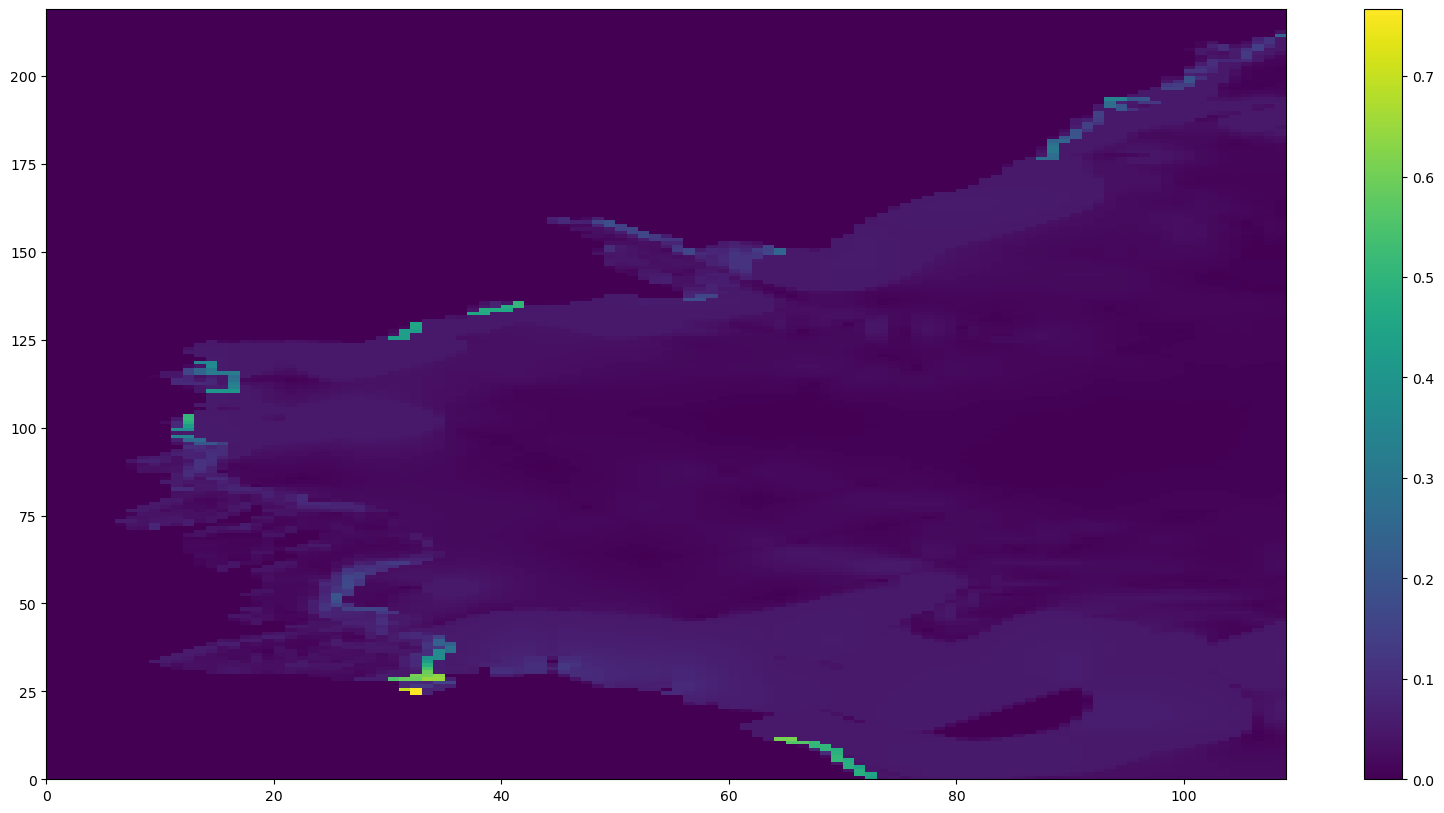

  
Minimum r-value =  0.0
Maximum r-value =  178.8683032581797
Mean    r-value =  1.390404521190335
Median  r-value =  0.14741811919207853


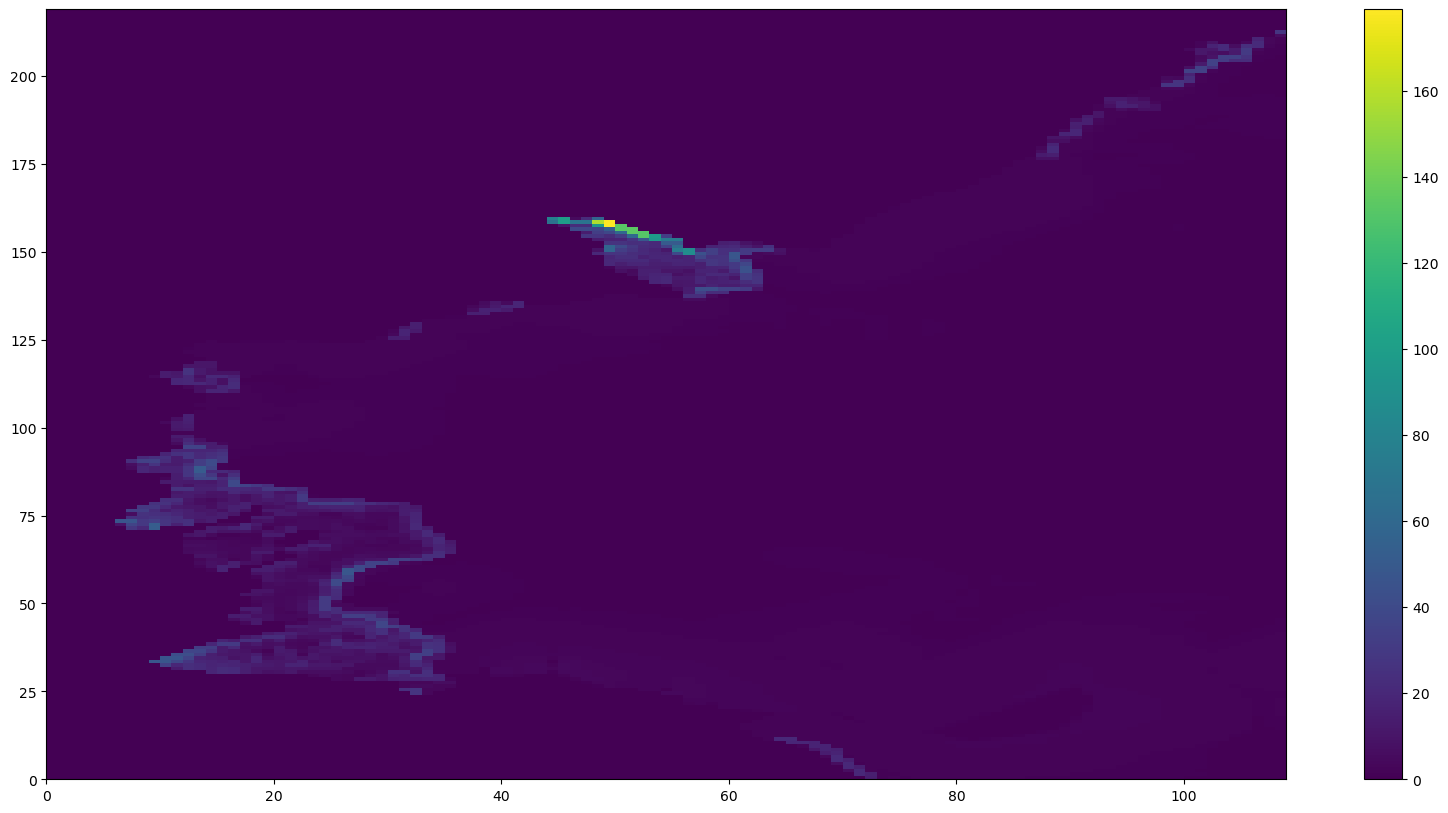

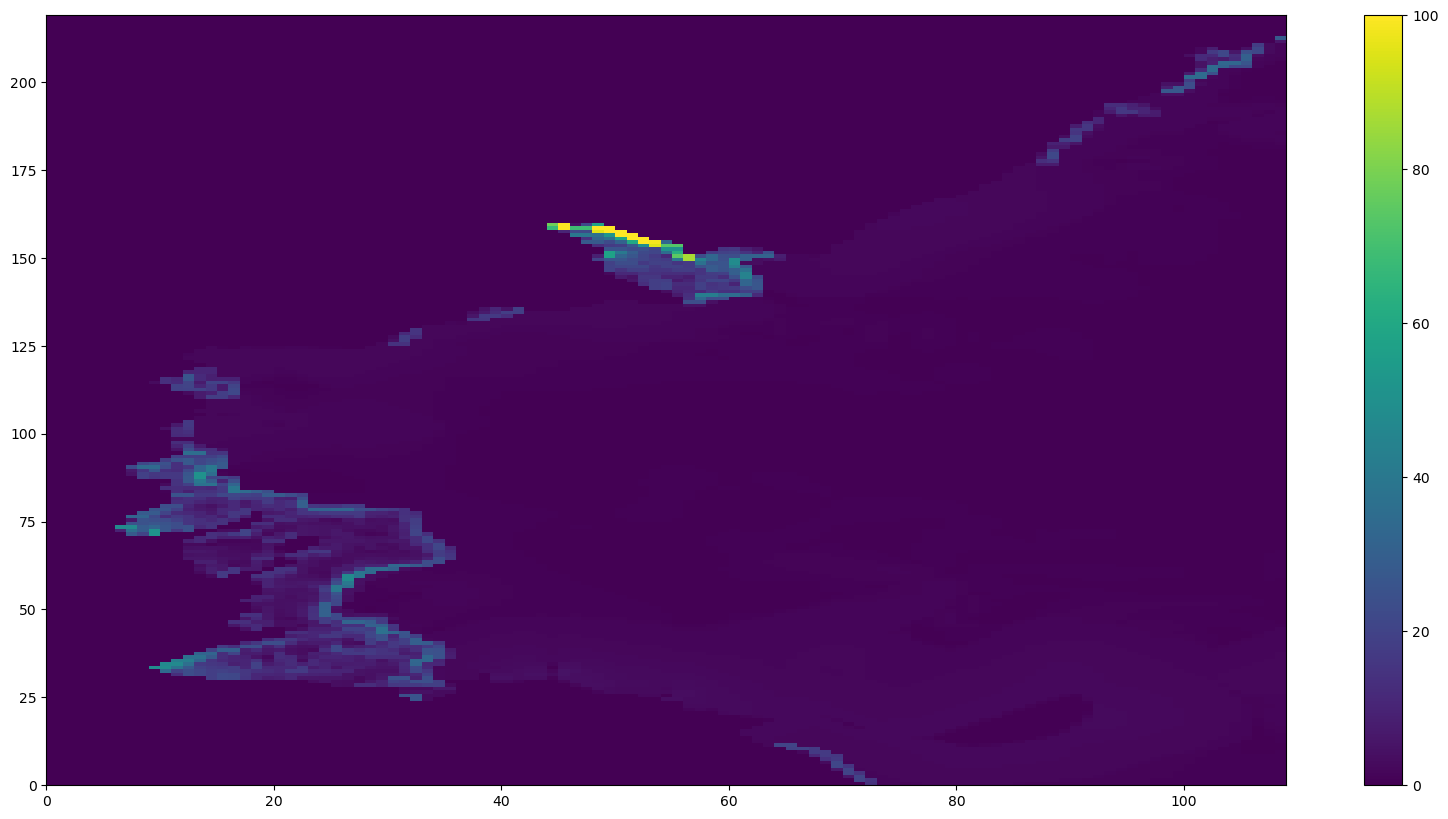

In [23]:
print('deepen bedrock in shallow open ocean and thin cavity')
min_depth_open_ocean = 50.0
min_depth_under_ice = 350.0


plt.pcolormesh(((bed+ice) < min_depth_open_ocean) & (mask == 1) & (ice == 0))
plt.colorbar()
plt.show()
plt.pcolormesh(((bed+ice) < min_depth_under_ice) & (mask == 1) & (ice < 0))
plt.colorbar()
plt.show()
# plt.pcolormesh(ice==0)
# plt.colorbar()
# plt.show()
plt.pcolormesh(bed*mask,vmax=100)
plt.colorbar()
plt.show()
plt.pcolormesh(ice*mask,vmin=-15)
plt.colorbar()
plt.show()
plt.pcolormesh((bed+ice)*mask,vmax=150)
plt.colorbar()
plt.show()

if True:
    ii = ((bed + ice) < min_depth_open_ocean) & (mask == 1) & (ice == 0) #set the minimum open ocean water column thickness
    bed[ii] = -ice[ii] + min_depth_open_ocean
    wct=bed+ice

    ii = ((bed + ice) < min_depth_under_ice) & (mask == 1) & (ice < 0) #set the minimum wct beneath ice shelf
    bed[ii] = -ice[ii] + min_depth_under_ice
    wct=bed+ice



z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice*(roms_tmp['draft']<0))

fig = plt.figure(figsize=(20,10))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_mid,vmin=0,vmax=100)
plt.colorbar()
plt.show()

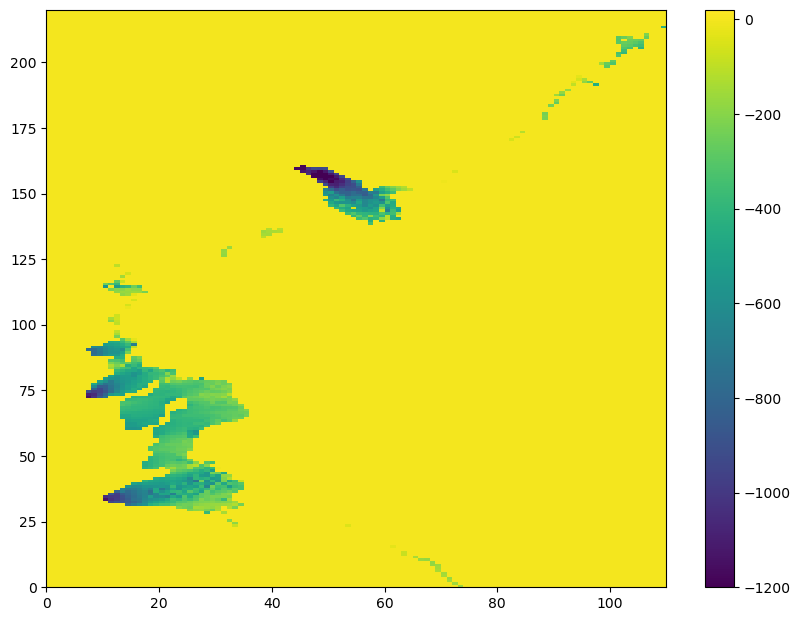

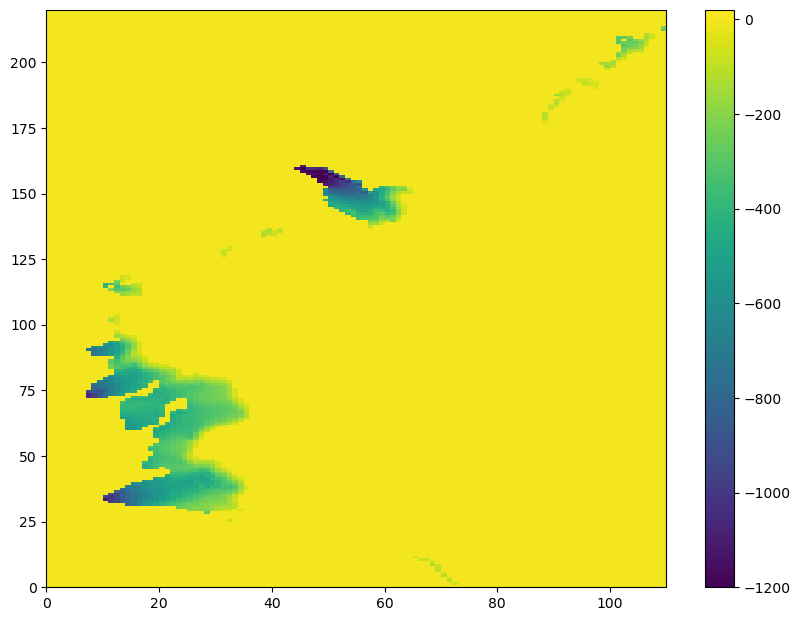

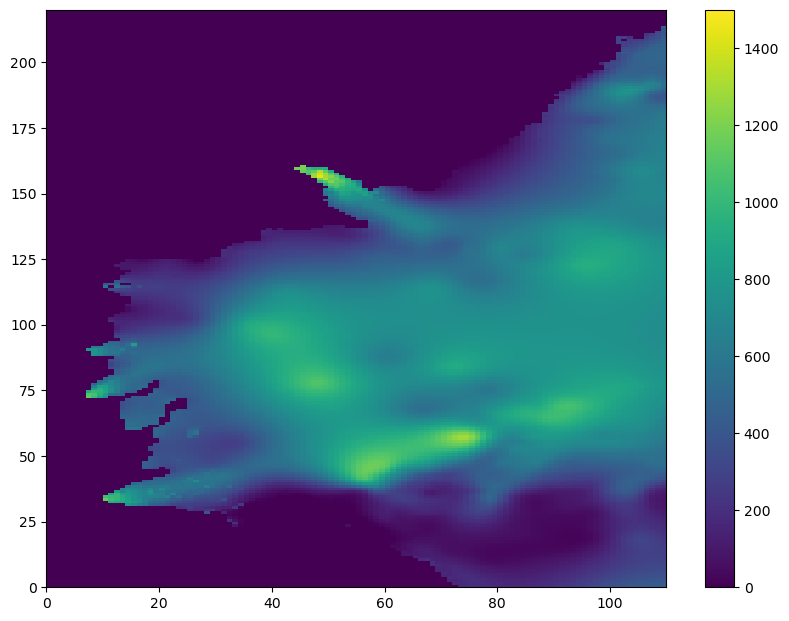

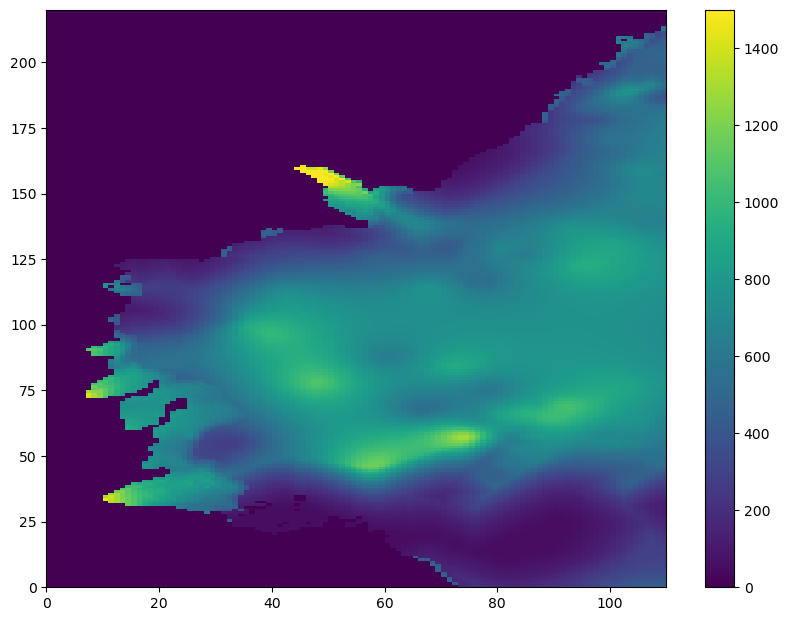

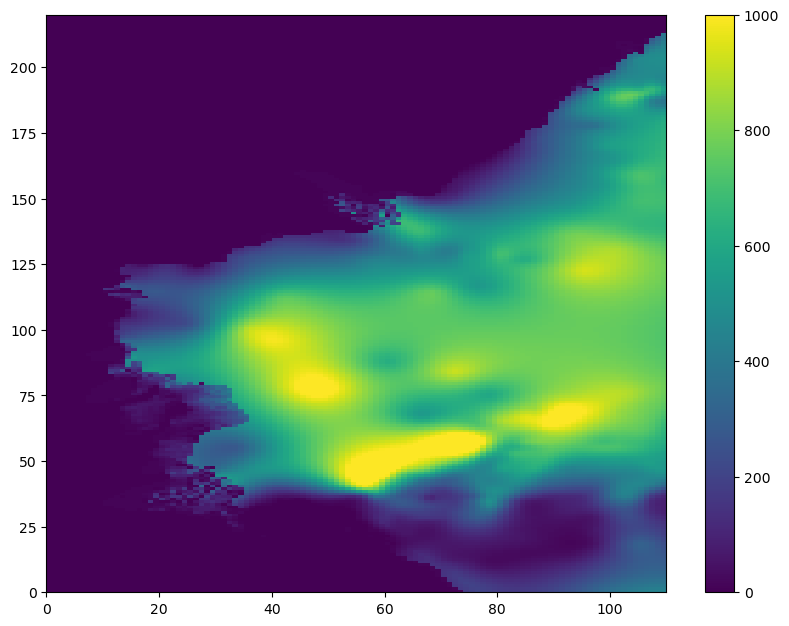

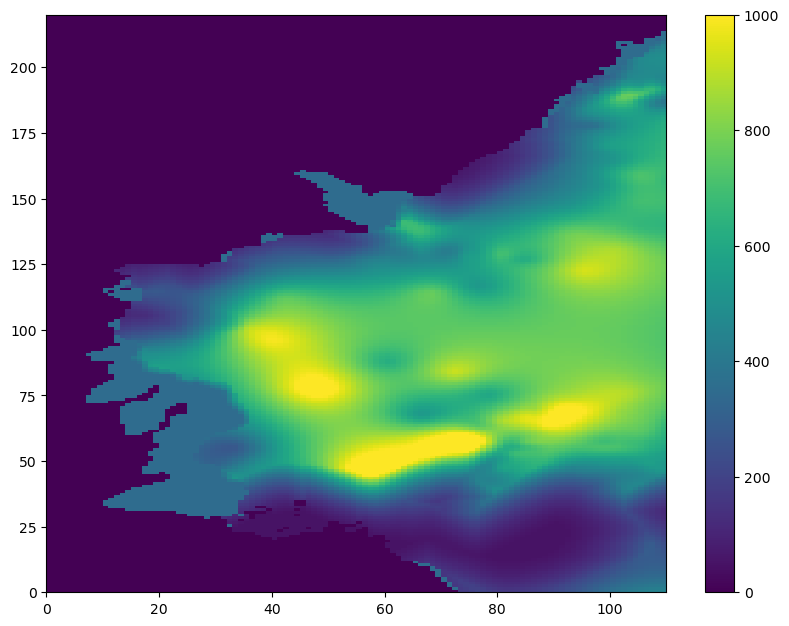

In [24]:
plt.figure(figsize=(10,7.5))
plt.pcolormesh(roms_tmp['draft']*mask,vmin=-1200,vmax=20)
plt.colorbar()
plt.figure(figsize=(10,7.5))
plt.pcolormesh(ice*mask,vmin=-1200,vmax=20)
plt.colorbar()
plt.figure(figsize=(10,7.5))
plt.pcolormesh(roms_tmp['bathy']*mask,vmin=000,vmax=1500)
plt.colorbar()
plt.figure(figsize=(10,7.5))
plt.pcolormesh(bed*mask,vmin=0,vmax=1500)
plt.colorbar()
plt.figure(figsize=(10,7.5))
plt.pcolormesh((roms_tmp['bathy']+roms_tmp['draft'])*mask,vmin=000,vmax=1000)
plt.colorbar()
plt.figure(figsize=(10,7.5))
plt.pcolormesh((bed+ice)*mask,vmin=0,vmax=1000)
plt.colorbar()
# # # plt.figure(figsize=(10,7.5))
# # plt.pcolormesh(ice-ice_o,vmin=-20,vmax=20)
# # plt.colorbar()
# # plt.figure(figsize=(10,7.5))
# # plt.pcolormesh(mask_ice)
# # plt.colorbar()
# # plt.figure(figsize=(10,7.5))
# # plt.pcolormesh(mask_ice*(ice-ice_o),vmin=-100,vmax=100)
# # plt.colorbar()
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh(mask_ice)
# plt.colorbar()
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh((mask_ice==0)*mask)
# plt.colorbar()

In [25]:
# plt.figure(figsize=(20,15))
# plt.pcolormesh(bed,vmin=0,vmax=2000)
# plt.colorbar()

In [26]:
# plt.figure(figsize=(20,15))
# plt.pcolormesh(ice,vmin=-10,vmax=0)
# plt.colorbar()

In [27]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

whole domain
min/max zice is -1371.2407 / 0.0
min/max h is 0.3 / 1721.2407
min/max wct is 0.2999878 / 1293.0347
ocean cells
min/max zice is -1371.24072265625 / -0.0
min/max h is 50.0 / 1721.24072265625
min/max wct is 50.0 / 1293.03466796875


In [28]:
# min_depth_open_ocean = 50.0
# min_depth_under_ice = 250.0

# plt.pcolormesh(((roms_tmp['bathy'] + roms_tmp['draft']) < min_depth_open_ocean) & (mask == 1) & (roms_tmp['draft'] == 0))
# plt.colorbar()
# plt.show()
# plt.pcolormesh(((roms_tmp['bathy'] + roms_tmp['draft']) < min_depth_under_ice) & (mask == 1) & (roms_tmp['draft'] < 0))
# plt.colorbar()
# plt.show()
# plt.pcolormesh(bed*mask,vmax=100)
# plt.colorbar()
# plt.show()
# plt.pcolormesh(ice*mask,vmin=-150)
# plt.colorbar()
# plt.show()
# plt.pcolormesh((bed+ice)*mask,vmax=150)
# plt.colorbar()

In [29]:
# # where ever the wct<min_depth, deepen the 

# # bed_smooth1 = bed.copy()
# # ice_smooth1 = ice.copy()
# # wct_smooth1 = bed.copy()+ice.copy()
# # min_depth_open_ocean = 50.0
# # min_depth_under_ice = 150.0

# # ii = ((bed + ice) < min_depth_open_ocean) & (mask == 1) & (ice == 0) #set the minimum open ocean water column thickness
# # bed[ii] = -ice[ii] + min_depth_open_ocean
# # wct=bed+ice

# # ii = ((bed + ice) < min_depth_under_ice) & (mask == 1) & (ice < 0) #set the minimum wct beneath ice shelf
# # bed[ii] = -ice[ii] + min_depth_under_ice
# # wct=bed+ice

# # plt.pcolormesh(((bed + ice) < min_depth_open_ocean) & (mask == 1) & (ice == 0))
# # plt.colorbar()
# # plt.show()
# # plt.pcolormesh(((bed + ice) < min_depth_under_ice) & (mask == 1) & (ice < 0))
# # plt.colorbar()
# # plt.show()
# plt.pcolormesh(bed*mask,vmax=100)
# plt.colorbar()
# plt.show()
# plt.pcolormesh(ice*mask,vmin=-150)
# plt.colorbar()
# plt.show()
# plt.pcolormesh((bed+ice)*mask,vmax=150)
# plt.colorbar()


In [30]:
# plt.figure(figsize=(20,15))
# plt.pcolormesh(ice-ice_o,vmin=-20,vmax=20,cmap='RdBu_r')
# plt.colorbar()

In [31]:
# # do checks
# print('min/max zice is',ice.min(),'/',ice.max())
# print('min/max h is',bed.min(),'/',bed.max())
# print('min/max wct is',(wct).min(),'/',(wct).max())
# print('ocean cells')
# print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
# print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
# print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

In [32]:

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=270
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((340,420,-1500,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((340,420,-1500,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((340,420,-1500,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((340,420))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=98
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=205
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))



  
Minimum r-value =  0.0
Maximum r-value =  0.766558051109314
Mean    r-value =  0.018044484145824085
Median  r-value =  0.00601082481443882


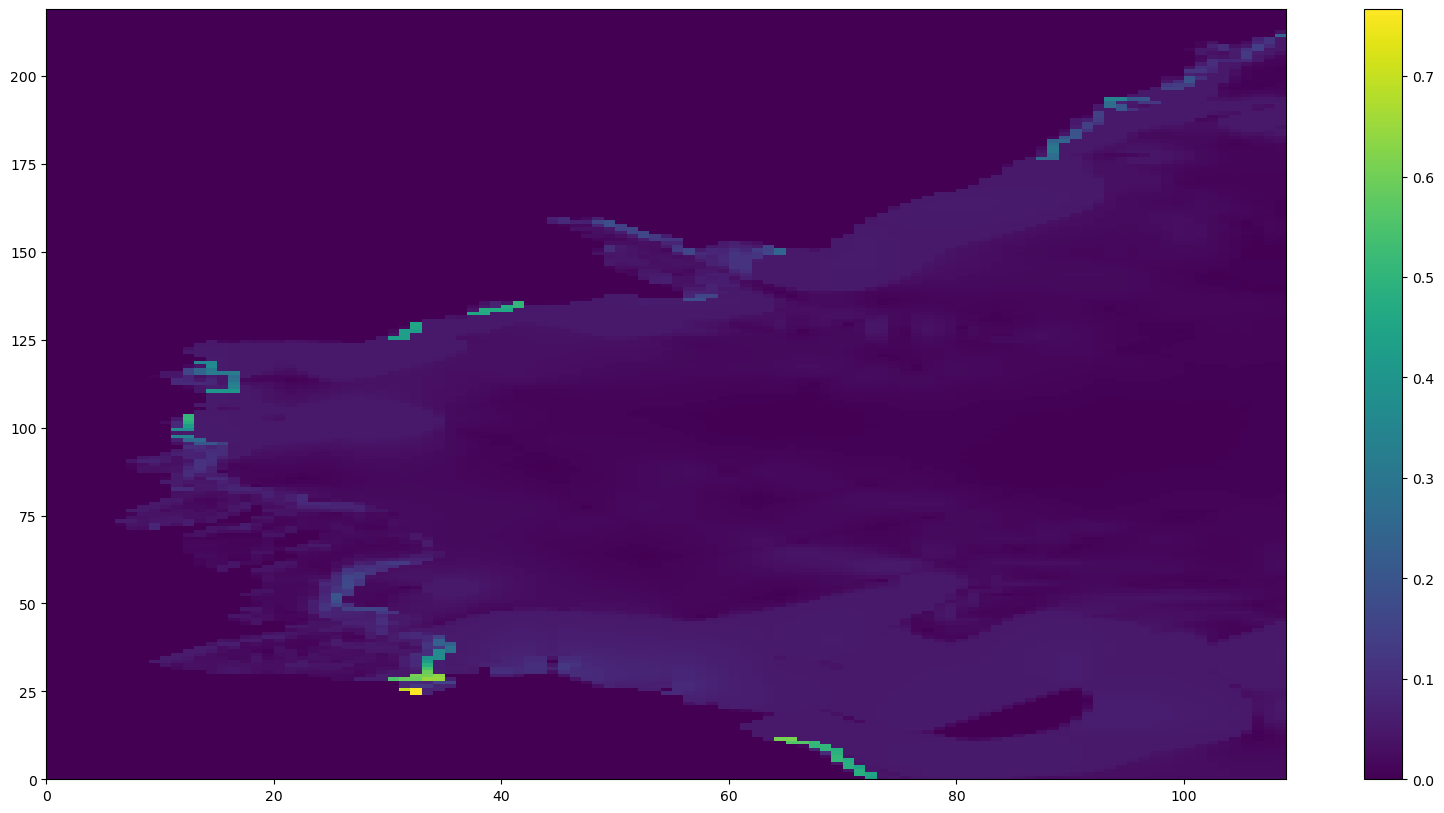

  
Minimum r-value =  0.0
Maximum r-value =  178.8683032581797
Mean    r-value =  1.3491615151251823
Median  r-value =  0.14743042089071312


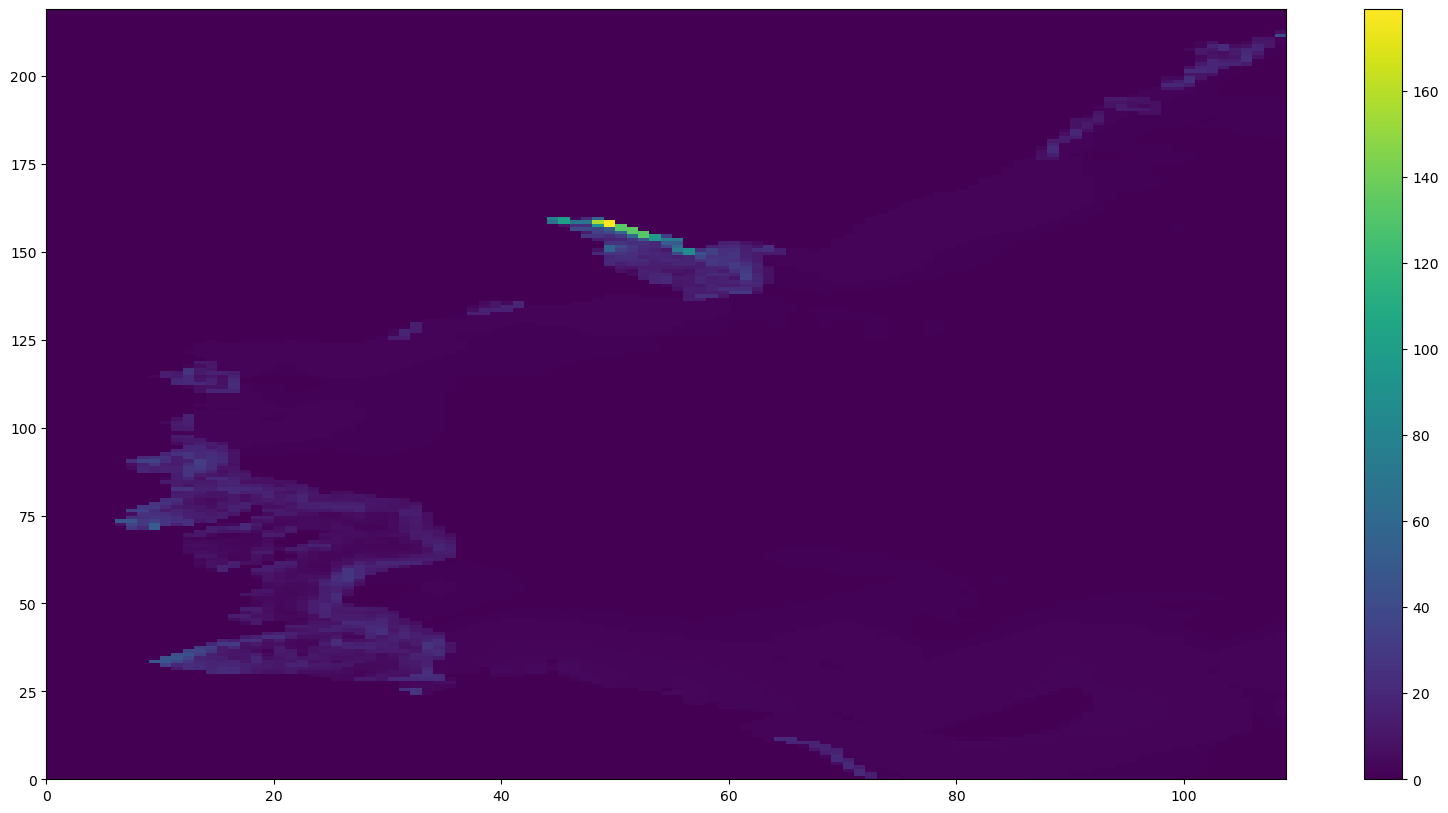

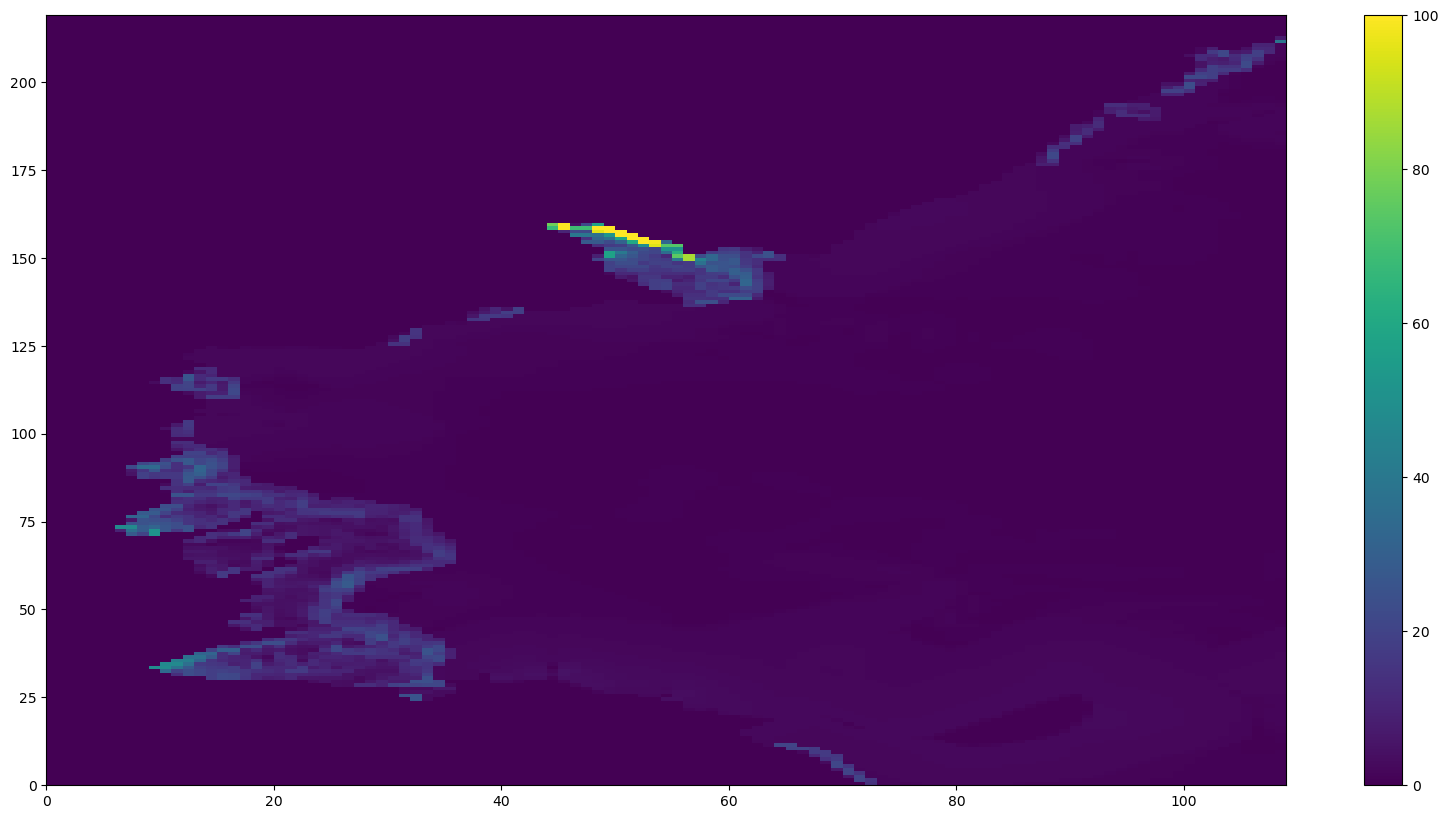

In [33]:


z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)

fig = plt.figure(figsize=(20,10))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_mid,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [34]:

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=29
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# # axs[0].axis((340,420,-1500,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# # axs[1].axis((340,420,-1500,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# # axs[2].axis((340,420,-1500,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# # axs[3].set_xlim((340,420))


# # fig,axs=plt.subplots(4,figsize=(10,10))
# # plot_where=98
# # axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# # axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# # axs[0].axis((320,380,-3000,0))

# # axs[1].plot(-bed[:,plot_where],'.-')
# # axs[1].plot(ice[:,plot_where],'.-')
# # axs[1].plot(-1000*mask[:,plot_where],'.-')
# # axs[1].axis((320,380,-3000,0))

# # axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# # axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# # axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# # axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # # axs[2].plot(-1000*mask[:,plot_where],'.-')
# # axs[2].axis((320,380,-3000,0))

# # axs[3].plot(grd_rx1_pre[:,plot_where-1])
# # axs[3].plot(grd_rx1_mid[:,plot_where-1])
# # axs[3].set_xlim((320,380))

# # fig,axs=plt.subplots(4,figsize=(10,10))
# # plot_where=120
# # axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# # axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# # axs[0].axis((320,380,-3000,0))

# # axs[1].plot(-bed[:,plot_where],'.-')
# # axs[1].plot(ice[:,plot_where],'.-')
# # axs[1].plot(-1000*mask[:,plot_where],'.-')
# # axs[1].axis((320,380,-3000,0))

# # axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# # axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# # axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# # axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # # axs[2].plot(-1000*mask[:,plot_where],'.-')
# # axs[2].axis((320,380,-3000,0))

# # axs[3].plot(grd_rx1_pre[:,plot_where-1])
# # axs[3].plot(grd_rx1_mid[:,plot_where-1])
# # axs[3].set_xlim((320,380))


# # fig,axs=plt.subplots(4,figsize=(10,10))
# # plot_where=205
# # axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# # axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# # axs[0].axis((320,380,-3000,0))

# # axs[1].plot(-bed[:,plot_where],'.-')
# # axs[1].plot(ice[:,plot_where],'.-')
# # axs[1].plot(-1000*mask[:,plot_where],'.-')
# # axs[1].axis((320,380,-3000,0))

# # axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# # axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# # axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# # axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # # axs[2].plot(-1000*mask[:,plot_where],'.-')
# # axs[2].axis((320,380,-3000,0))

# # axs[3].plot(grd_rx1_pre[:,plot_where-1])
# # axs[3].plot(grd_rx1_mid[:,plot_where-1])
# # axs[3].set_xlim((320,380))



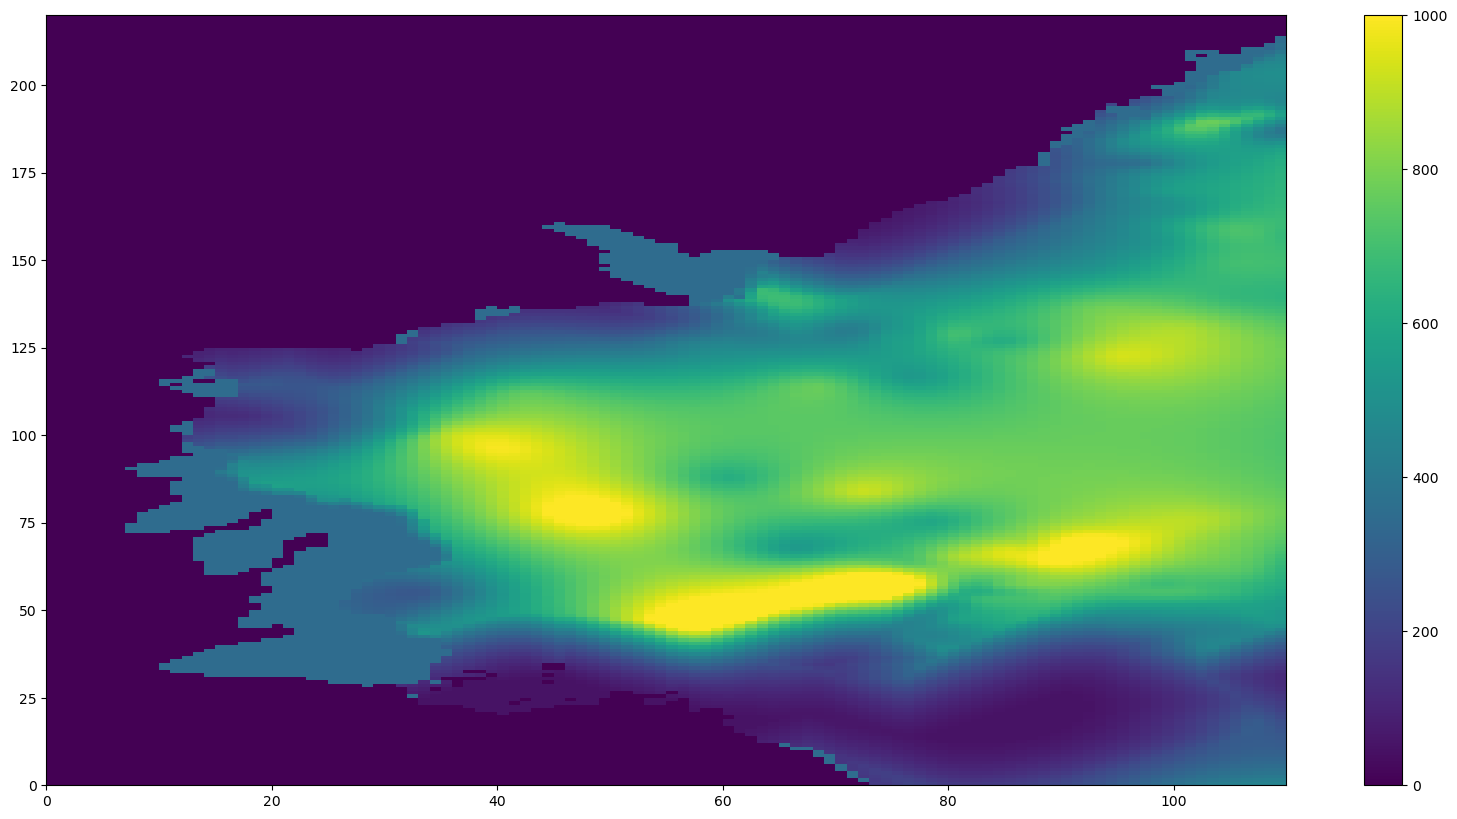

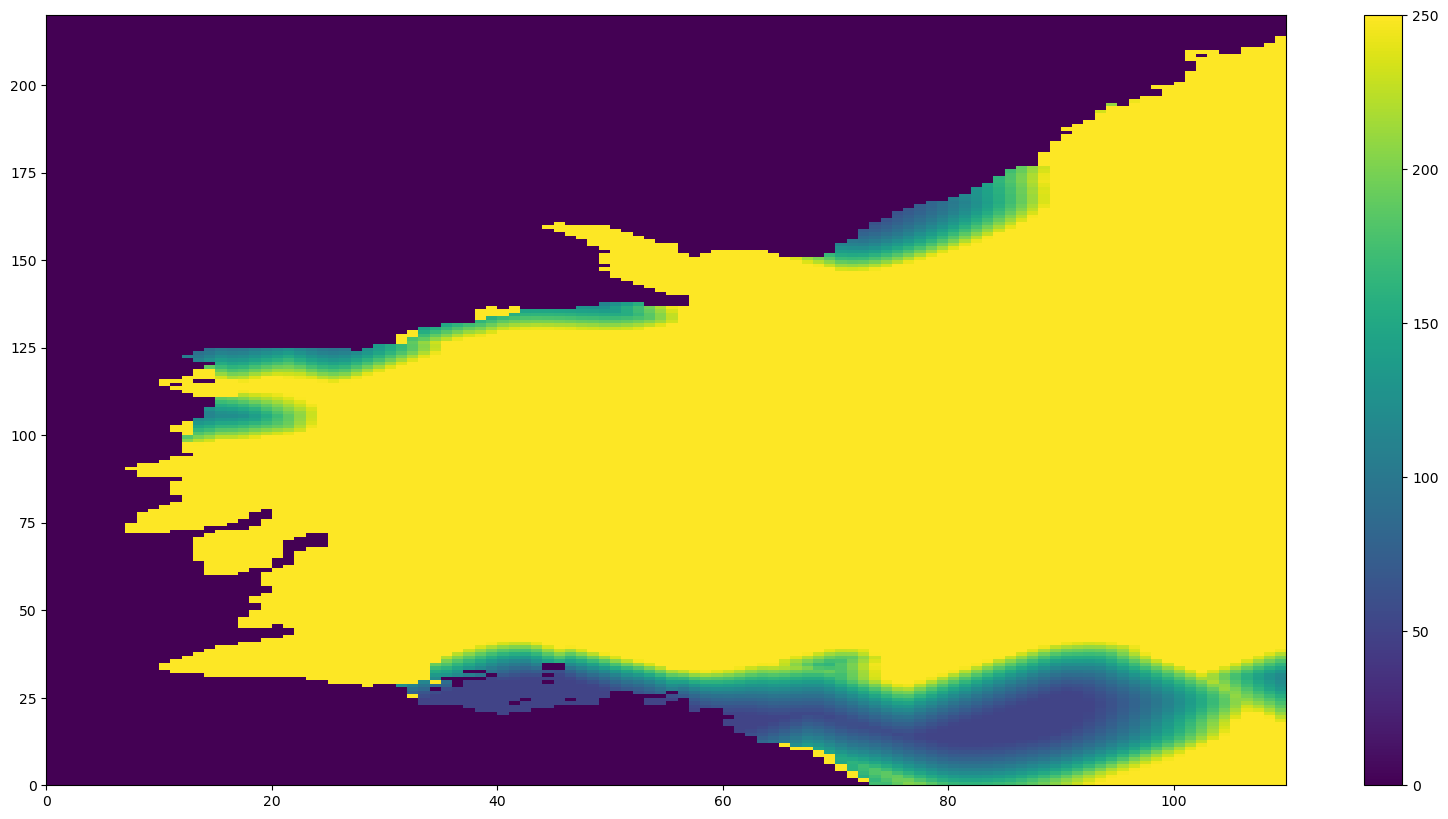

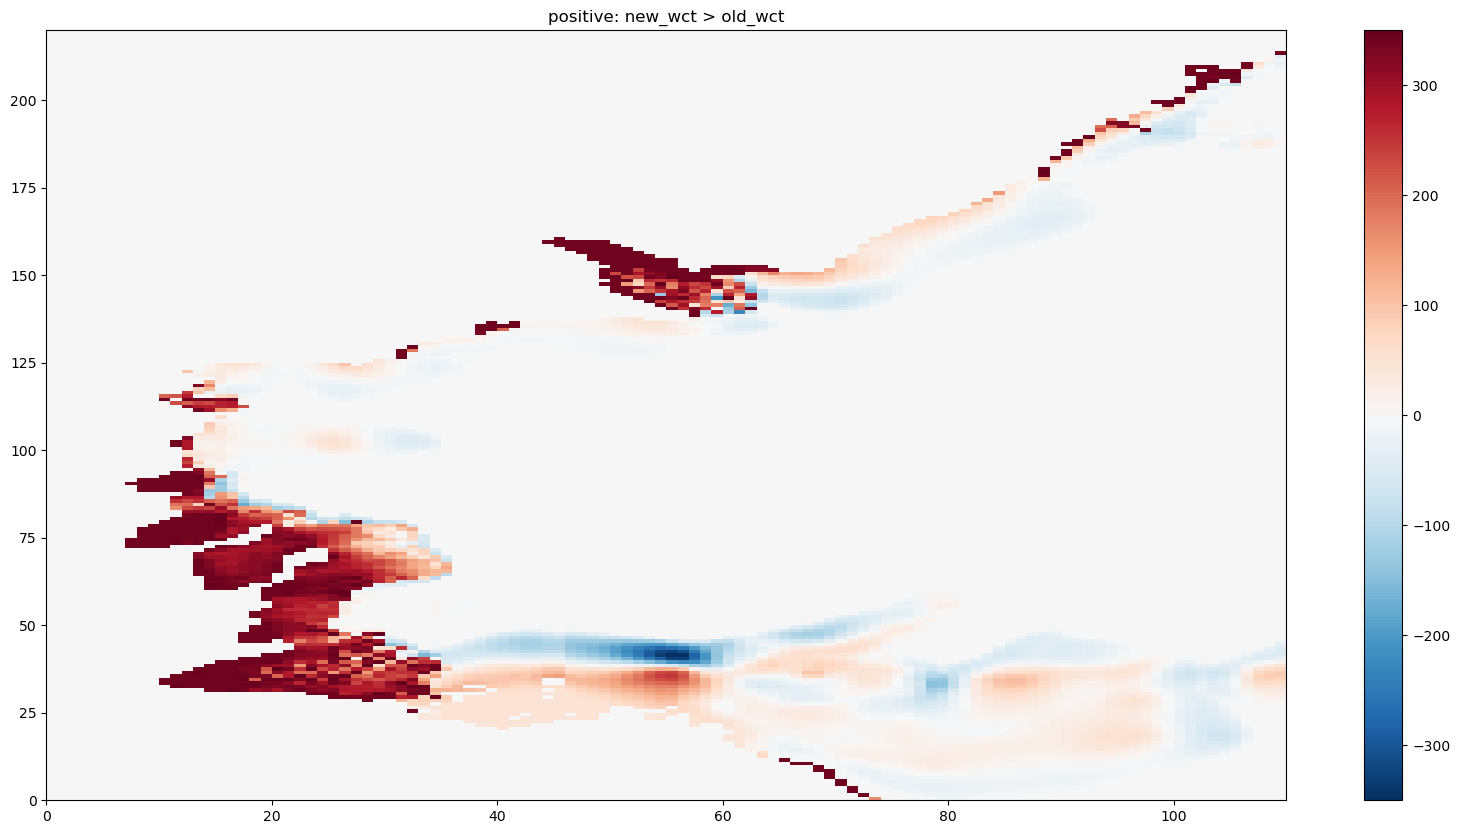

In [35]:
old_wct = (roms_tmp['bathy']+roms_tmp['draft'])*roms_tmp['mask_ocean']
new_wct = (bed+ice)*mask

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(new_wct,vmin=0,vmax=1000)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(new_wct,vmin=0,vmax=250)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(new_wct-old_wct,vmin=-350,vmax=350,cmap='RdBu_r')
plt.title('positive: new_wct > old_wct')
plt.colorbar()

In [36]:
# # check new cavity volume

# print('initial volume was ',initial_volume/1e12,'x10^12 m3')


# print('new volume ',np.sum(mask_amery*(ice+bed)*dx*dy),'m3')
# print(np.sum(mask_amery*(bed+ice)*dx*dy)/1e12,'x10^12 m3')
# print('ratio of new/old volume is ',np.sum(mask_amery*(ice+bed)*dx*dy)/initial_volume)


In [37]:
# i don't think second round of smoothing helps.
# # Second round of smoothing 
# rx0in=0.3
# bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)
# wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct,rx0in,Area,max_iter)
# ice = wct-bed
# bed_smooth2 = bed.copy()
# ice_smooth2 = ice.copy()

min_depth=50

# Now enforce that there is no ice > 0
ii = ice>0
ice[ii] = 0

# now re-check that min_depth is obeyed for all ocean points
ii = ((bed + ice) < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

# do the same for all non-ocean points
ii = ((bed + ice) < min_depth) & (mask == 0)
ice[ii] = min_depth-bed[ii] # for those locations, the depth needs to be min_depth above the bathy

wct=bed+ice

In [38]:
# plt.figure(figsize=(20,15))
# plt.pcolormesh(ice,vmin=-100,vmax=0)

In [39]:

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=270
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((340,420,-1500,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((340,420,-1500,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((340,420,-1500,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((340,420))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=98
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=120
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=205
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))



In [40]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin(wct*maskNaN),'/',np.nanmax(wct*maskNaN))

whole domain
min/max zice is -1371.2407 / 49.7
min/max h is 0.3 / 1721.2407
min/max wct is 50.0 / 1293.0347
ocean cells
min/max zice is -1371.24072265625 / -0.0
min/max h is 50.0 / 1721.24072265625
min/max wct is 50.0 / 1293.03466796875


In [41]:


roms_tmp['bed'] = bed
roms_tmp['ice'] = ice
roms_tmp['mask'] = mask

In [42]:
# if plotting:
#     plt.close()
#     for k,v in roms_tmp.items():
#         plt.figure(figsize=(5,3))
#         print(k)
#         plt.pcolormesh(v)
#         plt.colorbar()
#         plt.show()

In [43]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))
print('max slow DT in s following CFL: ', np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/np.nanmin(CFL)).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))

max fast DT in s following CFL:  8.693045616149902
max slow DT in s following CFL:  122.38314252350563
Set ROMS timestep settings of at least: 
 DT < 122.38314252350563 s 
 NDTFAST > 14.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  2.2482245361061812
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.22482245361061812


In [44]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(bed+ice).min(),'/',(bed+ice).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin(wct*maskNaN),'/',np.nanmax(wct*maskNaN))

whole domain
min/max zice is -1371.2407 / 49.7
min/max h is 0.3 / 1721.2407
min/max wct is 50.0 / 1293.0347
ocean cells
min/max zice is -1371.24072265625 / -0.0
min/max h is 50.0 / 1721.24072265625
min/max wct is 50.0 / 1293.03466796875


  
Minimum r-value =  0.0
Maximum r-value =  0.766558051109314
Mean    r-value =  0.018044484145824085
Median  r-value =  0.00601082481443882


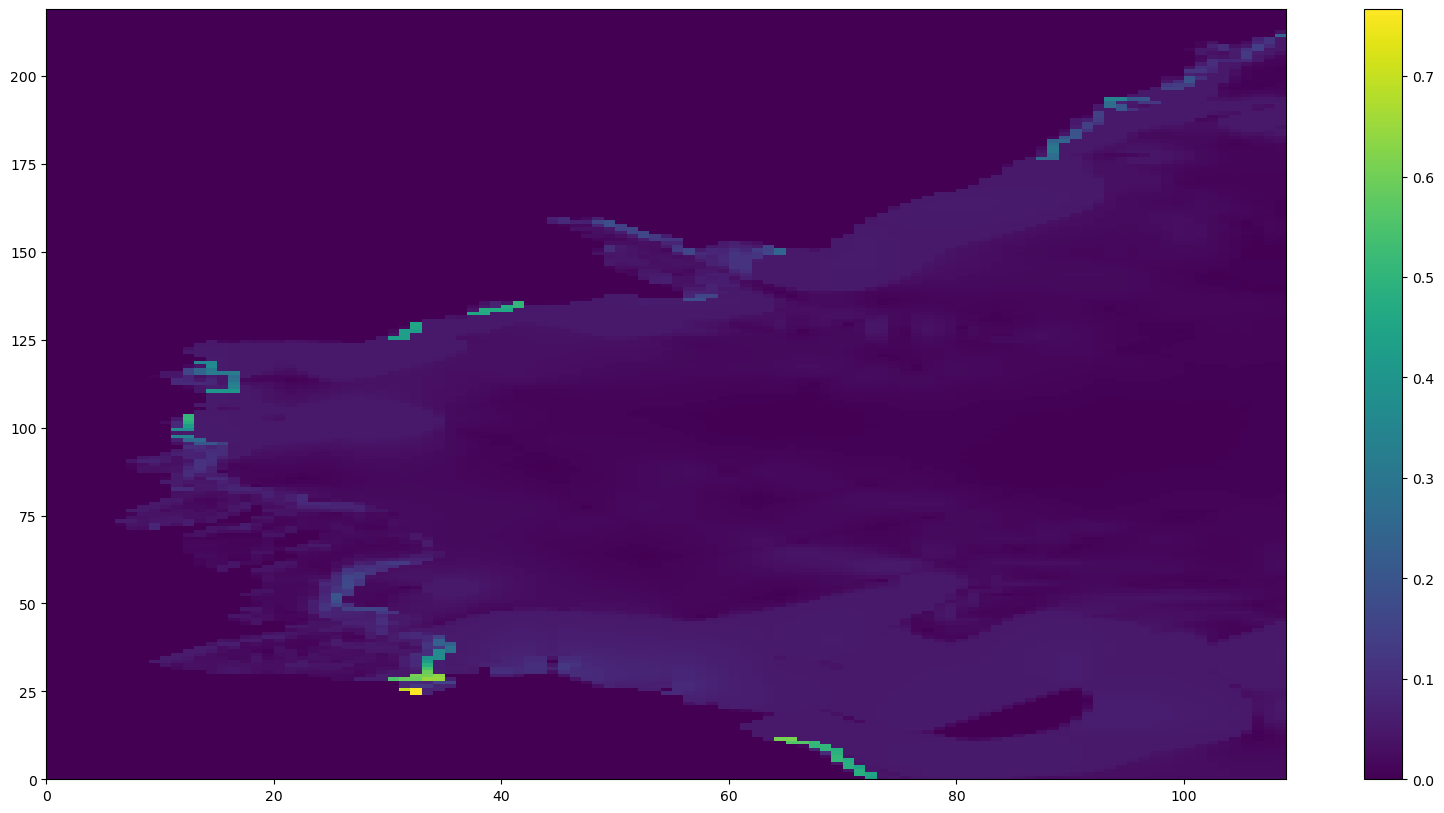

  
Minimum r-value =  0.0
Maximum r-value =  178.8683032581797
Mean    r-value =  1.3491615151251823
Median  r-value =  0.14743042089071312


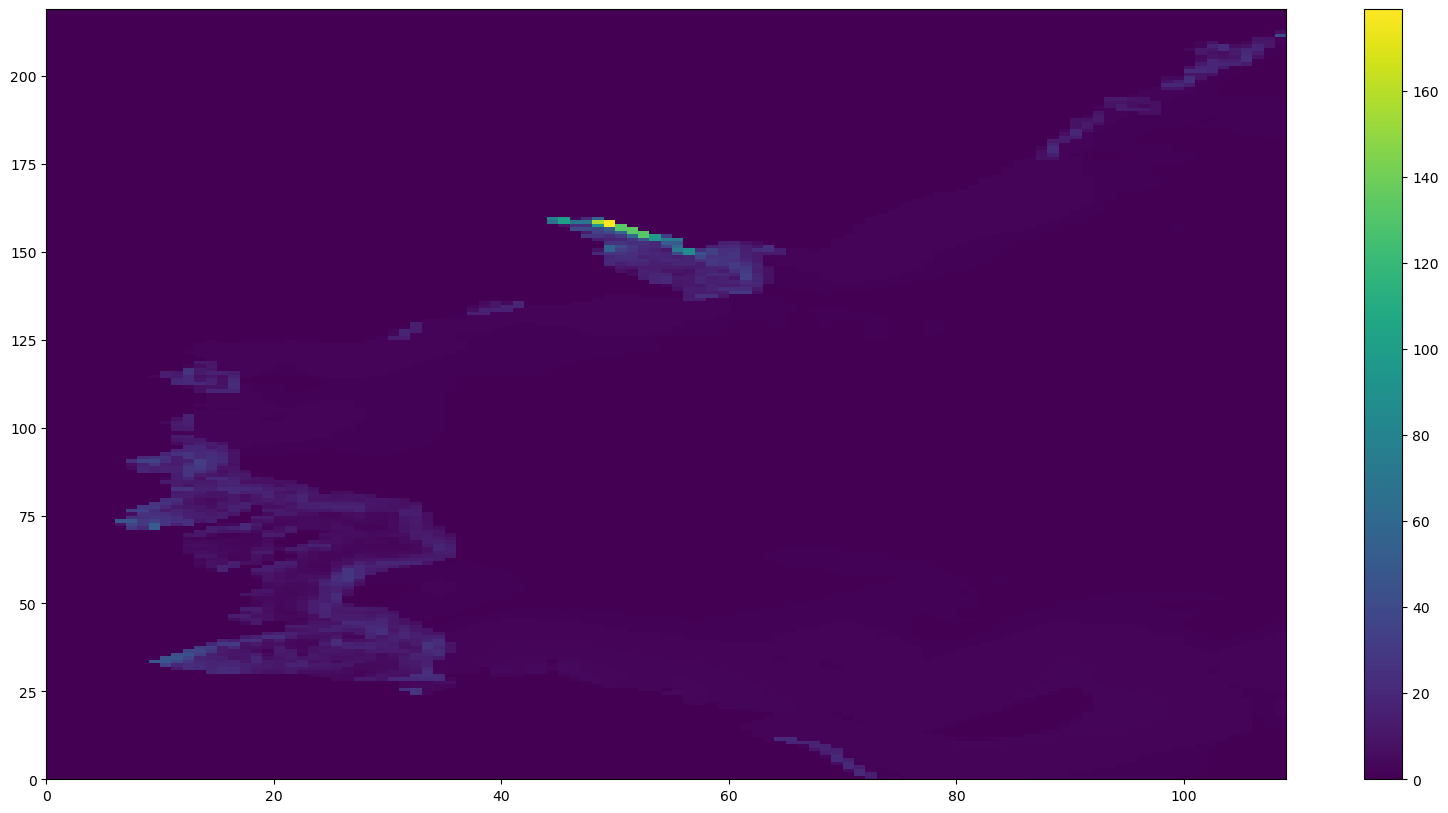

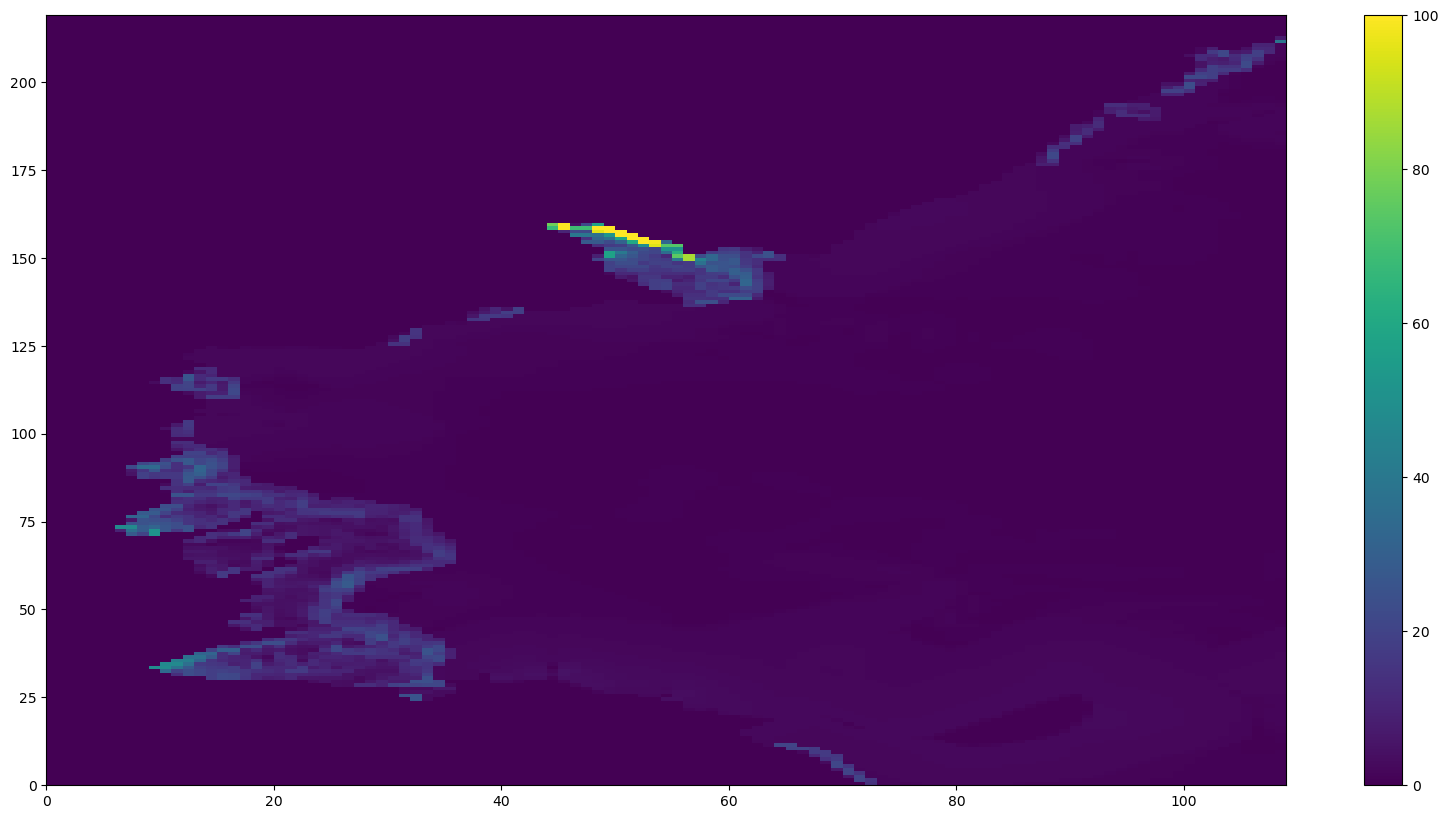

In [45]:



z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bed'],roms_tmp['ice'])

fig = plt.figure(figsize=(20,10))
grd_rx0_post=GridStiffness.rx0(roms_tmp['bed'],roms_tmp['mask'])
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_post=GridStiffness.rx1(z_w_post,roms_tmp['mask'])
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_post,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [46]:
# in_val = zzz.copy()
# ocean_mask = mmm.copy()
# rx0val = 0.06
# Area = Area
# max_iterations = 20
# roi_row_min=395
# roi_row_max=423
# roi_col_min=240
# roi_col_max=280
# if_plotting  = 1

# msk = np.zeros(in_val.shape)

# import matplotlib.pyplot as plt
# %matplotlib inline

# msk[roi_row_min:roi_row_max,roi_col_min:roi_col_max] = 1
# msk = (msk*ocean_mask).copy()
# if if_plotting:
#     plt.pcolormesh(msk)
#     plt.show()
# out_smooth, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(msk,in_val,rx0val,Area,max_iterations)

# if if_plotting:
#     plt.pcolormesh(out_smooth-in_val)
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.show()

#     plt.pcolormesh(out_smooth)
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.show()

# plt.pcolormesh((hhh+zzz)*msk)
# plt.colorbar()
# plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
# plt.show()

# plt.pcolormesh((hhh+zzz - out_smooth)*msk)
# plt.colorbar()
# plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
# plt.show()


In [47]:
# # function to deepen bathy to enforce minimum WCT in a certain region


# hhh=roms_tmp['bed'].copy()
# zzz=roms_tmp['ice'].copy()
# mmm=roms_tmp['mask'].copy()



# in_z = zzz.copy()
# in_h = hhh.copy()
# in_msko = mmm.copy()
# roi_row_min=395
# roi_row_max=423
# roi_col_min=240
# roi_col_max=280
# if_plotting  = 1
# min_threshold_h = 75

# msk = np.zeros(in_h.shape)
# plt.close('all')
# import matplotlib.pyplot as plt
# %matplotlib inline

# msk[roi_row_min:roi_row_max,roi_col_min:roi_col_max] = 1
# msk = (msk*ocean_mask).copy()

# if if_plotting:
#     plt.pcolormesh(msk)
#     plt.show()

# wct_thr = (in_z+in_h) < min_threshold_h

# msk_full = (wct_thr*msk)
# msk_full = msk_full==1


# out = in_h.copy()
# out[msk_full] = -in_z[msk_full] + min_threshold_h

# if if_plotting:
#     plt.pcolormesh(msk_full)
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.title('msk_full')
#     plt.show()

#     plt.pcolormesh(out)
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.title('new h')
#     plt.show()

#     plt.pcolormesh((in_h+in_z)*msk)
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.title('old wct')
#     plt.show()

#     plt.pcolormesh((out - in_h))
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.title('diff in wct (new-old)')
#     plt.show()

In [48]:
# plt.figure(figsize=(20,15))
# plt.pcolormesh(roms_tmp['ice'],vmin=-200,vmax=0)

In [49]:

# # correct ice so that it isn't adjusted where it never previously existed.
# zzz_backup = roms_tmp['ice'].copy()

# # OPTION 1:
# # need to correct to only update ice below ice shelves. Could do it with a find ice<0, or could just multiply by mask....
# # This will keep the strict masking and precisely defined ice shelf edges 
# #zzz = zzz_backup*(mask_openocean==0) 

# #OPTION 2:
# # manually remove any false ice. This will leave the slight smoothing that has been applied through the smoothin process.
# # This will keep the reduced rx1 at the edge of ice shelves.
# roms_tmp_ice_da = xr.DataArray(roms_tmp['ice'],name='ice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'roms_["ice"]', 'units': 'meter'})
# try:
#     roms_tmp_ice_da.to_netcdf('../data/proc/temporary_zice.nc')
# except:
#     print('already opened somewhere!')

# # plt.close('all')
# # # import matplotlib
# # # matplotlib.use('Qt5Agg')
# # import matplotlib.pyplot as plt
# # import PyQt5
# # %matplotlib qt
# # # import mplcursors

# # fig,ax=plt.subplots(figsize=(15,10))
# # im = ax.pcolormesh(roms_tmp['ice']!=0)
# # # cursor = mplcursors.cursor(im, hover=True)
# # pts = plt.ginput(n=-1)

# # plt.show()

# masking_ds = xr.open_dataset('../data/proc/temporary_zice_mask.nc')

# plt.figure()
# plt.pcolormesh(~masking_ds.IN_icemask)
# plt.colorbar()

# plt.figure()
# plt.pcolormesh(roms_tmp['ice']*~masking_ds.IN_icemask*roms_tmp['mask'],vmin=-20,vmax=0)
# plt.colorbar()
# plt.show()

# # if input('Are you happy with this? (Y/N)?')=='Y':
# print('continuing...')
# roms_tmp['ice'] = (roms_tmp['ice']*~masking_ds.IN_icemask.values).copy()
    
# # else:
# #     STOP
# # print(pts)

In [50]:
# !!! BEWARE, ALL YE WHO ENTER HERE, THE REALM OF HAND-EDITING SUB-ICE SHELF GEOMETRY. HERE BE DRAGONS. !!!
# ensure that GridAdjustments functions are already loaded.


hhh=roms_tmp['bed'].copy()
zzz=roms_tmp['ice'].copy()
mmm=roms_tmp['mask'].copy()

hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=159,xi=49)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=159,xi=45)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=158,xi=50)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=158,xi=49)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-200,zice_alter=200,eta=157,xi=50)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=157,xi=51)

hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=156,xi=52)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=155,xi=53)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=154,xi=slice(54,57))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=-50,eta=157,xi=51)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=157,xi=51)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-150,eta=155,xi=53)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=150,xi=56)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=158,xi=49)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=156,xi=51)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=155,xi=52)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=154,xi=53)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=159,xi=slice(46,48))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=151,xi=56)

mmmNaN = mmm.copy().astype('float')
mmmNaN[mmmNaN == 0] = np.NaN

#smoothing rx0 values
hhh = smoothing_Laplacian_rx0(mmm,hhh,0.4)



Iteration # 1
current r= 0.766558051109314   nbPointMod= 69 
 
Iteration # 2
current r= 0.41561639978308335   nbPointMod= 8 
 
Iteration # 3
current r= 0.39843641615210545   nbPointMod= 0  no erase
 


  
Minimum r-value =  0.0
Maximum r-value =  0.39843641615210545
Mean    r-value =  0.017696626539818346
Median  r-value =  0.0060108249201510176
  
Minimum r-value =  0.0
Maximum r-value =  58.761145955688434
Mean    r-value =  1.2767674152831667
Median  r-value =  0.14777510707311825


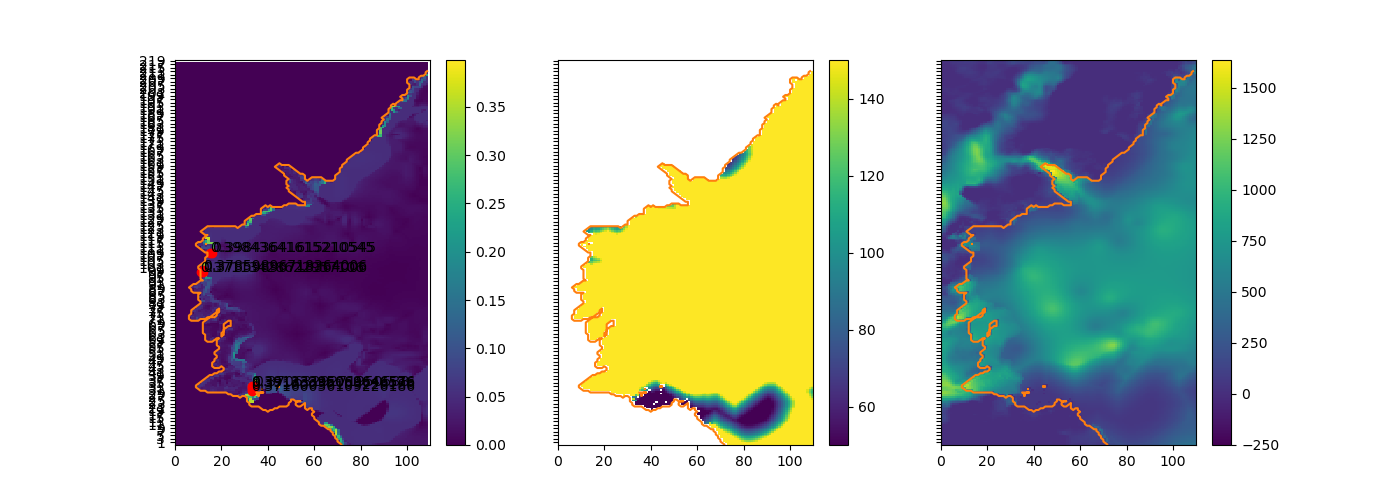

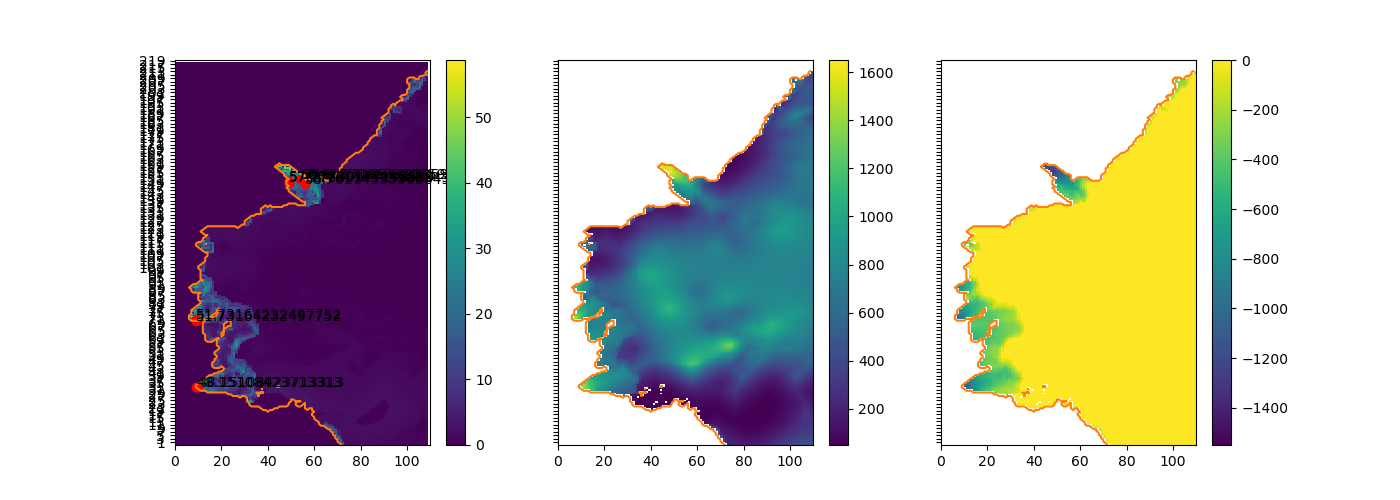

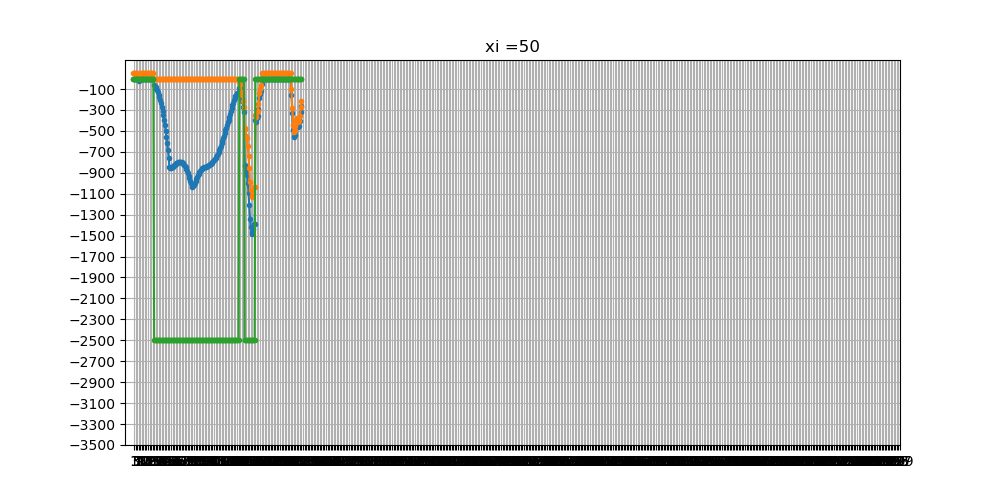

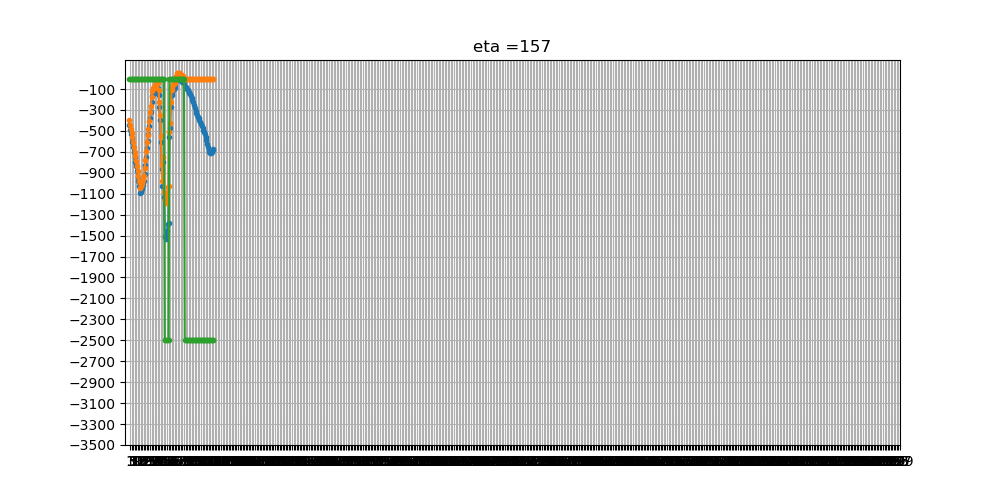

In [51]:

import matplotlib.pyplot as plt
%matplotlib widget
# z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_post=GridStiffness.rx0(hhh,mmm)
grd_rx1_post=GridStiffness.rx1(z_w_post,mmm)

plt.close('all')


fig,axs = plt.subplots(ncols=3,figsize=(14,5),sharex=True,sharey=True)
im=axs[0].pcolormesh(grd_rx0_post)
rx0_flat = grd_rx0_post.ravel()
ind = np.argpartition(rx0_flat,-10)[-10:]
ind
for where in ind: 
    w_j,w_i=np.unravel_index(where,grd_rx0_post.shape)
    axs[0].plot(w_i,w_j,'ro')
    axs[0].text(w_i,w_j,rx0_flat[where])
axs[0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0])
axs[0].contour(mmm,levels=((0,1)),colors='C1')
im=axs[1].pcolormesh((hhh+zzz)*mmmNaN,vmax=150)
axs[1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1])
axs[1].contour(mmm,levels=((0,1)),colors='C1')
im=axs[2].pcolormesh(hhh,vmin=-250)
axs[2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[2])
axs[2].contour(mmm,levels=((0,1)),colors='C1')


fig,axs = plt.subplots(ncols=3,figsize=(14,5),sharex=True,sharey=True)
im=axs[0].pcolormesh(grd_rx1_post)
rx1_flat = grd_rx1_post.ravel()
ind = np.argpartition(rx1_flat,-10)[-10:]
ind
for where in ind: 
    w_j,w_i=np.unravel_index(where,grd_rx1_post.shape)
    axs[0].plot(w_i,w_j,'ro')
    axs[0].text(w_i,w_j,rx1_flat[where])
axs[0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0])
axs[0].contour(mmm,levels=((0,1)),colors='C1')
im=axs[1].pcolormesh((hhh)*mmmNaN,vmax=1650)
axs[1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1])
axs[1].contour(mmm,levels=((0,1)),colors='C1')
im=axs[2].pcolormesh(zzz*mmmNaN,vmin=-1550)
axs[2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[2])
axs[2].contour(mmm,levels=((0,1)),colors='C1')


# look along a single xi value
lookAtX=50
fig = plt.figure(figsize=(10,5))
plt.plot(-hhh[:,lookAtX],'.-')
plt.plot(zzz[:,lookAtX],'.-')
plt.plot(-1*mmm[:,lookAtX]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('xi ='+str(lookAtX))
# plt.xlim(focusRange[2],focusRange[3])
plt.grid()

# look along a single eta value
lookAtE=157
fig = plt.figure(figsize=(10,5))
plt.plot(-hhh[lookAtE,:],'.-')
plt.plot(zzz[lookAtE,:],'.-')
plt.plot(-1*mmm[lookAtE,:]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('eta ='+str(lookAtE))
plt.grid()



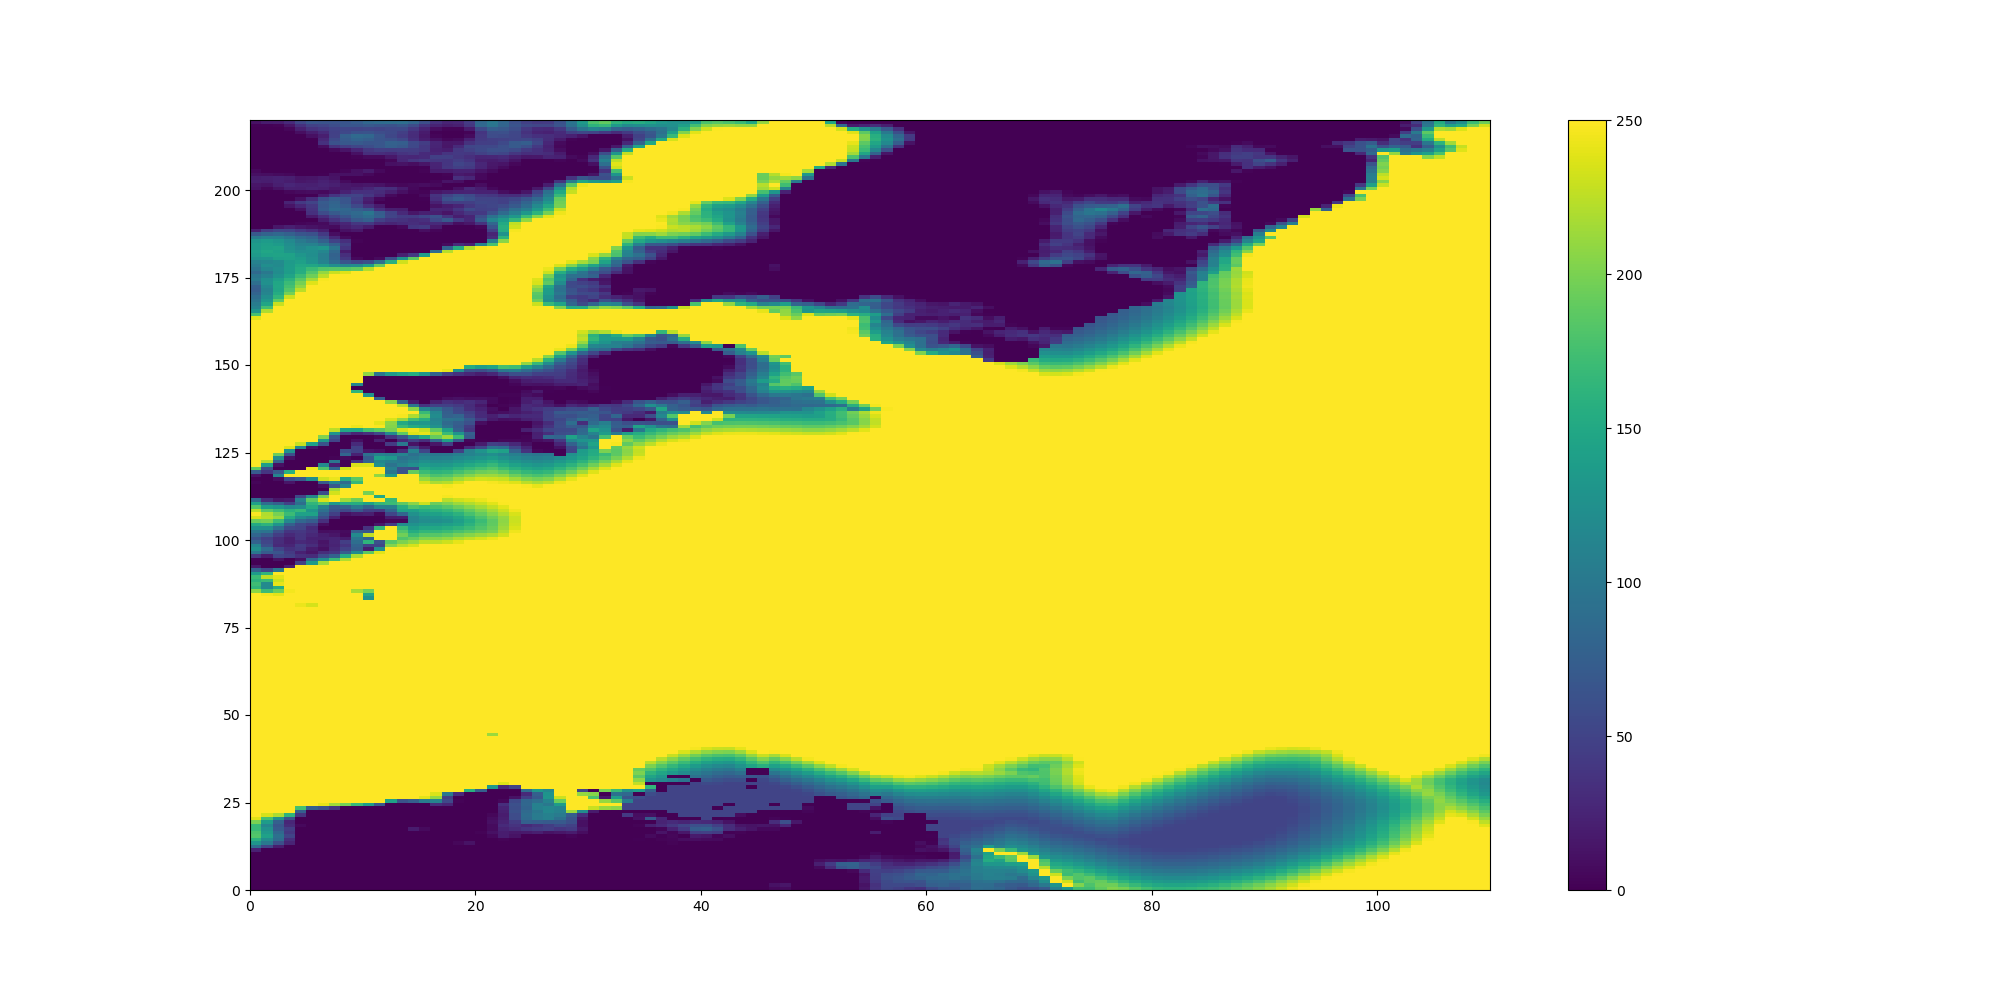

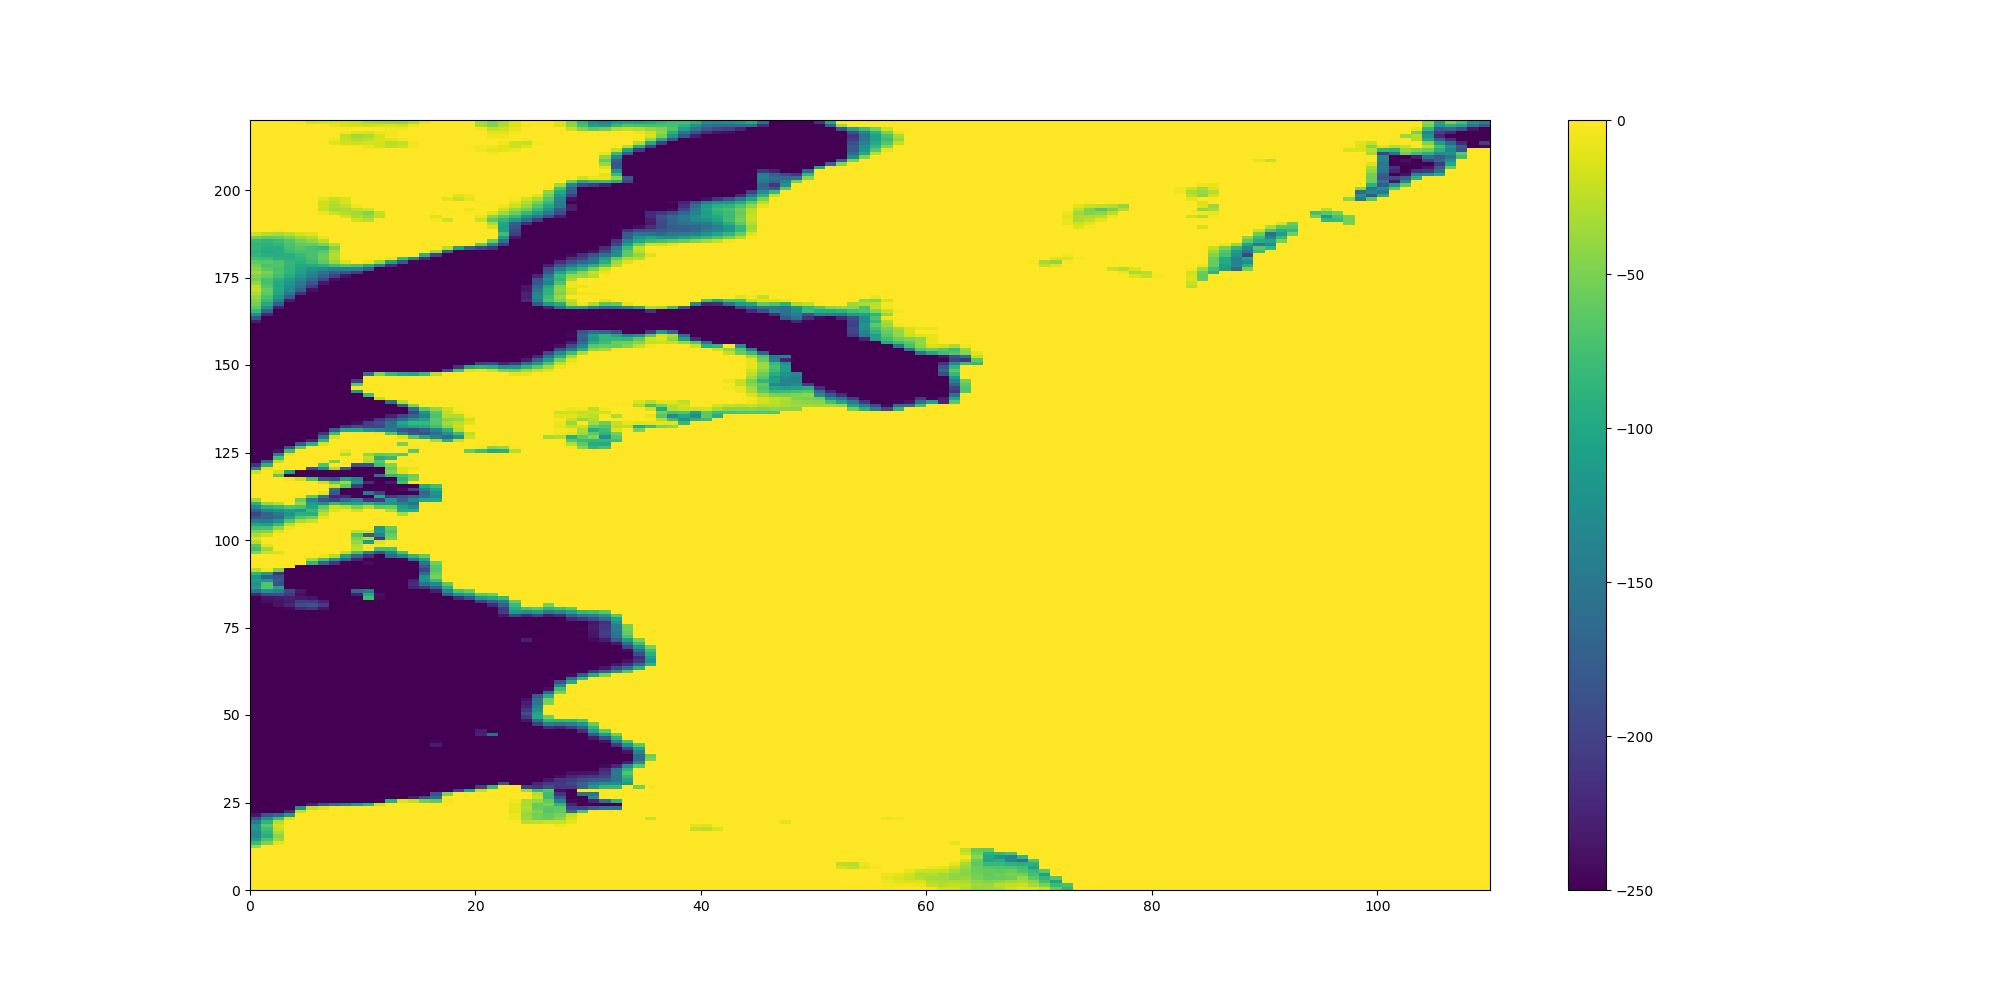

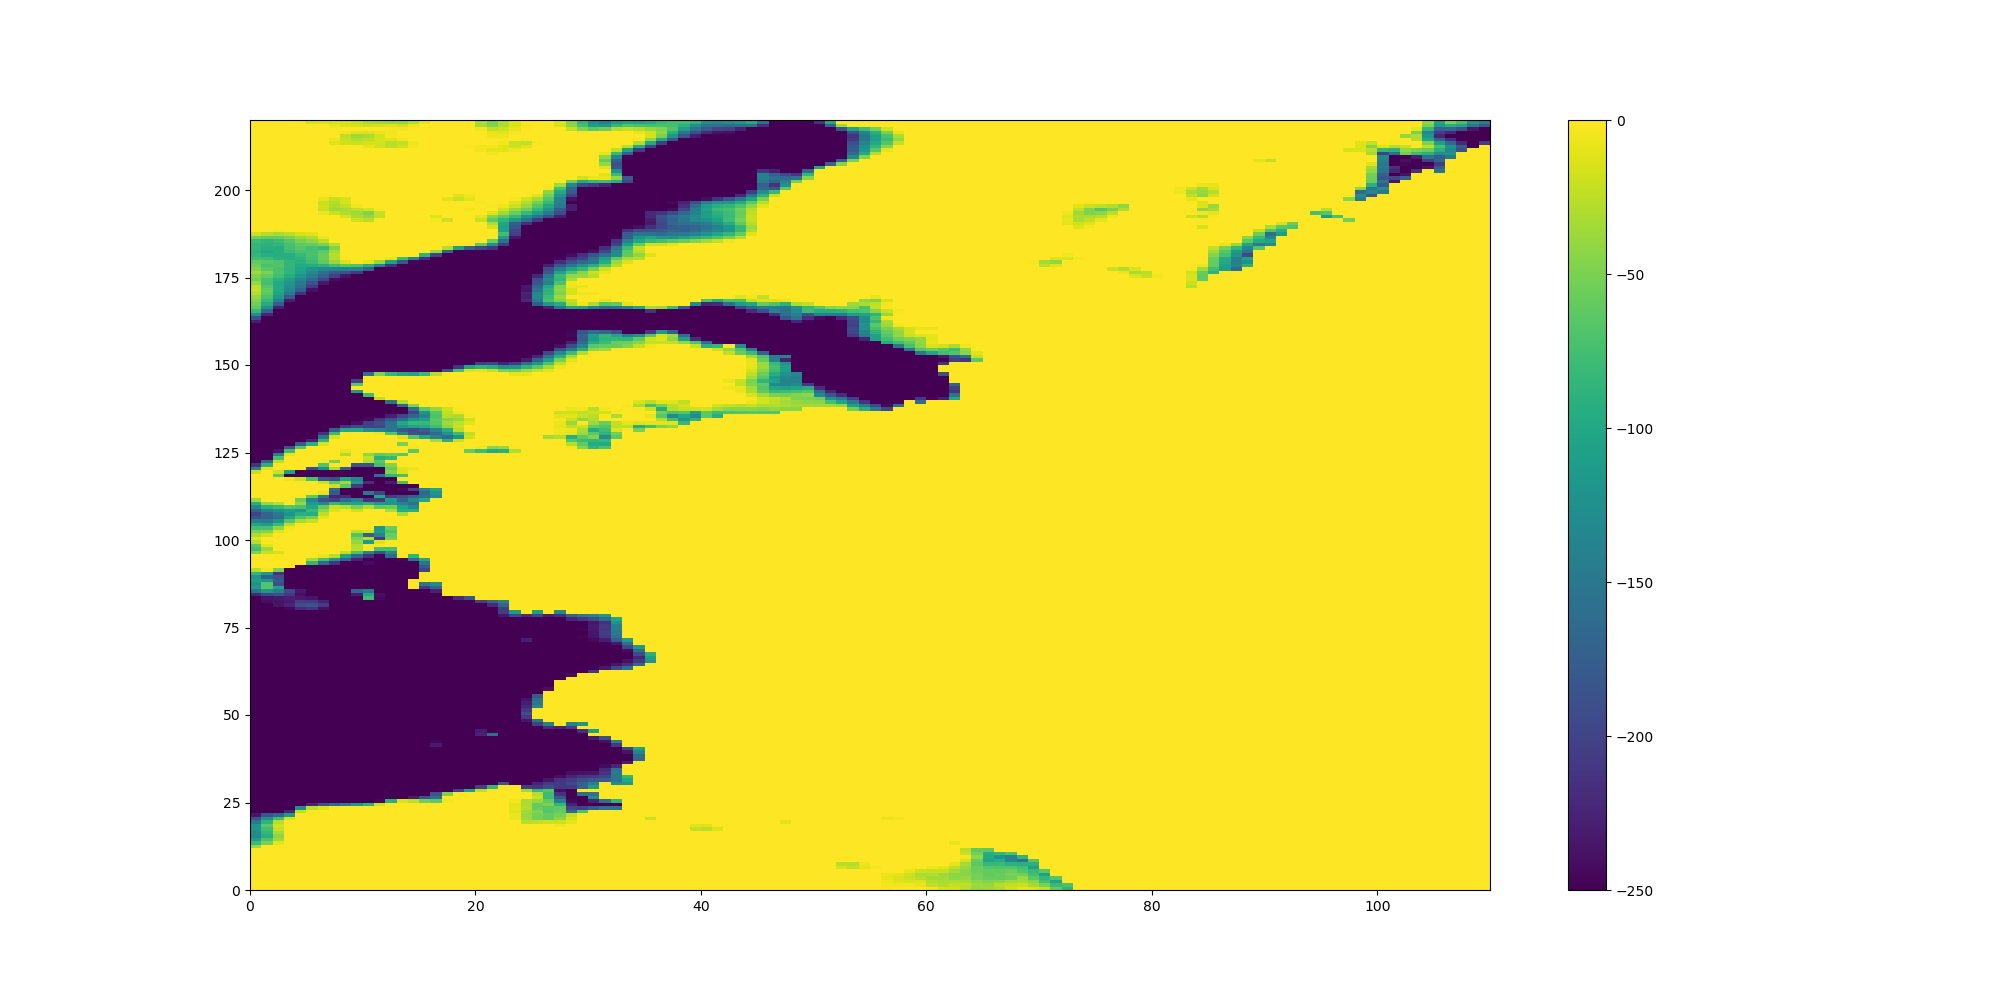

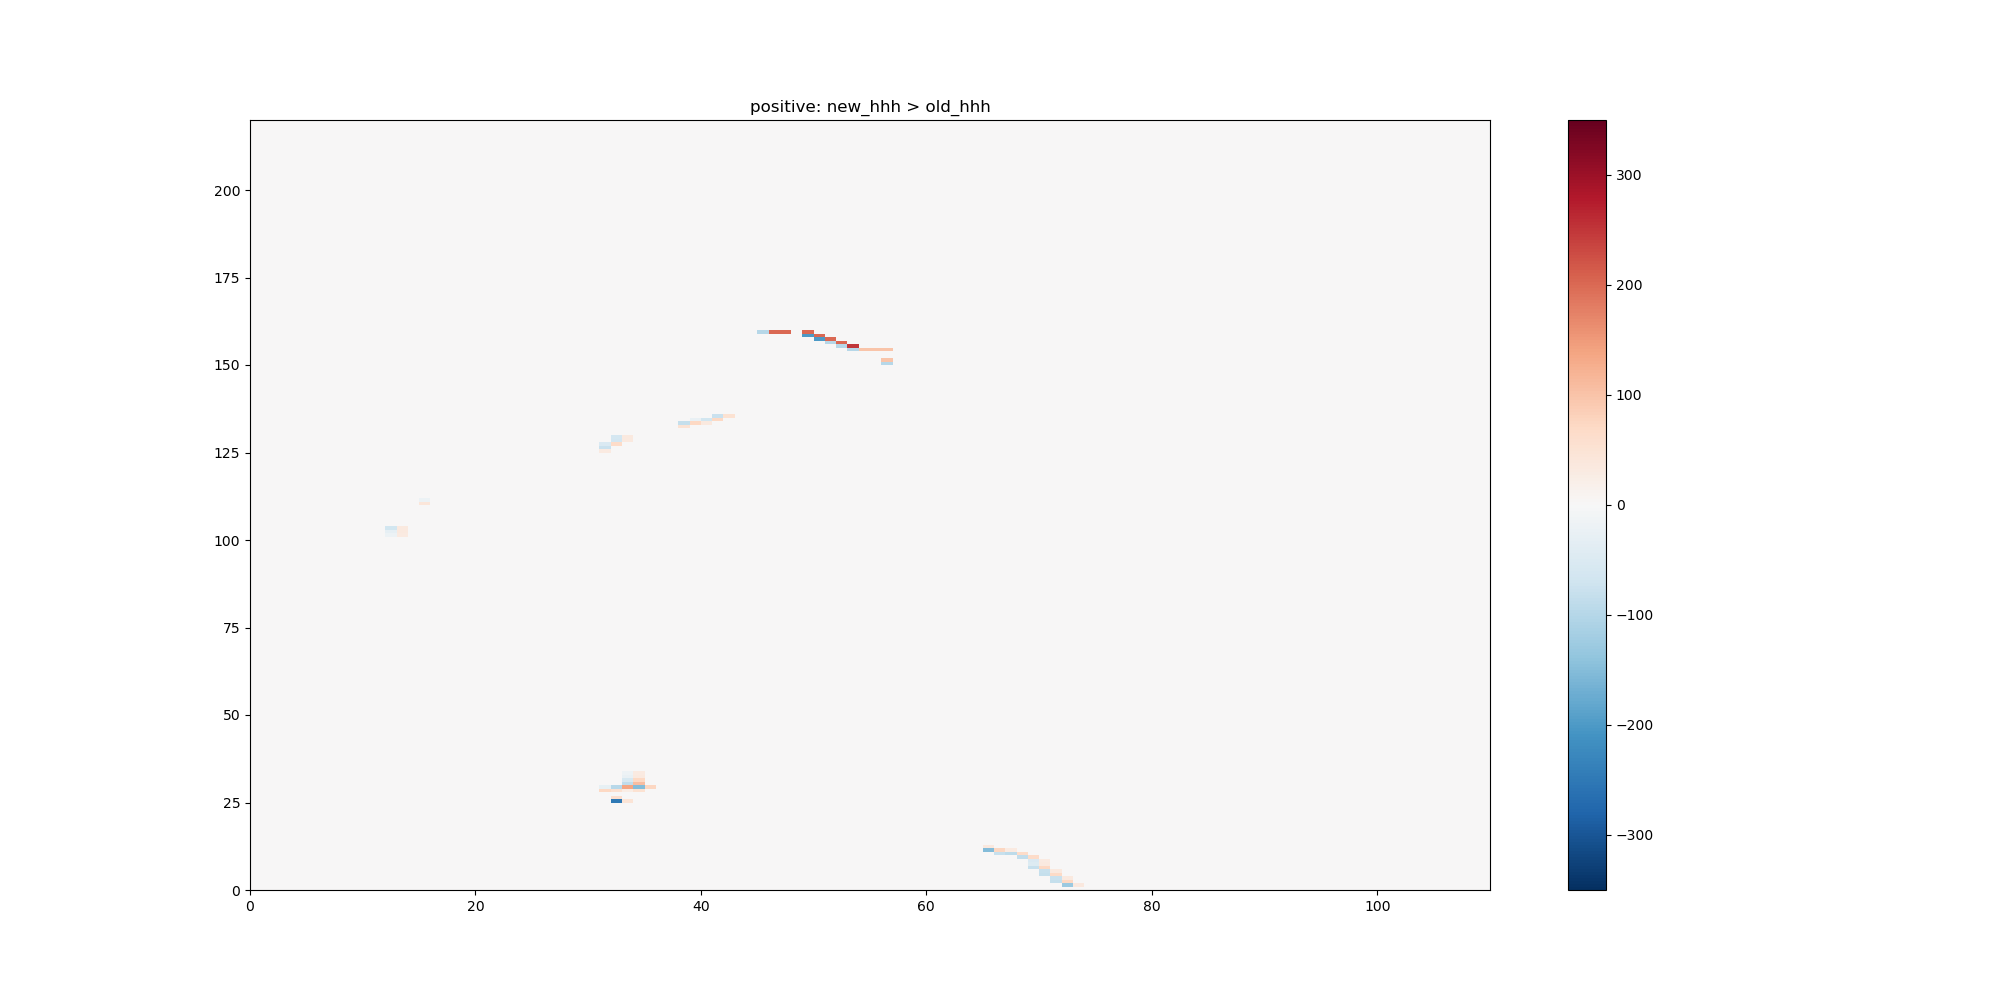

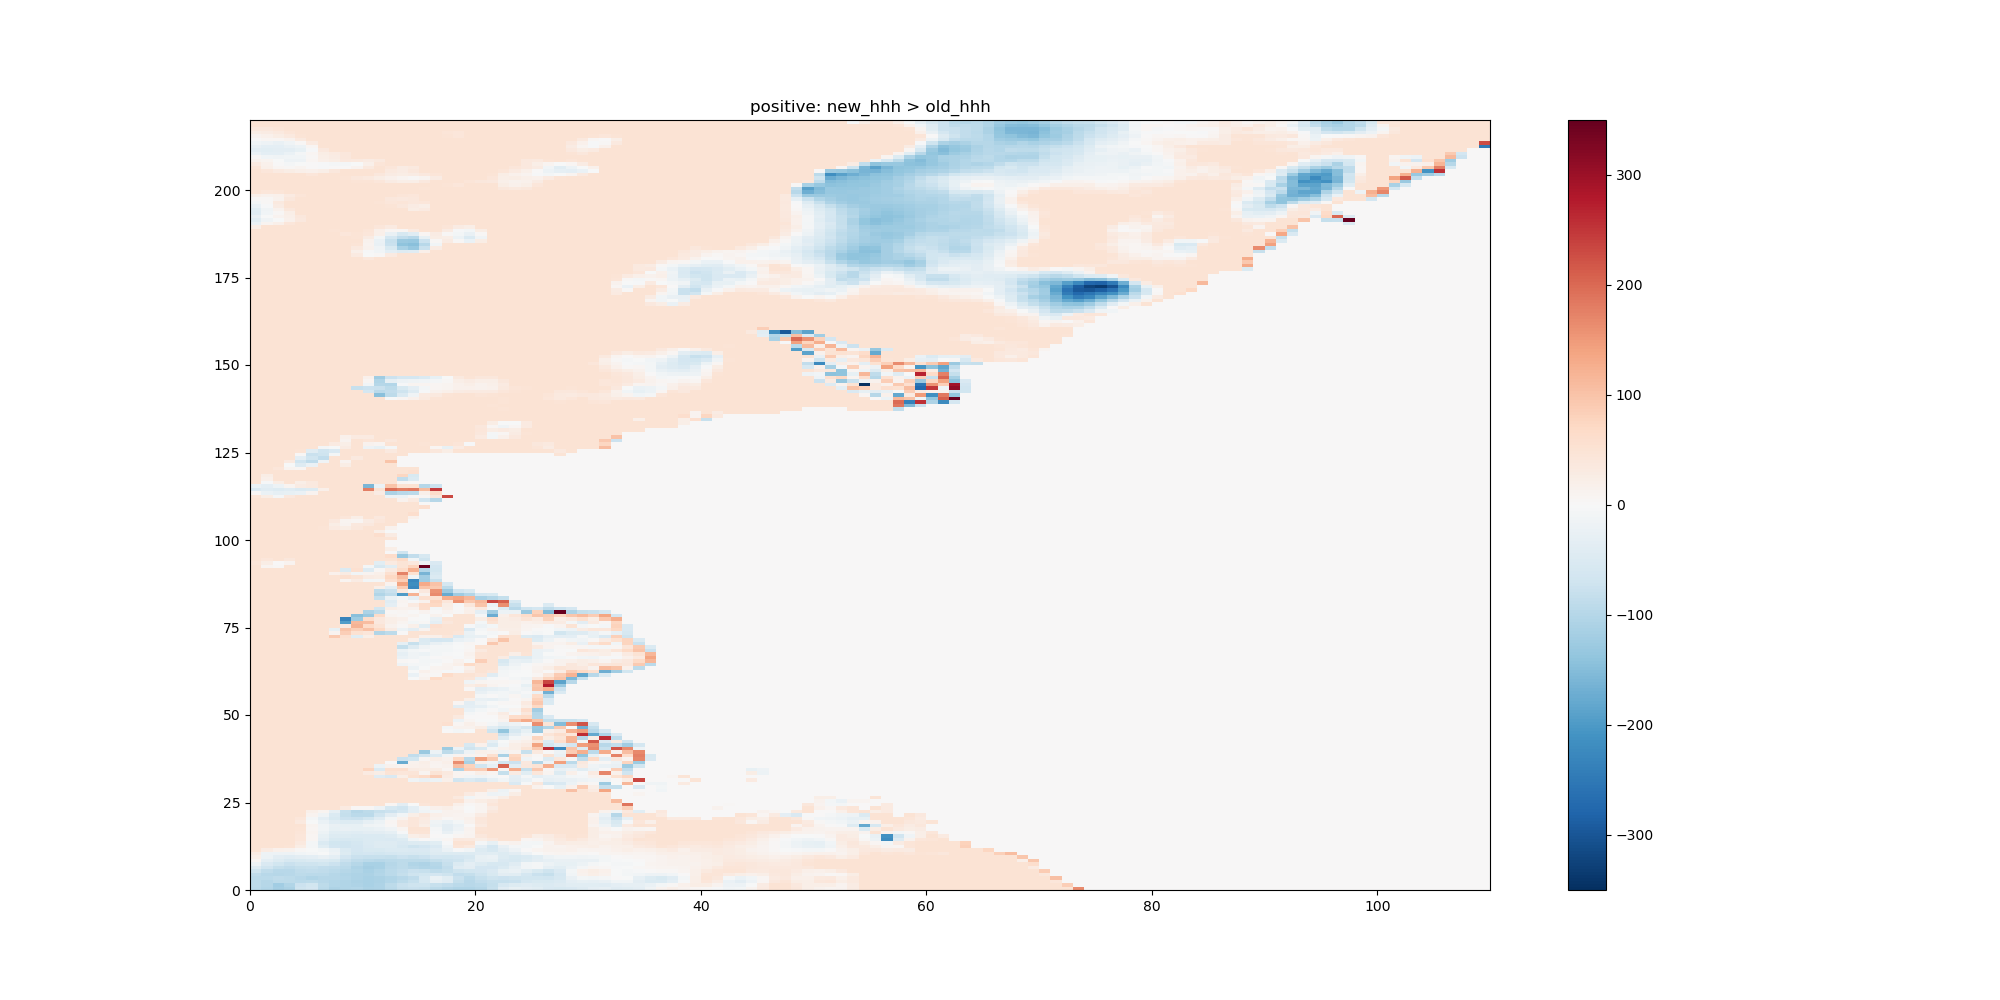

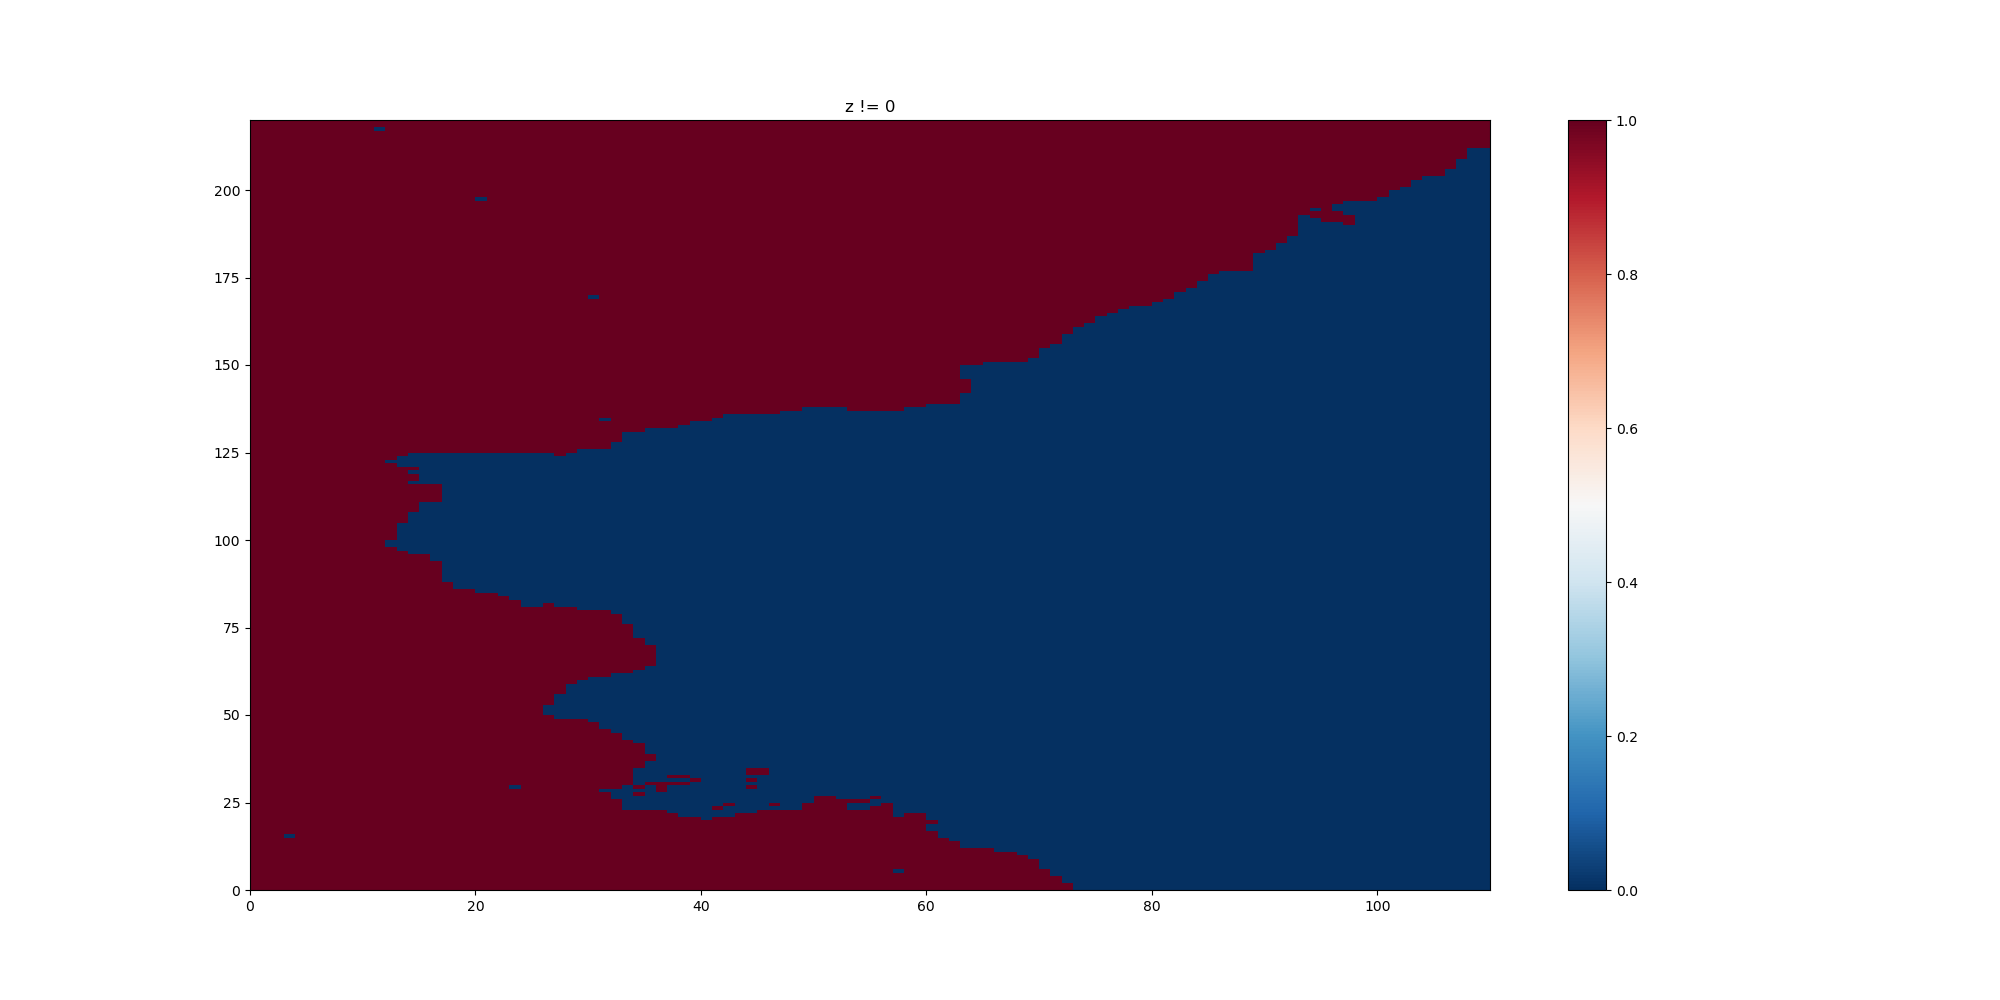

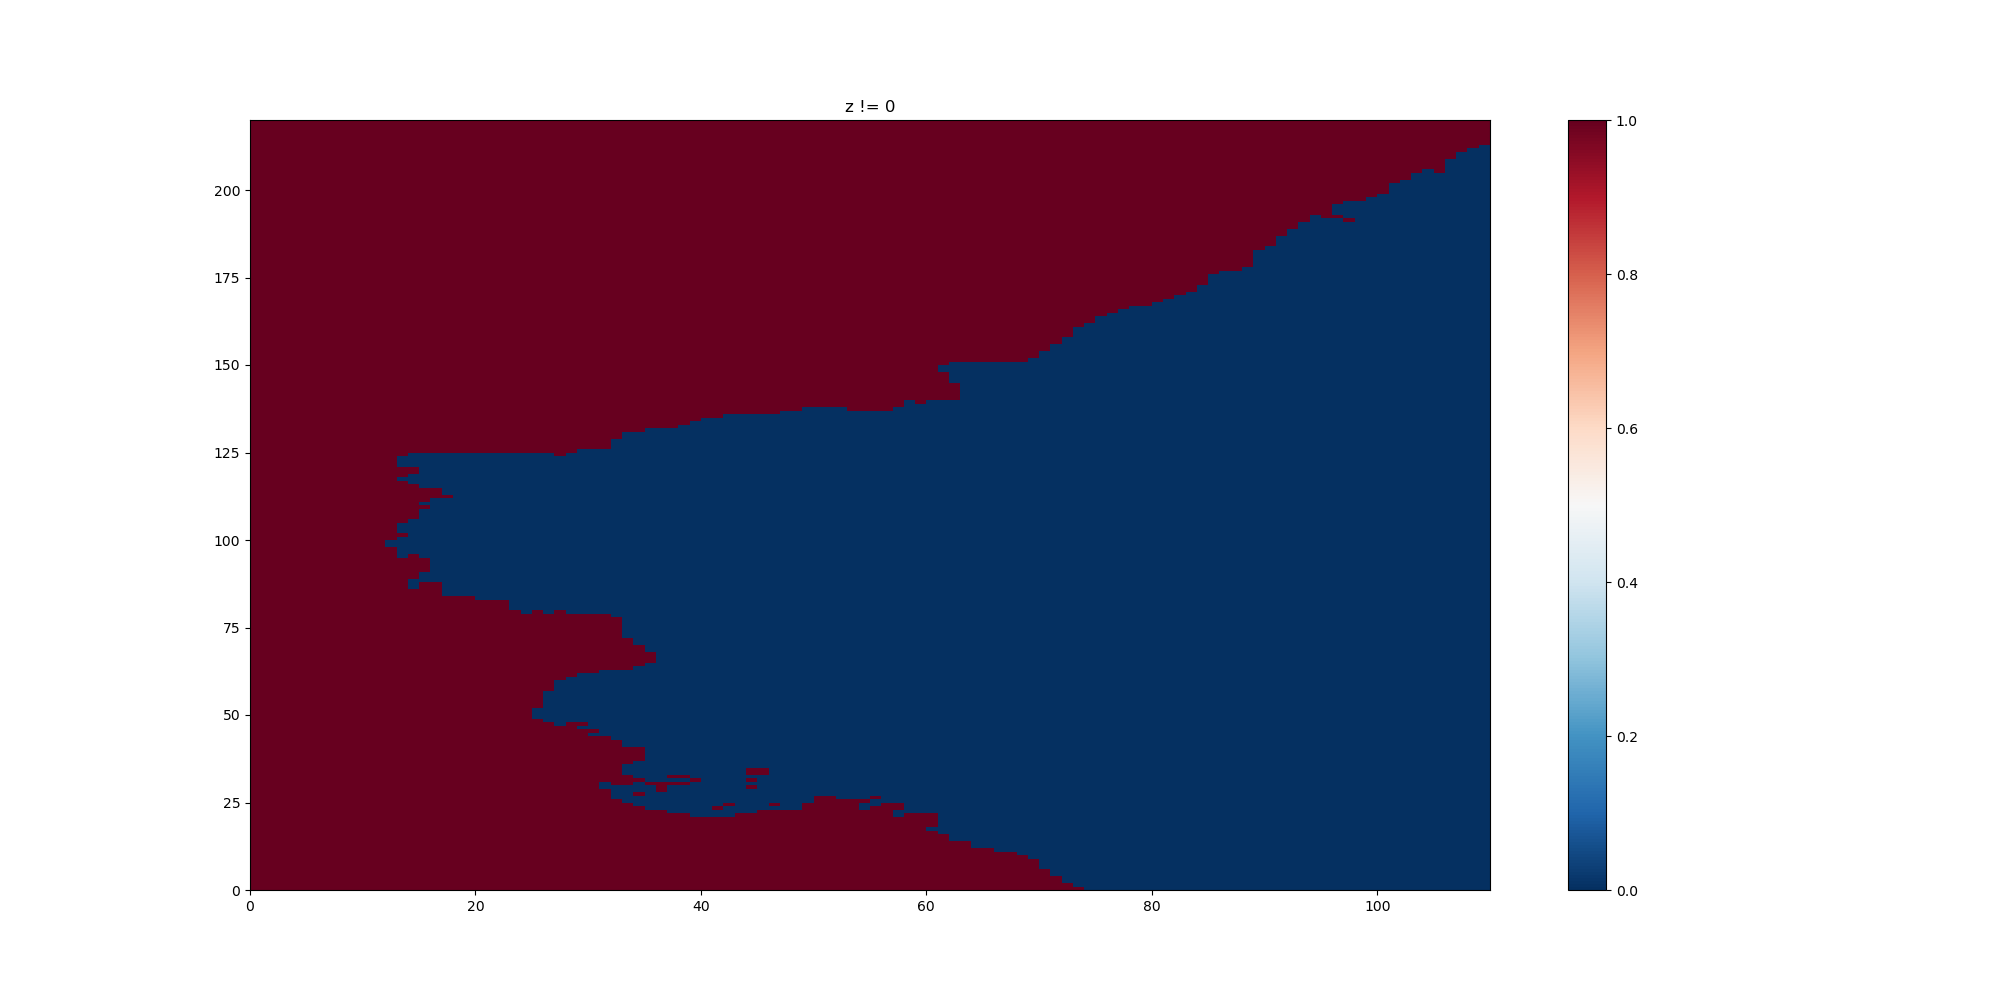

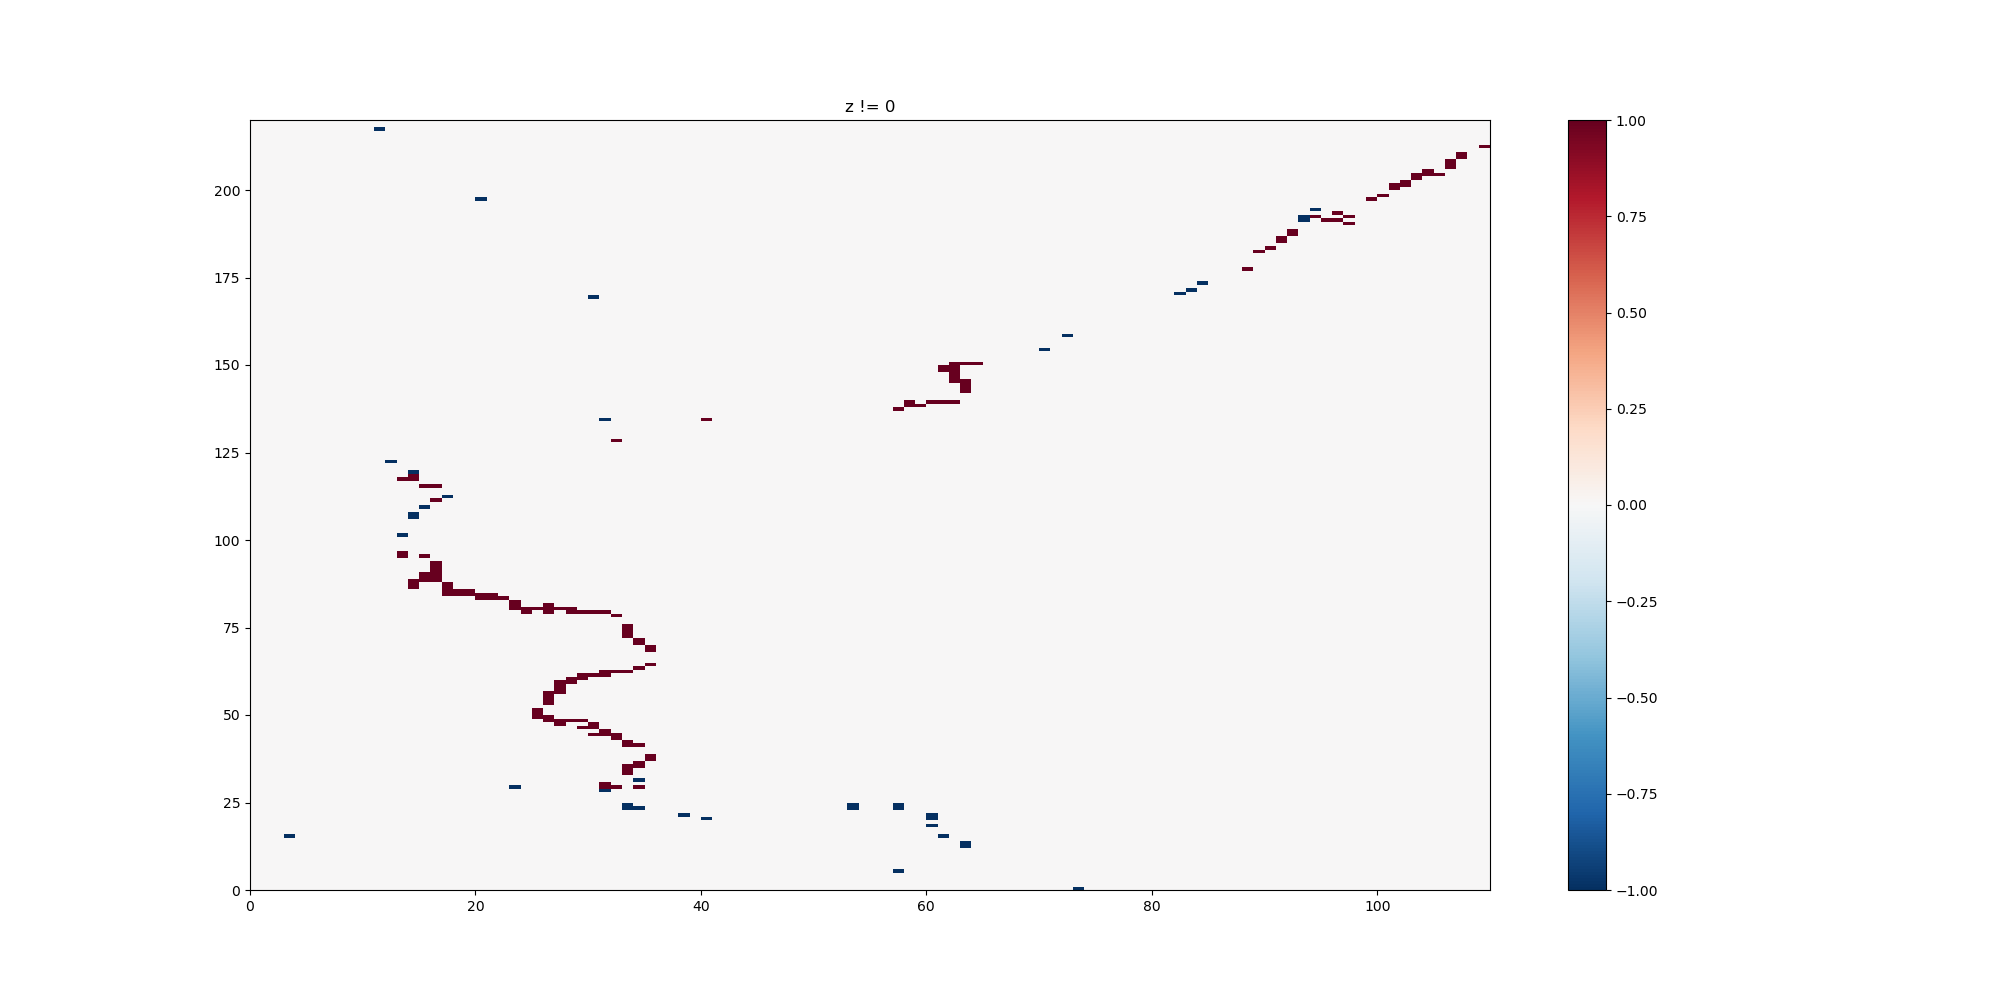

In [52]:
plt.close('all')

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(hhh,vmin=0,vmax=250)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(zzz,vmin=-250,vmax=0)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(zzz*(mask_openocean==0),vmin=-250,vmax=0)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(hhh-roms_tmp['bed'],vmin=-350,vmax=350,cmap='RdBu_r')
plt.title('positive: new_hhh > old_hhh')
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(zzz-roms_tmp['draft'],vmin=-350,vmax=350,cmap='RdBu_r')
plt.title('positive: new_hhh > old_hhh')
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(zzz!=0,cmap='RdBu_r')
plt.title('z != 0')
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(roms_tmp['draft']!=0,cmap='RdBu_r')
plt.title('z != 0')
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh((zzz!=0)*1-(roms_tmp['draft']!=0)*1,cmap='RdBu_r')
plt.title('z != 0')
plt.colorbar()

In [53]:
# Remove single cell water "lakes"


from contextlib import suppress

def compare_neighbors(arr):
# # test example:
# arr = np.array([[False, False, False, False, False, False],
#                 [False, True, False, True, False, False],
#                 [False, False, False, False, True, False],
#                 [True, False, False, True, True, False],
#                 [False, True, True, True, False, False],
#                 [False, True, False, True, False, False],
#                 [False, True, True, True, False, False]])

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # print(x,y)
        # print(x,y,arr.shape[0],arr.shape[1])
        # print((x<arr.shape[0]) & (y<arr.shape[1]))
        if (x>0) & (y>0) & (x<arr.shape[0]-1) & (y<arr.shape[1]-1):
            # print(x,y)
            if (arr[x-1, y] != item) & (arr[x+1, y] != item) & (arr[x, y+1] != item) & (arr[x, y-1] != item):
                if (arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item):
                    comp_arr[x, y] = True # Isolated cells are set to True
                if ((arr[x-1, y-1] == item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] == item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] == item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] == item)):
                    comp_arr[x, y] = True # find diagonal single cells
    return comp_arr


islands = compare_neighbors(mmm)

mmm_noSS = mmm.copy()

islandBehaviour = 'keep_islands' #'keep_islands' or 'remove_islands'
if islandBehaviour=='remove_islands':
    mmm_noSS[islands] = np.logical_not(mmm_noSS[islands]) # flip sign on only the islands
elif islandBehaviour=='keep_islands':
    mmm_noSS[islands] = np.full(mmm_noSS[islands].shape,False) # flip sign on only the islands



mmm = mmm_noSS

No such comm: c3243f0ef98f4cb496312eeb2998cacf


  
Minimum r-value =  0.0
Maximum r-value =  0.39843641615210545
Mean    r-value =  0.017696626539818346
Median  r-value =  0.0060108249201510176


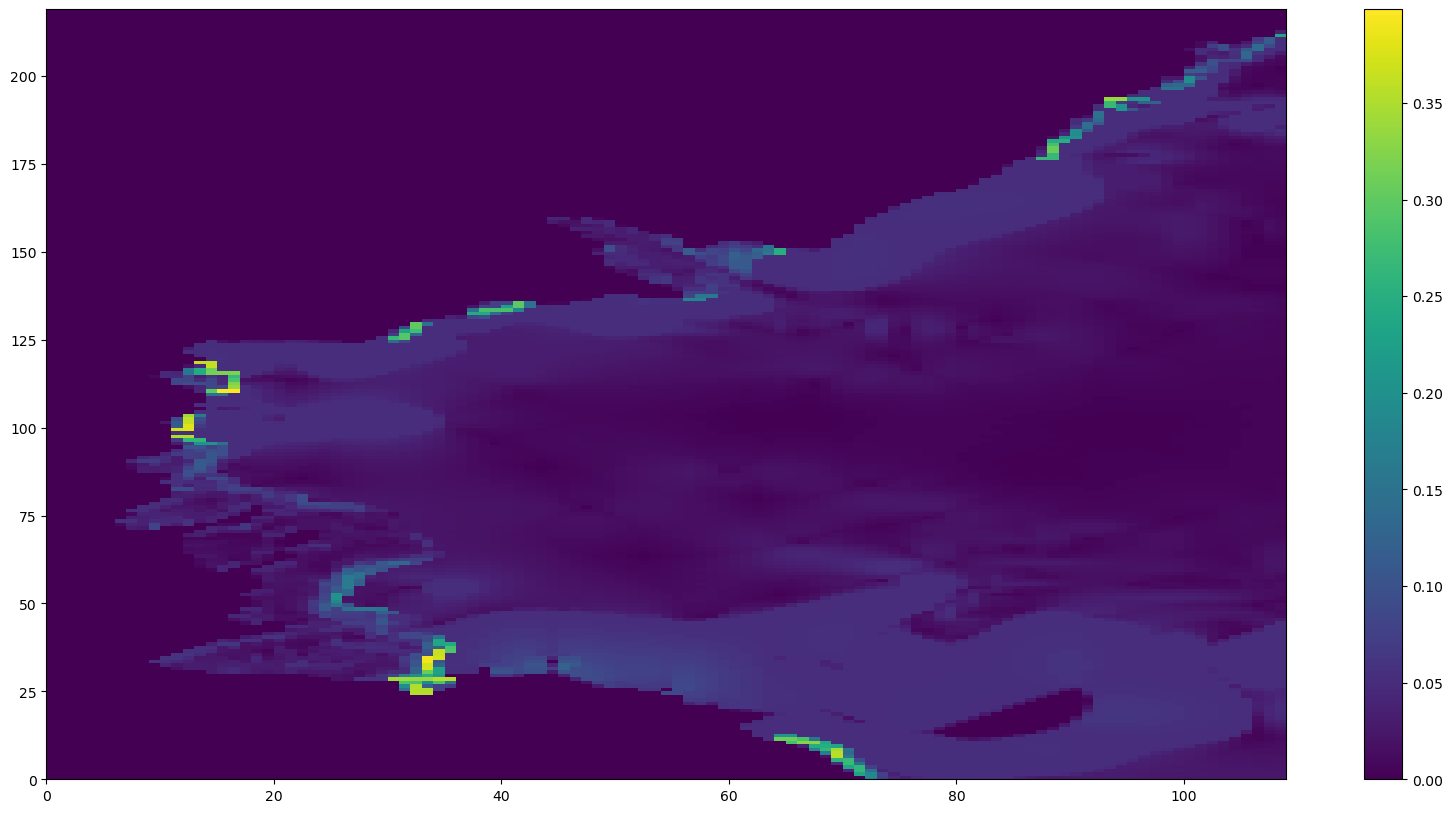

  
Minimum r-value =  0.0
Maximum r-value =  58.761145955688434
Mean    r-value =  1.2767674152831667
Median  r-value =  0.14777510707311825


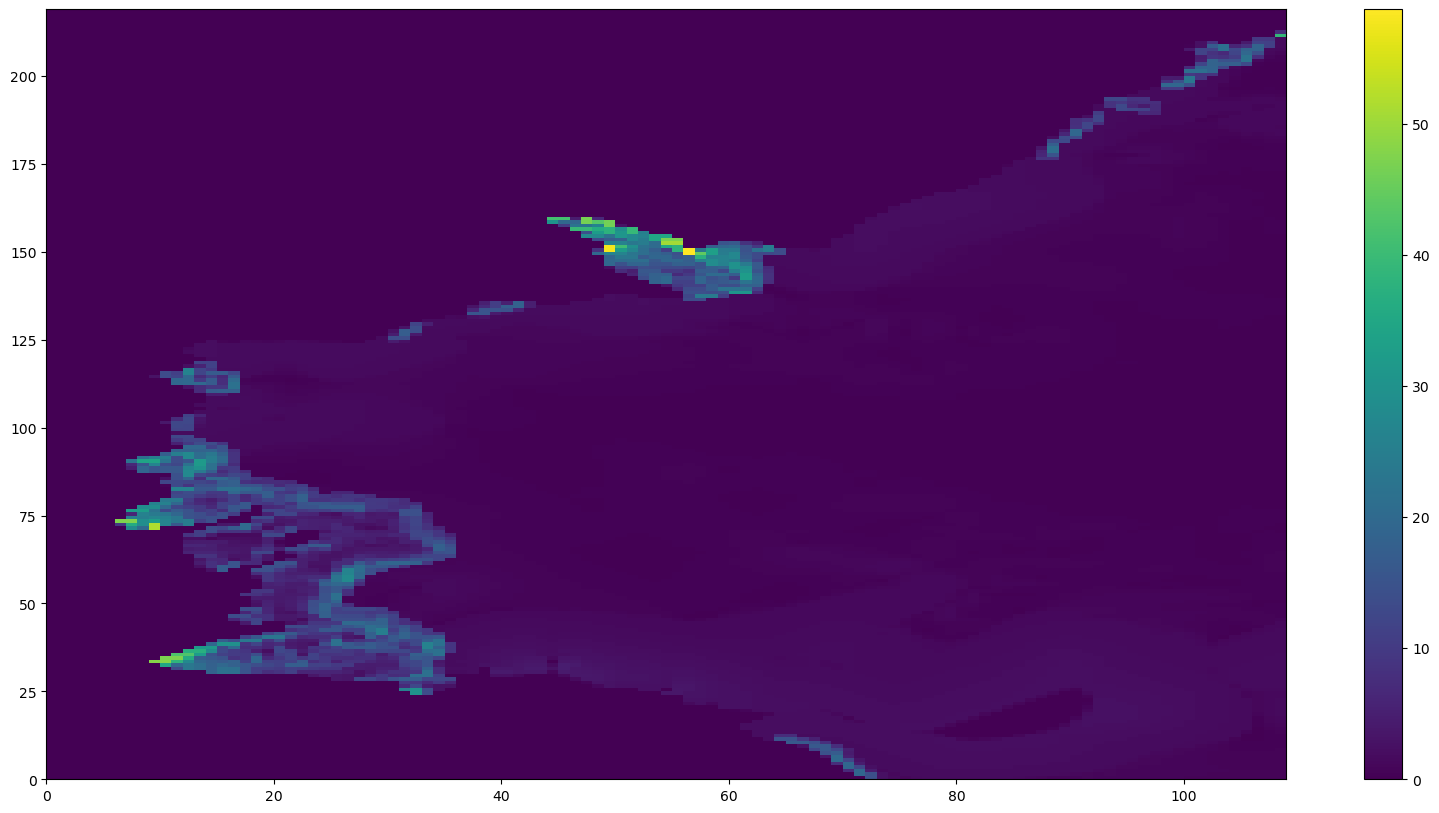

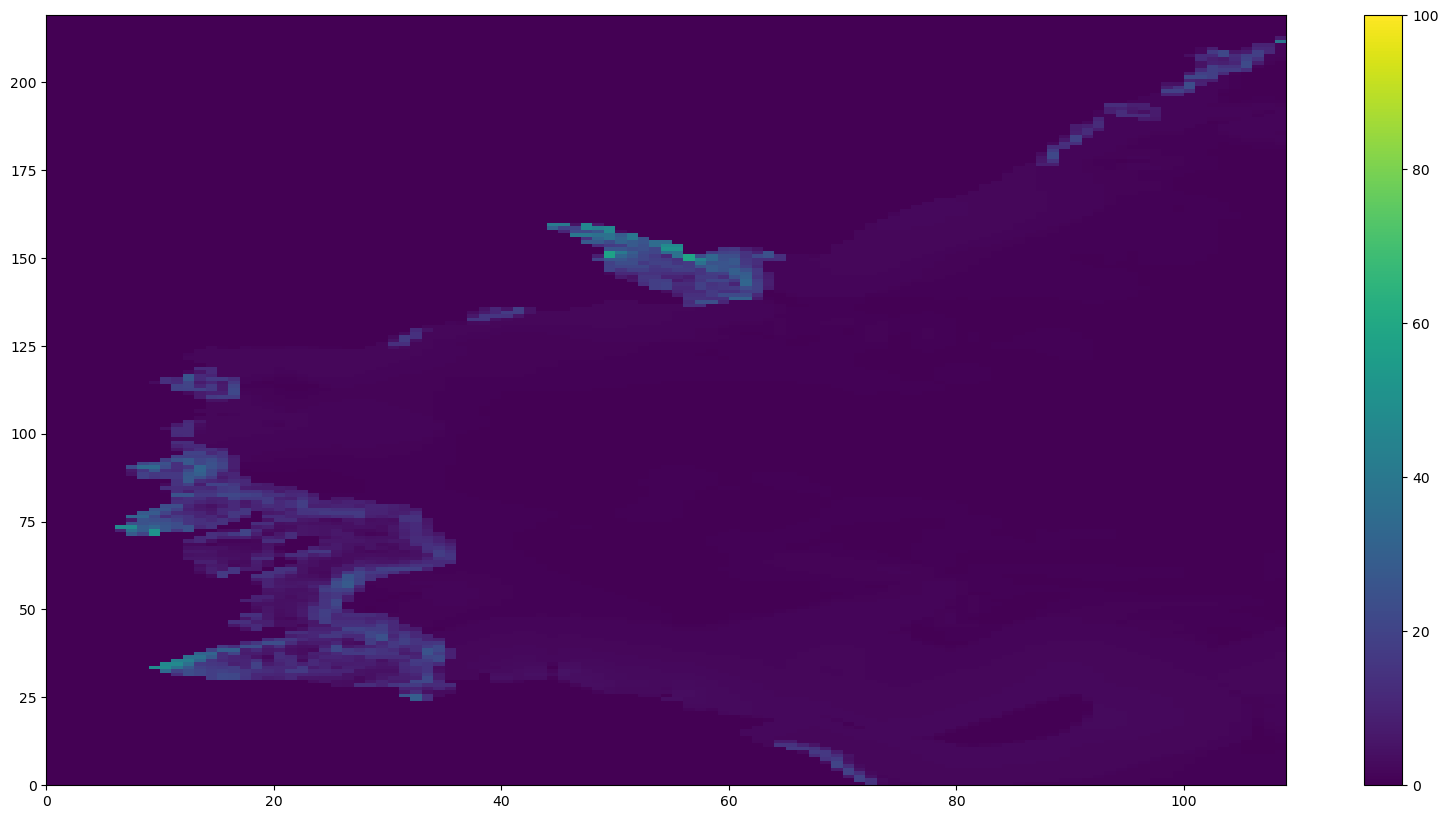

In [54]:
# Now check post-manual editing rx values

%matplotlib inline

z_rho_postManualEdits,z_w_postManualEdits,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
plt.close('all')
fig = plt.figure(figsize=(20,10))
grd_rx0_postManualEdits=GridStiffness.rx0(hhh,mmm)
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_postManualEdits=GridStiffness.rx1(z_w_postManualEdits,mmm)
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_postManualEdits,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [55]:
# interannual_coverage_cutoff = 0.5 # Interannual persistence: at least this fractional% required over 2000-2018 monthly climatology to be considered as ice.
# annual_coverage_cutoff = 0.9 # Annual persistence: at least this fractional % required over the year to be considered as ice

# filelist= glob.glob(data_dir+'/raw/adf_fastice/'+'FastIce*.nc')
# for file in filelist:
#     fi_singlefile = xr.open_dataset(filelist)
#     fi_full = fi_singlefile.drop(['x','y','area','date_alt'])

#     # make the fast ice mask data array
#     fi = (fi_full.Fast_Ice_Time_series==4) | (fi_full.Fast_Ice_Time_series==5) | (fi_full.Fast_Ice_Time_series==6)
    
#     # # check that i'm adding all the required fields
#     # (((fi - fi_full.Fast_Ice_Time_series==4) - fi_full.Fast_Ice_Time_series==5) - fi_full.Fast_Ice_Time_series==6).isel(time=10).plot()


#     fi_clima = fi.groupby('time.month').mean() #make the monthly climatology
#     # # check that the mean is working
#     # (fi.groupby('time.month').mean()>0.5).isel(month=2).plot()
#     # plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')
#     # plt.show()
#     # (fi.groupby('time.month').mean()).isel(month=2).plot()
#     # plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')


#     fi_mean_interannual = (fi_clima>=interannual_coverage_cutoff).mean(dim='month')

#     fi_mean_annual = fi_mean_interannual>=annual_coverage_cutoff

No such comm: b8a79810af7c41c8afc6cd311614e225


No such comm: 2bdc32dd2b4744c0b8b7fb3a2084d84a


No such comm: 97eb2ffbc9944da2a51a1a6adb4ff662


No such comm: 870ffb09d3304ca3ac26a5ca73367660


No such comm: 4e97d0b8c1f444d69a6ba75c58978ec7


No such comm: 4f6fed7cd73e43f9a4de240dd50aa736


No such comm: 86d375a0a1594a5e8bb07c29b2af533b


In [56]:
# add fast ice

# fi_fulldata = xr.open_mfdataset(data_dir+'/raw/adf_fastice/'+'*.nc') # load full fast ice data set
fi_fulldata = xr.open_mfdataset(data_dir+'/raw/adf_fastice/'+'FastIce_70_200[0-2].nc',data_vars='different') # load full fast ice data set, don't concat similar datavars (e.g. lon)

fi_full = fi_fulldata.drop(['x','y','area','date_alt'])
# fi_full = fi_full_coordCorrected

fi_full.nbytes/1e9

2.009250544

In [57]:
fi_full

<xarray.Dataset>
Dimensions:               (Y: 4700, X: 5625, time: 68)
Coordinates:
  * time                  (time) datetime64[ns] 2000-03-01 ... 2002-12-12
Dimensions without coordinates: Y, X
Data variables:
    latitude              (Y, X) float32 dask.array<chunksize=(4700, 5625), meta=np.ndarray>
    longitude             (Y, X) float32 dask.array<chunksize=(4700, 5625), meta=np.ndarray>
    Fast_Ice_Time_series  (time, Y, X) int8 dask.array<chunksize=(20, 4700, 5625), meta=np.ndarray>
Attributes:
    title:        Fast ice time series
    institution:  Institute for Marine and Antarctic Studies, University of T...
    source:       MODIS 15-day composite images and automated edge detection
    history:      Version 2.2
    references:   Fraser et al., 2020 (Earth System Science Data, submitted)
    comment:      This is the lat_ts=-70 version of the data - year 2000
    contact:      Alex Fraser (adfraser@utas.edu.au)
    Conventions:  CF-1.7

In [58]:
interannual_coverage_cutoff = 0.5 # Interannual persistence: at least this fractional% required over 2000-2018 monthly climatology to be considered as ice.
annual_coverage_cutoff = 0.9 # Annual persistence: at least this fractional % required over the year to be considered as ice

fi = (fi_full.Fast_Ice_Time_series==4) | (fi_full.Fast_Ice_Time_series==5) | (fi_full.Fast_Ice_Time_series==6) # make the fast ice mask data array
# # check that i'm adding all the required fields
# (((fi - fi_full.Fast_Ice_Time_series==4) - fi_full.Fast_Ice_Time_series==5) - fi_full.Fast_Ice_Time_series==6).isel(time=10).plot()


fi_clima = fi.groupby('time.month').mean() #make the monthly climatology
# # check that the mean is working
# (fi.groupby('time.month').mean()>0.5).isel(month=2).plot()
# plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')
# plt.show()
# (fi.groupby('time.month').mean()).isel(month=2).plot()
# plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')


fi_mean_interannual = (fi_clima>=interannual_coverage_cutoff).mean(dim='month')

fi_mean_annual = fi_mean_interannual>=annual_coverage_cutoff




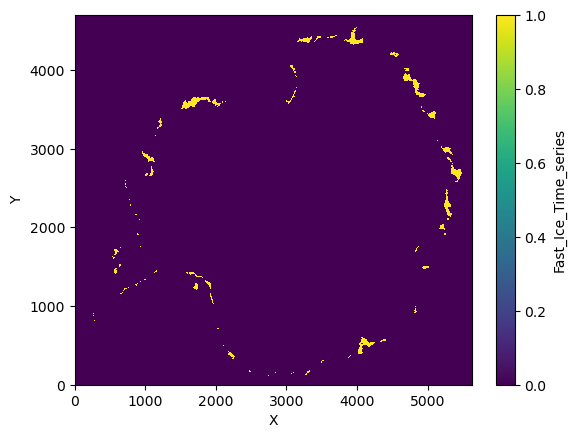

In [59]:
# now map the fast ice data to the model grid
fi_mean_annual.plot()

# interp (nearest) to the model lat/lon

fi_mean_annual_i = griddata((fi_full['longitude'].values.flatten(),fi_full['latitude'].values.flatten()),fi_mean_annual.values.flatten(),(lon_rho,lat_rho),'nearest')


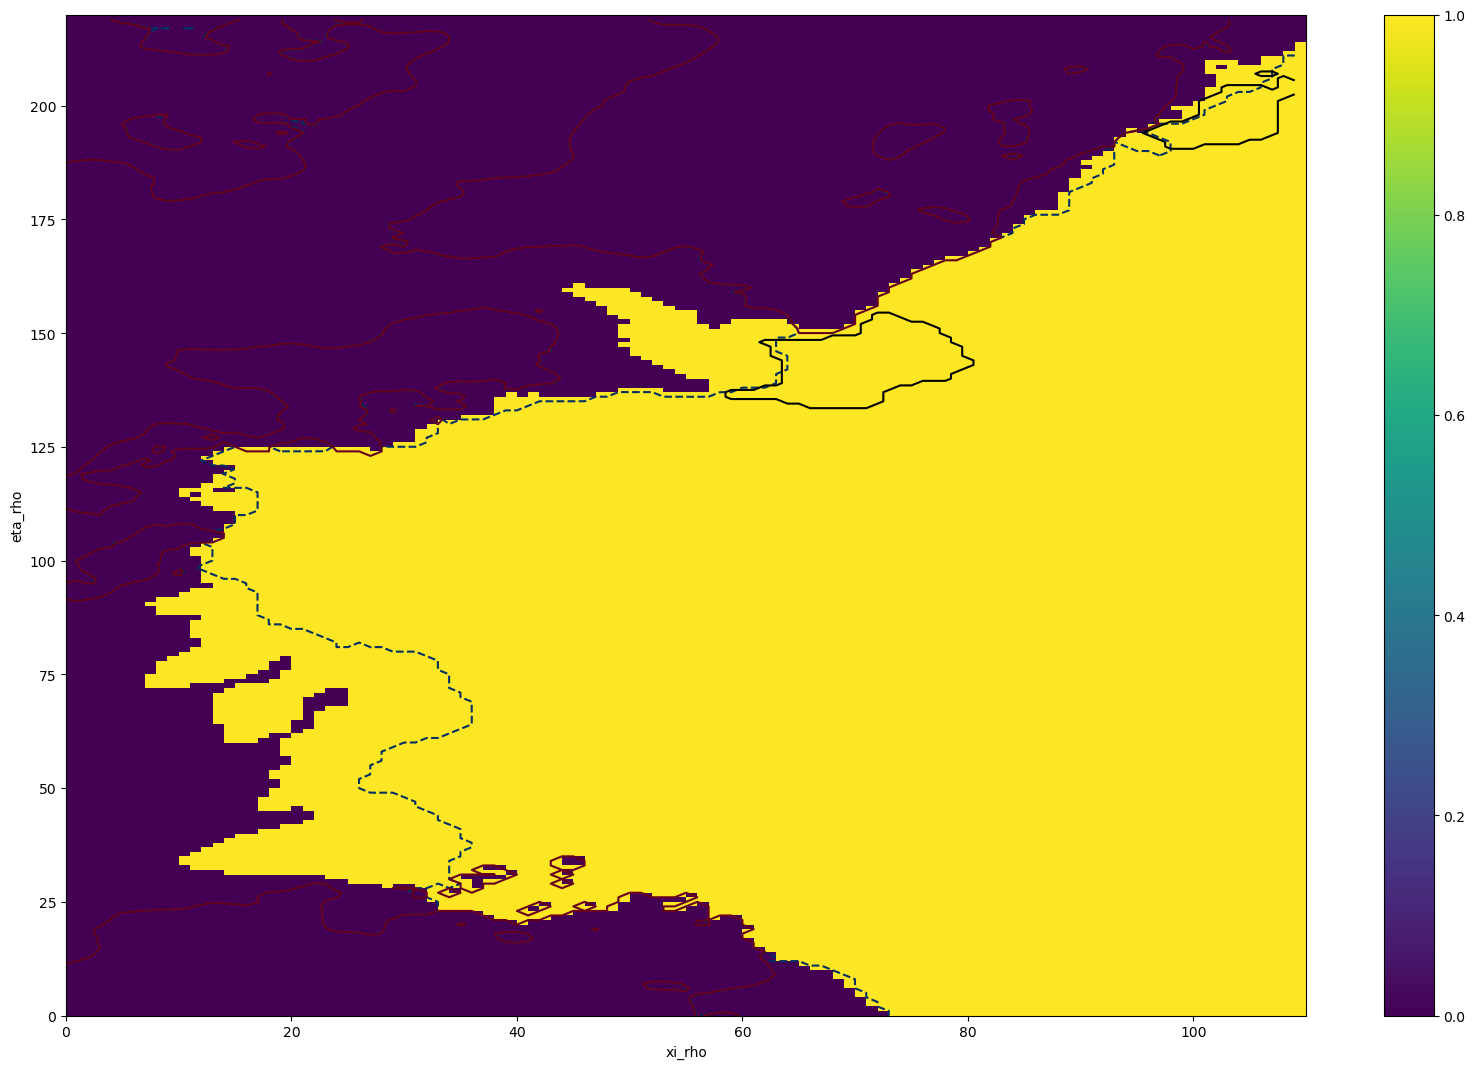

In [60]:

fig = plt.figure(figsize=(20,13))
plt.pcolormesh(mmm)
plt.colorbar()
zice_da = xr.DataArray(zzz,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})
zice_da.plot.contour(levels=[0,-1])
# plt.contour(zzz,levels=[-.5])

plt.contour(fi_mean_annual_i,colors='k')

In [61]:
# # add icebergs
# # download from https://apps.sentinel-hub.com/eo-browser/ (need log in)
# # download as a tif, georeferenced, high res, etc, Sentinel-1 AWS-EW-HHHV, HH-linear gamma0 - radiometric terrain, clip extra bands, note the coordinate system. e.g. WGS84 is EPSG:4326 
# import rioxarray

# S1b = rioxarray.open_rasterio('../data/raw/Sentinel/2023-05-01-00 00_2023-05-01-23 59_Sentinel-1_AWS-EW-HHHV_HH_-_linear_gamma0_-_radiometric_terrain_corrected.tiff')

# # import matplotlib
# # matplotlib.use('Qt5Agg')
# import matplotlib.pyplot as plt
# %matplotlib widget
# import mplcursors

# fig,ax=plt.subplots(figsize=(15,10))
# im = ax.pcolormesh(S1b.x,S1b.y,S1b.isel(band=0).values)
# cursor = mplcursors.cursor(im, hover=True)




In [62]:
# %matplotlib inline

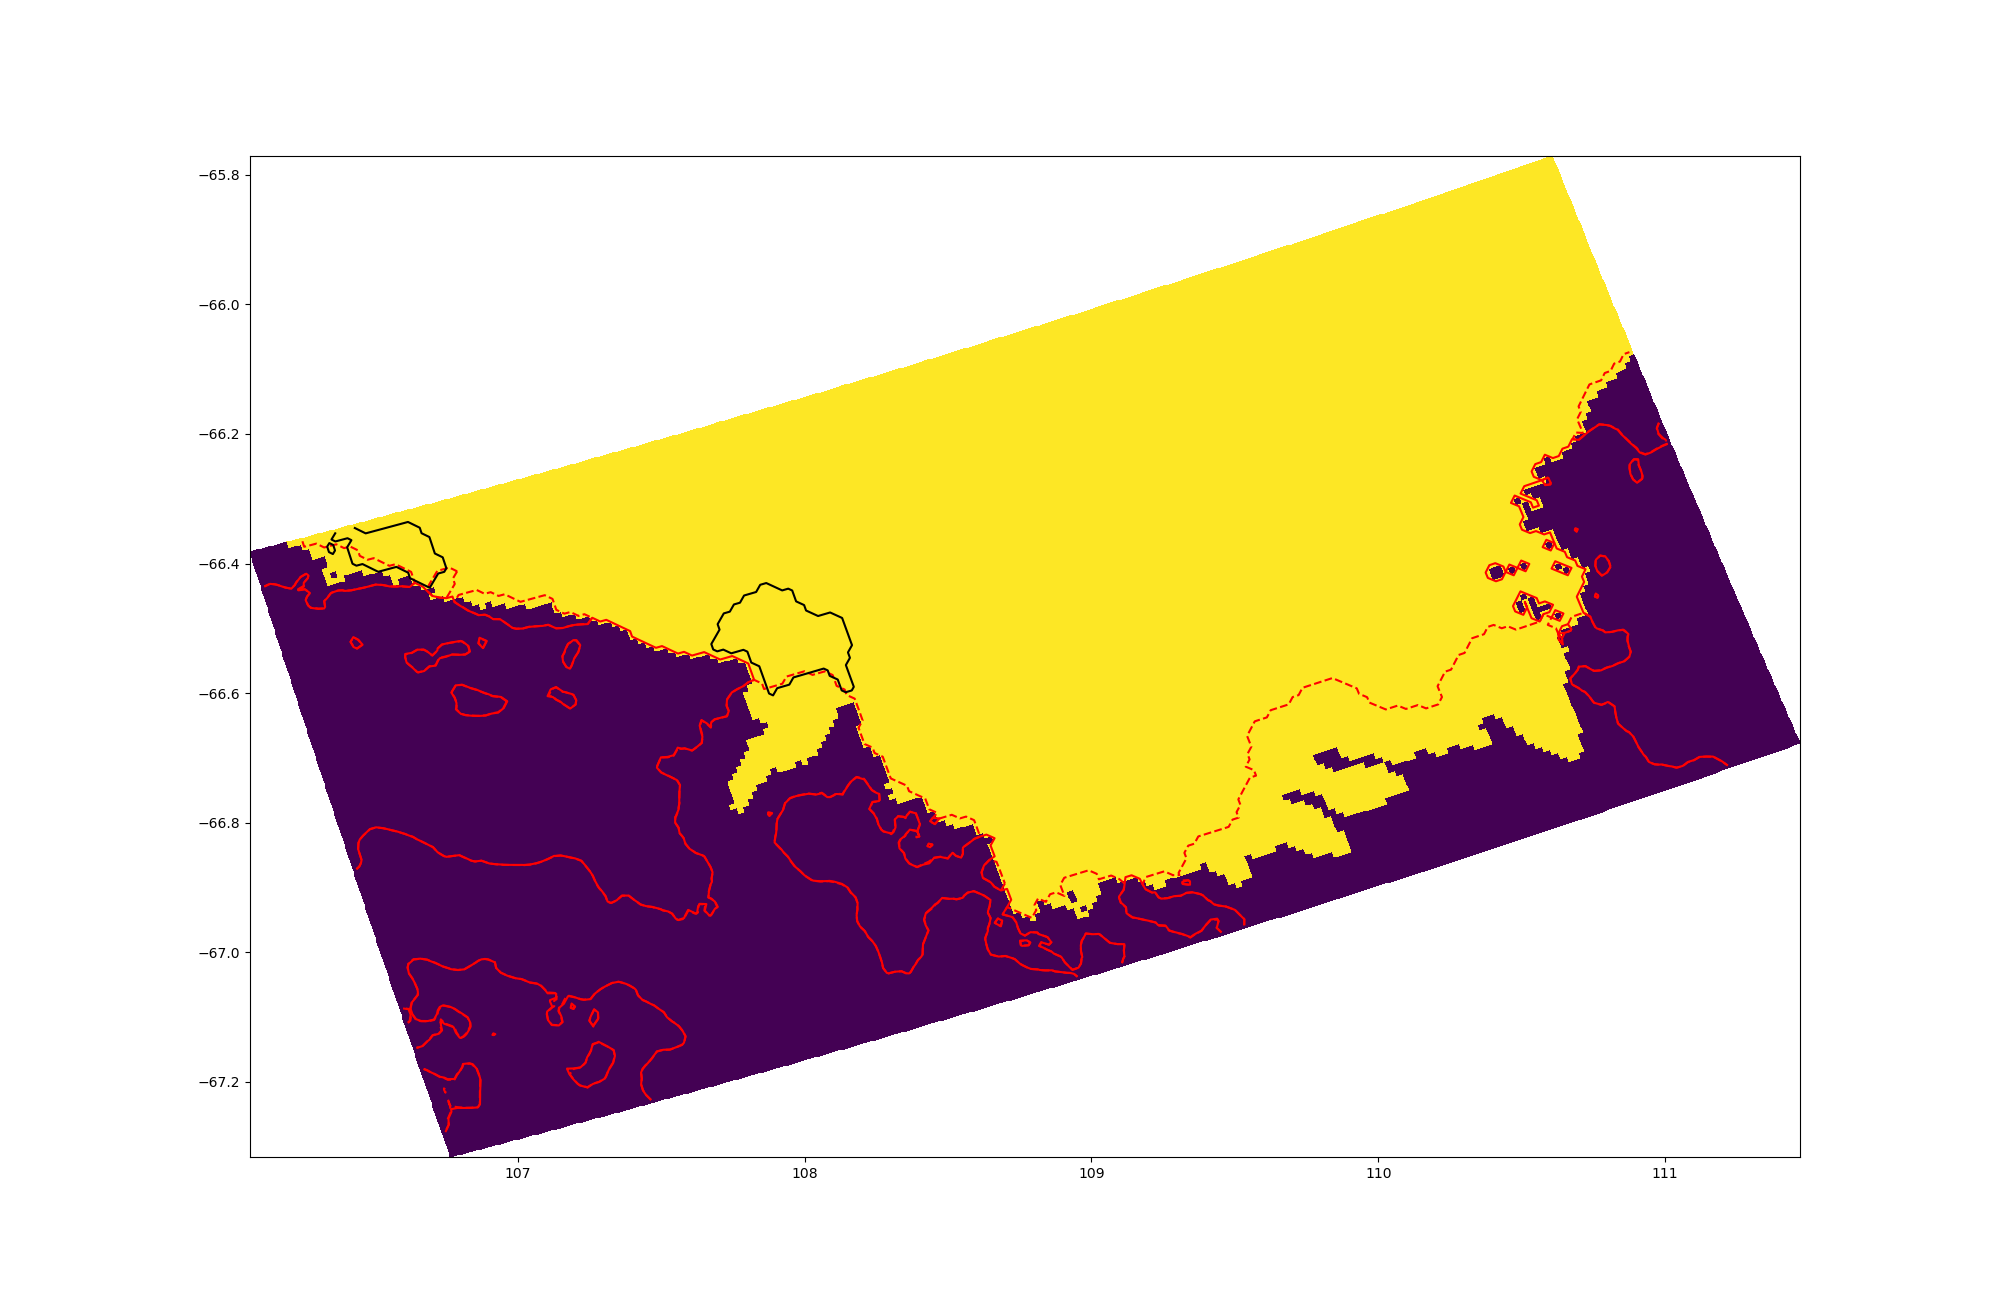

In [63]:
%matplotlib widget
fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,mmm)
plt.contour(lon_rho,lat_rho,zzz,levels=[-1,0],colors='r')

plt.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')



In [64]:
# manually add missing fast ice

# fig = plt.figure(figsize=(20,13))
# plt.pcolormesh(lon_rho,lat_rho,mmm)
# plt.contour(lon_rho,lat_rho,zzz,levels=[0,-1])

# plt.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')



add_fasticefill = np.array([
    [107.691,-66.621],
    [107.660,-66.552],
    [107.872,-66.608],
	[108.137,-66.608],
	[108.127,-66.564],
    [107.925,-66.506],
    [107.705,-66.516]
])



def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


mask_fasticefill = inpolygon(lon_rho, lat_rho,add_fasticefill[:,0], add_fasticefill[:,1])


In [65]:
# #define outline of icebergs (manually until vscode/jupyter can use plt.ginput())

# d12=np.array([
# [81.89,-66.246],
# [82.07,-66.309],
# [82.11,-66.396],
# [82.24,-66.469],
# [82.23,-66.513],
# [82.42,-66.576],
# [82.52,-66.746],
# [82.56,-66.906],
# [82.58,-67.023],
# [82.42,-67.047],
# [82.49,-67.071],
# # [82.19,-67.091],
# [82.33,-67.11],
# [81.79,-67.173],
# [81.45,-67.100],
# [81.79,-67.178],
# [81.40,-67.086],
# [81.36,-66.989],
# [81.22,-66.935],
# [81.29,-66.887],
# [81.14,-66.824],
# [81.05,-66.726],
# [81.14,-66.707],
# [81.32,-66.697],
# [81.35,-66.615],
# [81.37,-66.552],
# [81.26,-66.522],
# [81.30,-66.484],
# [81.24,-66.435],
# [81.25,-66.372],
# [81.20,-66.343],
# [81.40,-66.270 ]
# ])


# def inpolygon(xq, yq, xv, yv):
#     from matplotlib import path
#     shape = xq.shape
#     xq = xq.reshape(-1)
#     yq = yq.reshape(-1)
#     xv = xv.reshape(-1)
#     yv = yv.reshape(-1)
#     q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
#     p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
#     return p.contains_points(q).reshape(shape)


# mask_icebergs = inpolygon(lon_rho, lat_rho,d12[:,0], d12[:,1])



# fig,ax=plt.subplots(figsize=(15,10))
# im = ax.pcolormesh(S1b.x,S1b.y,S1b.isel(band=0).values)
# plt.plot(d12[:,0],d12[:,1],'k')

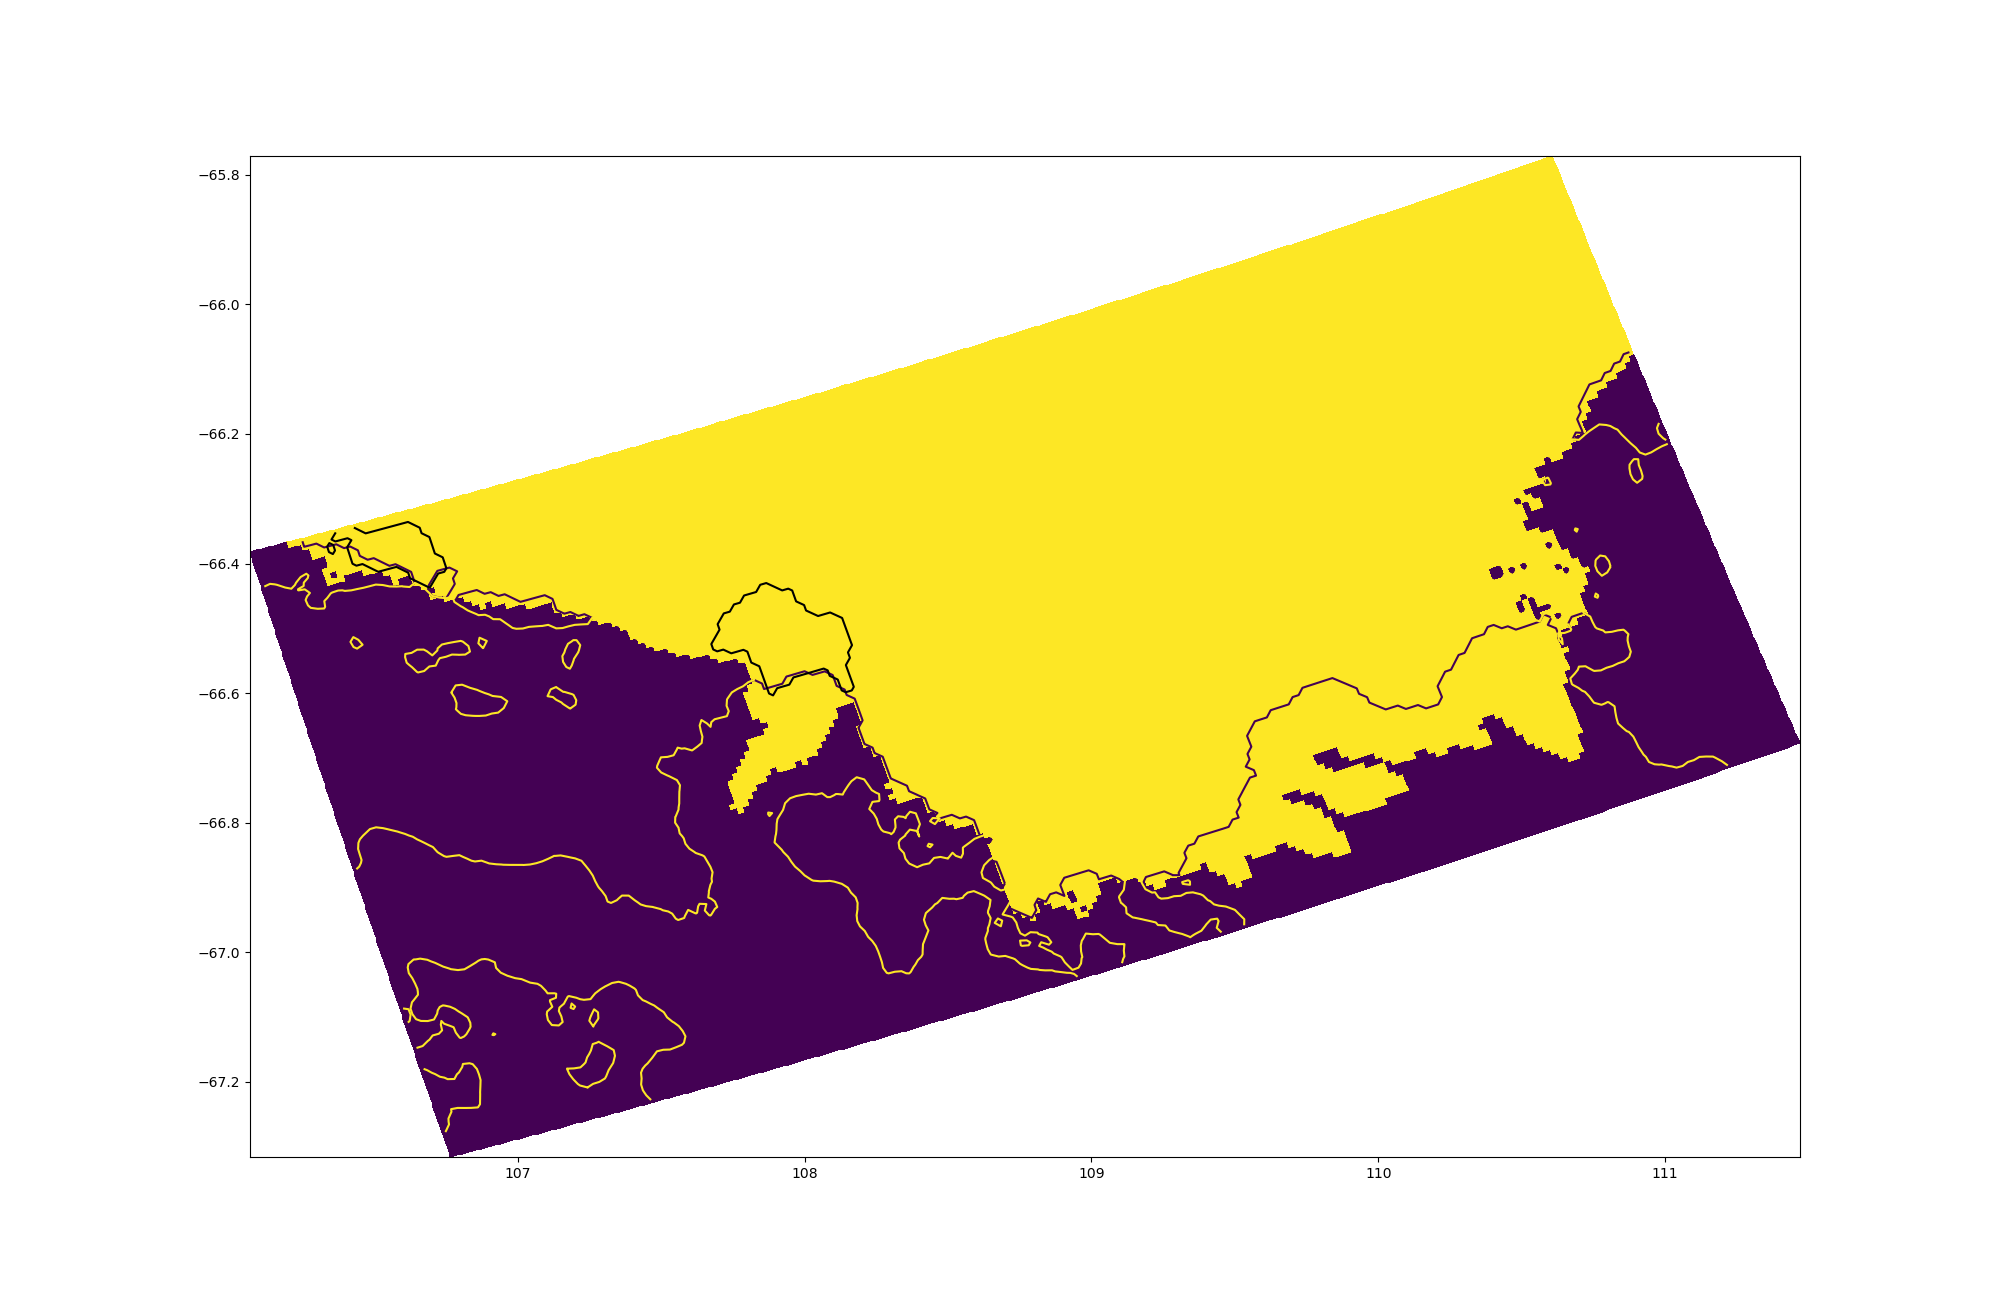

In [66]:

fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,mmm)
plt.contour(lon_rho,lat_rho,zzz,levels=np.array((-1,0)))

plt.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')
# plt.contour(lon_rho,lat_rho,mask_icebergs,colors='r')

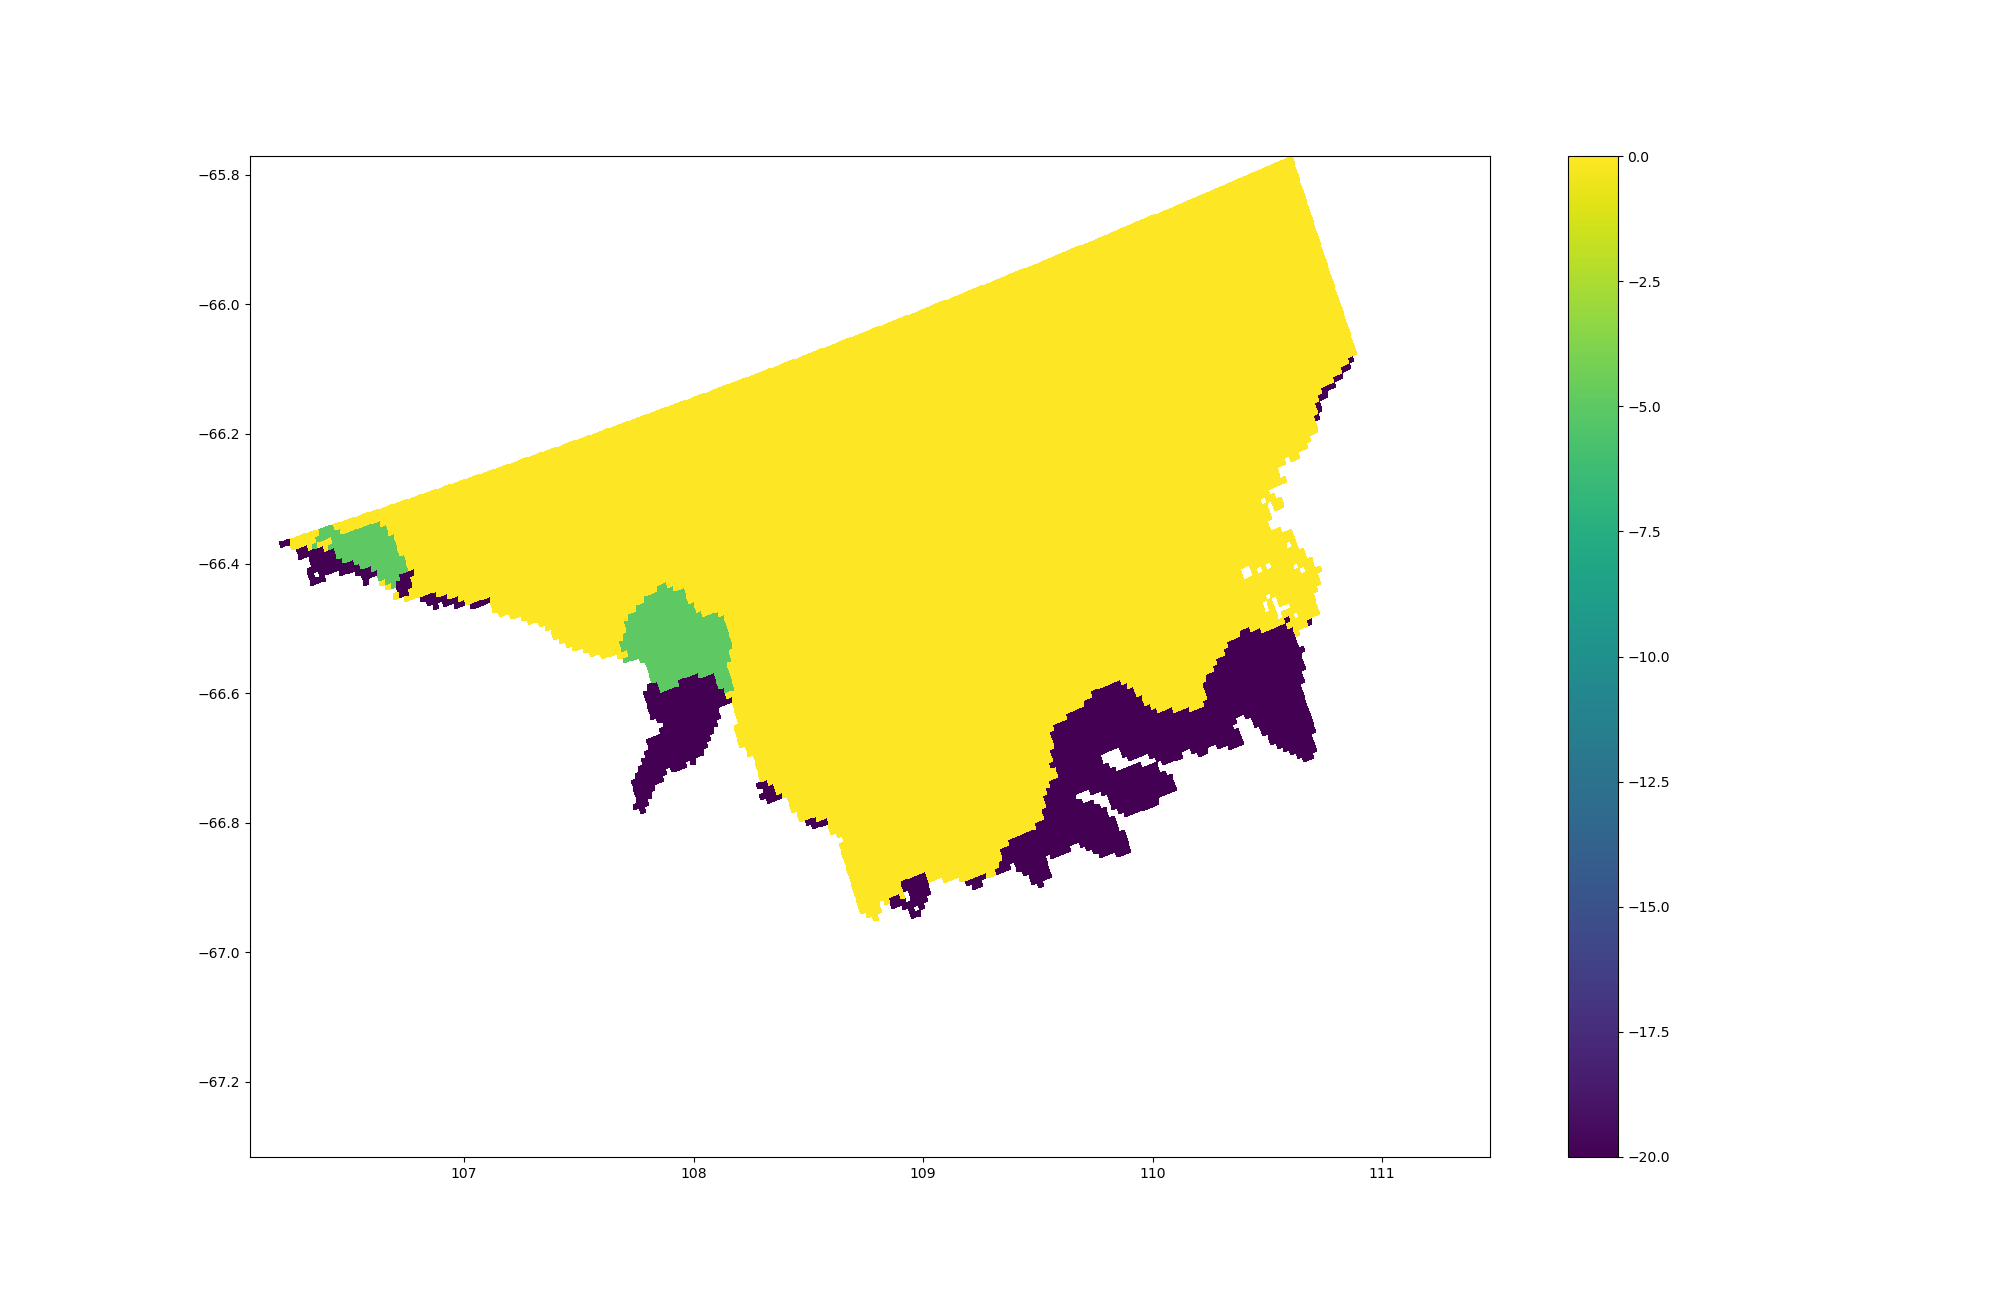

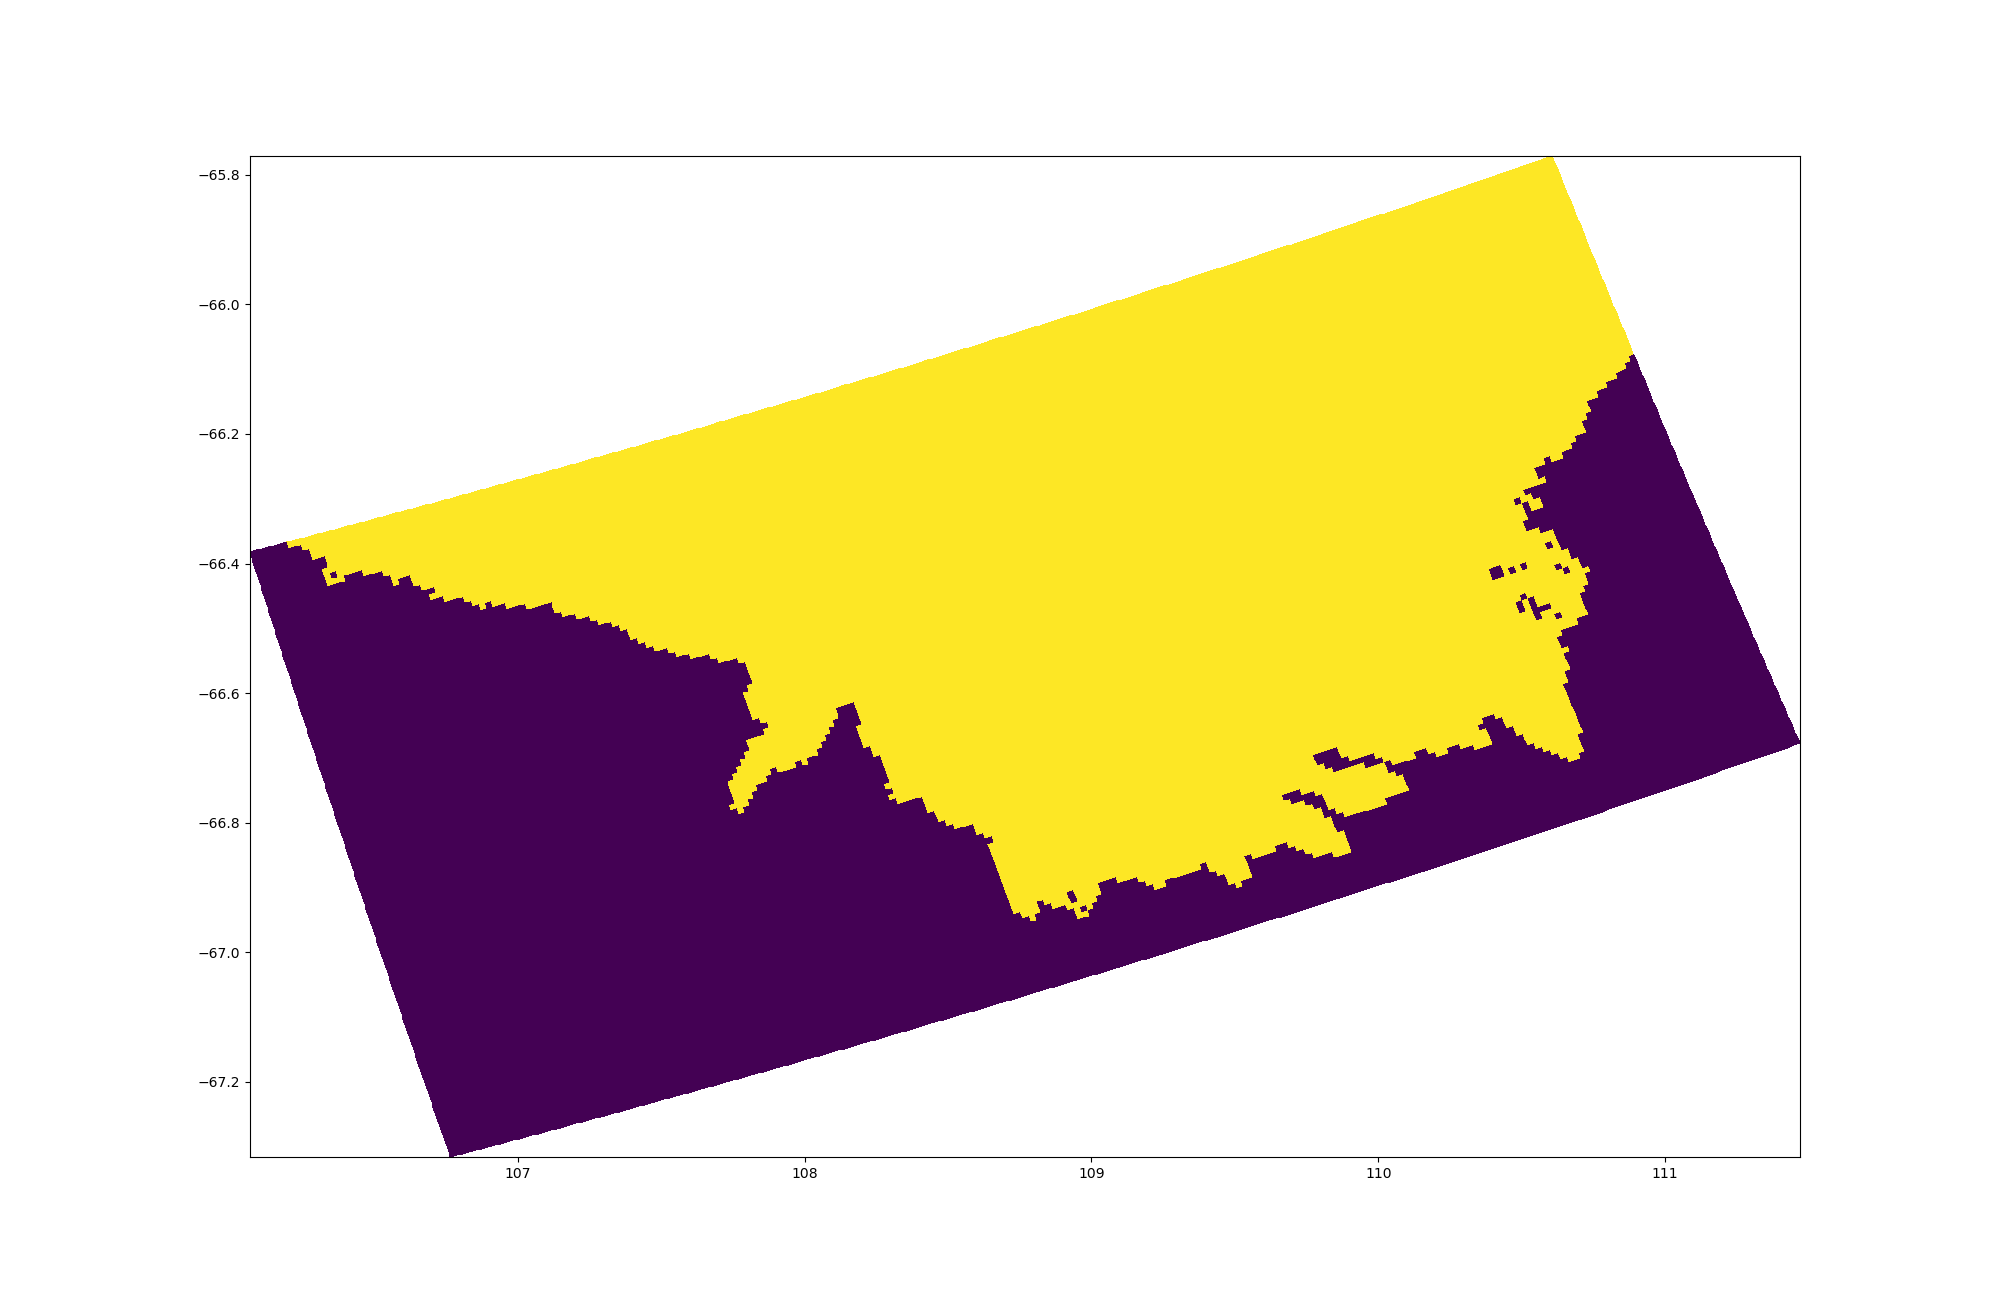

In [67]:
# for fast ice alter the zice.
fastice_draft = -5 #m below surface, negative downwards
zzz_test = zzz.copy()
mmm_test = mmm.copy()
zzz_test[(fi_mean_annual_i==1) & (zzz==0) & (mmm==1)] = fastice_draft

# also add any missing fast ice fill
zzz_test[(mask_fasticefill==1) & (zzz==0) & (mmm==1)] = fastice_draft


# # for icebergs, assume fully grounded.
# hhh_test = hhh.copy()
# zzz_test[mask_icebergs==1] = min_depth-hhh_test[mask_icebergs] # set ice to be min depth above bathy,
# mmm_test[mask_icebergs==1] = 0                                  # and remove from water, i.e. grounded.



fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,zzz_test*mmmNaN,vmin=-20,vmax=0)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,mmm_test)
plt.show()

In [68]:
# update with new fastice and iceberg geometry

zzz = zzz_test.copy()
mmm = mmm_test.copy()
# hhh = hhh_test.copy()

  
Minimum r-value =  0.0
Maximum r-value =  0.39843641615210545
Mean    r-value =  0.017696626539818346
Median  r-value =  0.0060108249201510176
  
Minimum r-value =  0.0
Maximum r-value =  58.761145955688434
Mean    r-value =  1.2763915814106899
Median  r-value =  0.14809512265636704


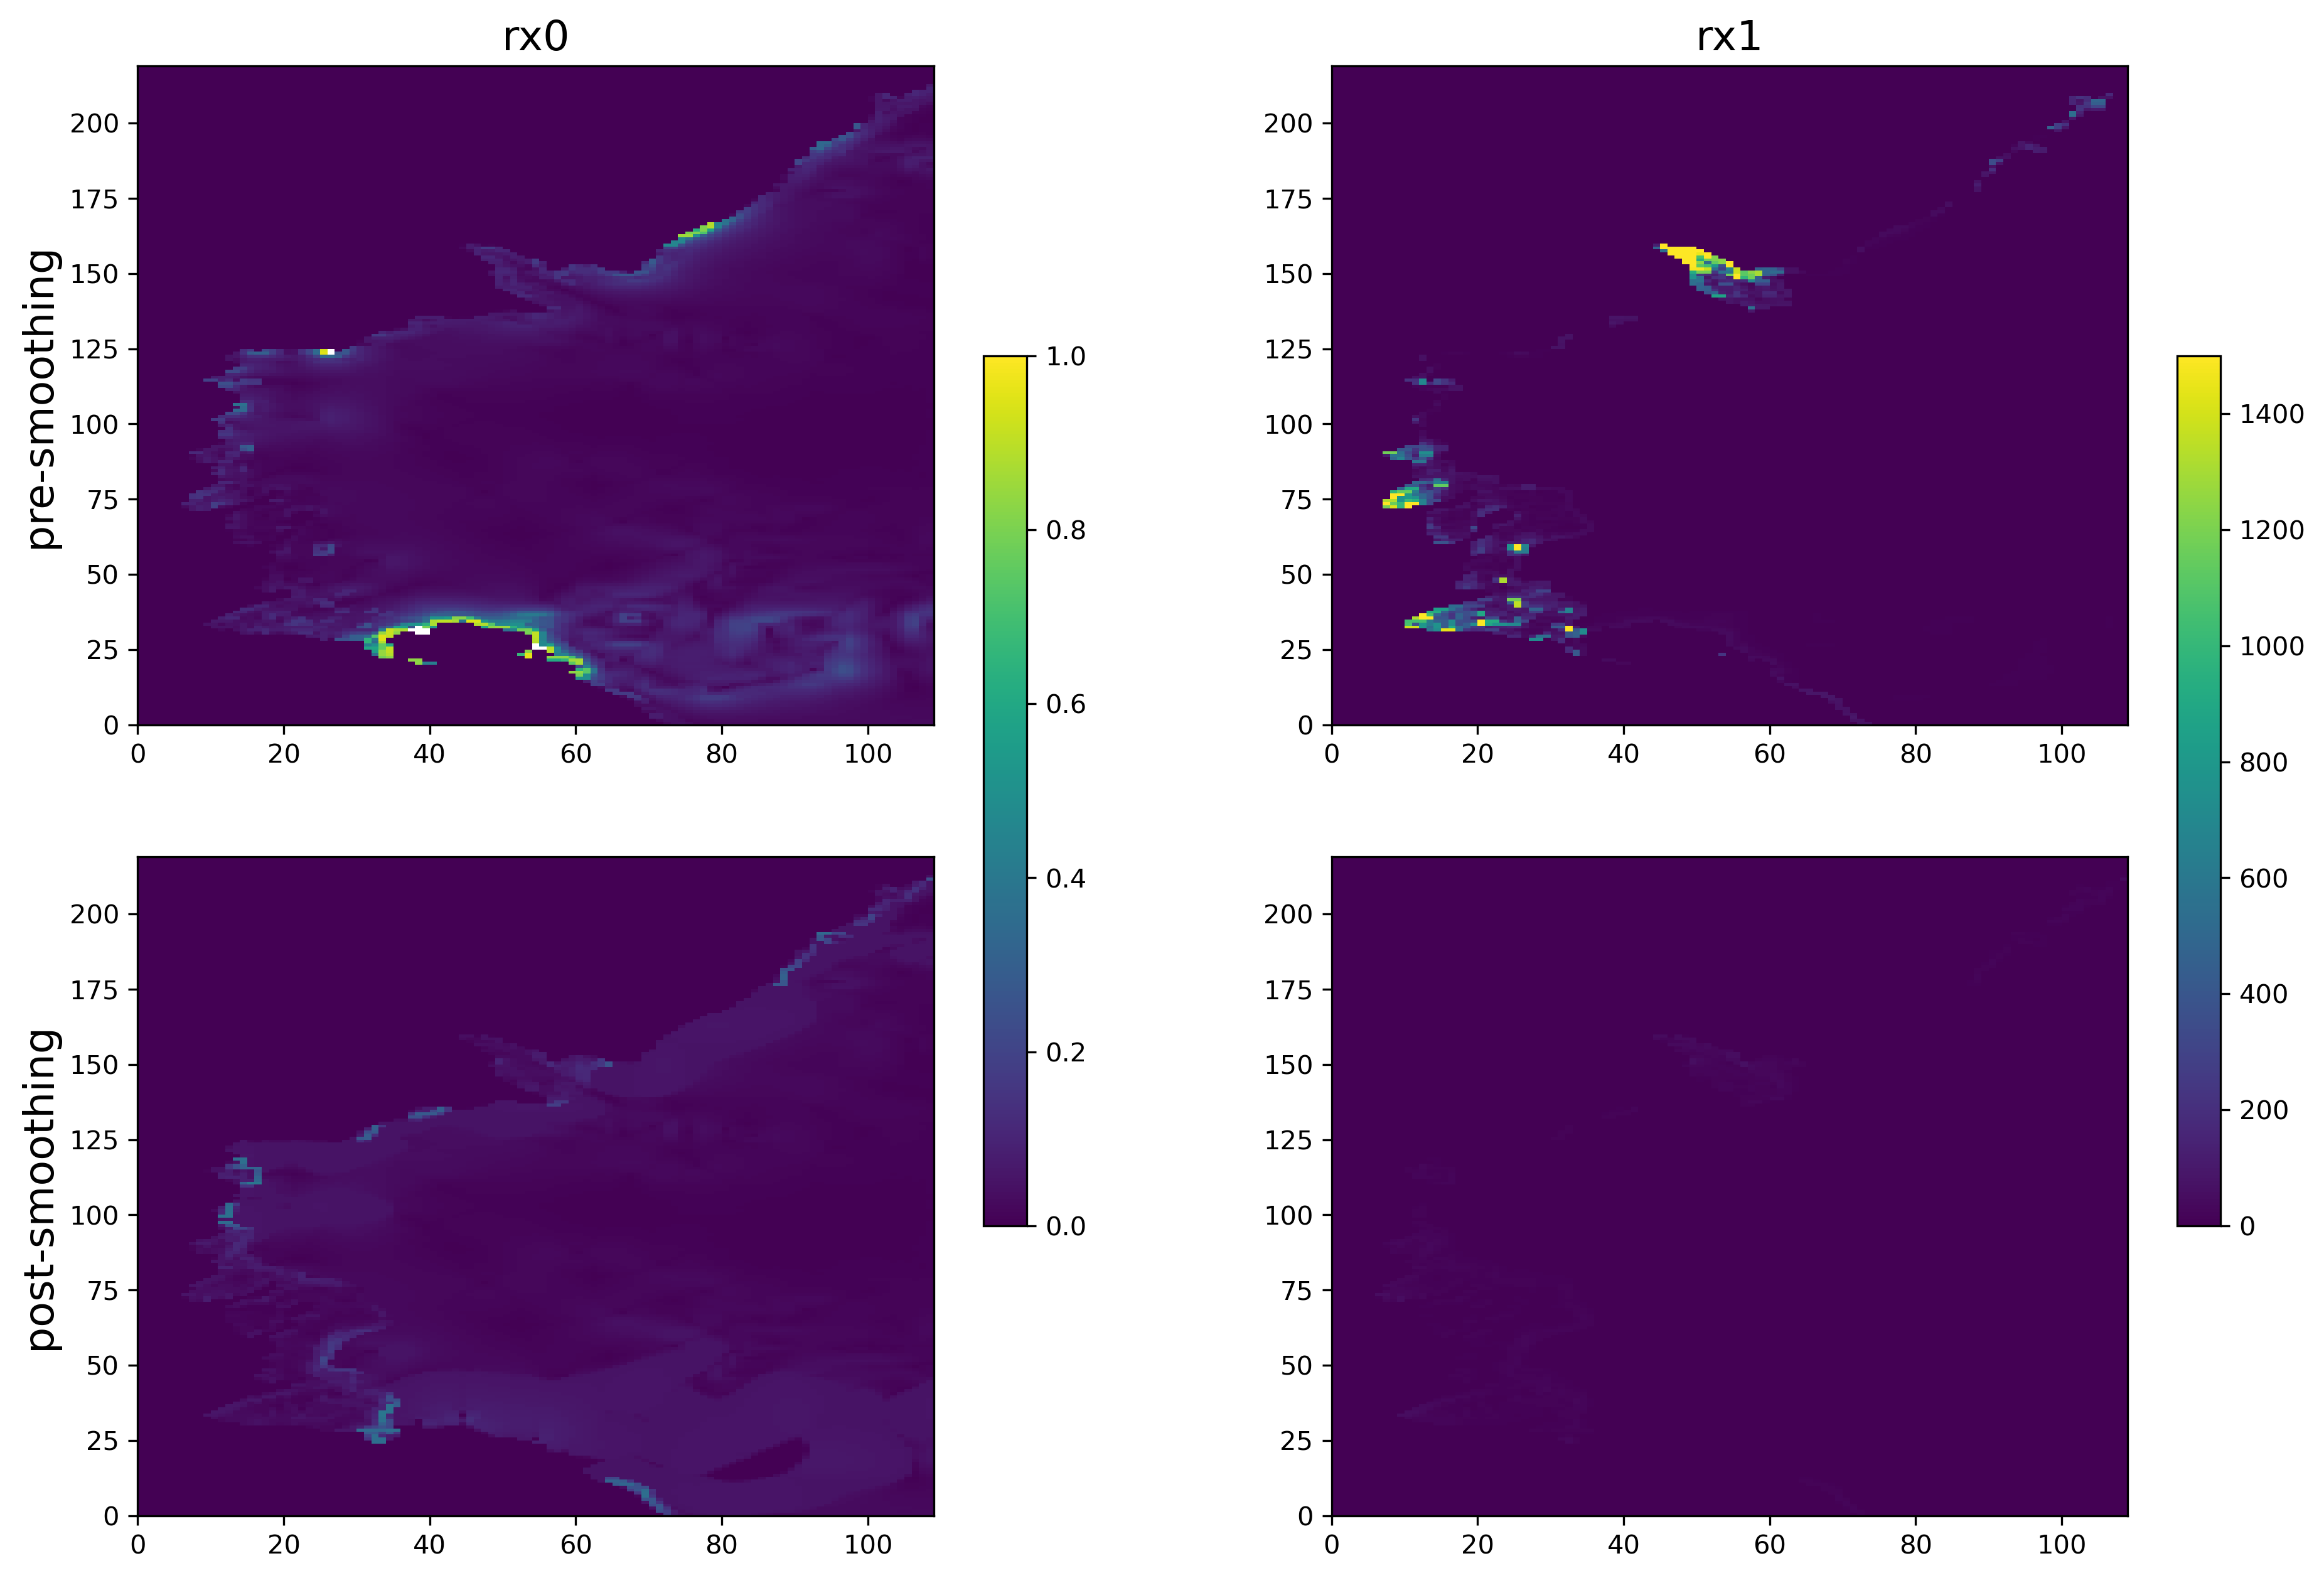

In [69]:
%matplotlib inline


z_rho_postManualEdits,z_w_postManualEdits,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_postManualEdits=GridStiffness.rx0(hhh,mmm)
grd_rx1_postManualEdits=GridStiffness.rx1(z_w_postManualEdits,mmm)


plt.close('all')
fig,axs = plt.subplots(2,2,figsize=[15,10],dpi=300)

ax = axs[0,0]
ax.pcolormesh(grd_rx0_pre,vmax=1)
ax.set_title('rx0',fontsize=16)
ax.set_ylabel('pre-smoothing',fontsize=16)
ax = axs[0,1]
grd_rx1_pre[np.isnan(grd_rx1_pre)]=0
ax.pcolormesh(grd_rx1_pre,vmax=1500)
ax.set_title('rx1',fontsize=16)
ax = axs[1,0]
im=ax.pcolormesh(grd_rx0_postManualEdits,vmax=1)
plt.colorbar(im,ax=axs[:,0],shrink=0.6)
ax.set_ylabel('post-smoothing',fontsize=16)
ax = axs[1,1]
im=ax.pcolormesh(grd_rx1_postManualEdits,vmax=1500)
plt.colorbar(im,ax=axs[:,1],shrink=0.6)

plt.savefig('../out/pre_post_rxVals.png')

In [70]:
# calculate final rx0 and rx1 values, check that you're happy before overwriting these
z_rho_final,z_w_final,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_final=GridStiffness.rx0(hhh,mmm)

grd_rx1_final=GridStiffness.rx1(z_w_final,mmm)

maskNaN = mmm.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',zzz.min(),'/',zzz.max())
print('min/max h is',hhh.min(),'/',hhh.max())
print('min/max wct is',(hhh+zzz).min(),'/',(hhh+zzz).max())
print('ocean cells')
print('min/max zice is',np.nanmin(zzz*maskNaN),'/',np.nanmax(zzz*maskNaN))
print('min/max h is',np.nanmin(hhh*maskNaN),'/',np.nanmax(hhh*maskNaN))
print('min/max wct is',np.nanmin((hhh+zzz)*maskNaN),'/',np.nanmax((hhh+zzz)*maskNaN))


  
Minimum r-value =  0.0
Maximum r-value =  0.39843641615210545
Mean    r-value =  0.017696626539818346
Median  r-value =  0.0060108249201510176
  
Minimum r-value =  0.0
Maximum r-value =  58.761145955688434
Mean    r-value =  1.2763915814106899
Median  r-value =  0.14809512265636704
whole domain
min/max zice is -1285.2479 / 49.7
min/max h is 0.30000001192092896 / 1635.2479248046875
min/max wct is 50.0 / 1293.03466796875
ocean cells
min/max zice is -1285.2479248046875 / -0.0
min/max h is 50.0 / 1635.2479248046875
min/max wct is 50.0 / 1293.03466796875


No such comm: 4d3364f0dd0b47cebc25ee5592776551


  
Minimum r-value =  0.0
Maximum r-value =  0.39843641615210545
Mean    r-value =  0.017696626539818346
Median  r-value =  0.0060108249201510176
  
Minimum r-value =  0.0
Maximum r-value =  58.761145955688434
Mean    r-value =  1.2763915814106899
Median  r-value =  0.14809512265636704
whole domain
min/max zice is -1285.2479 / 49.7
min/max h is 0.30000001192092896 / 1635.2479248046875
min/max wct is 50.0 / 1293.03466796875
ocean cells
min/max zice is -1285.2479248046875 / -0.0
min/max h is 50.0 / 1635.2479248046875
min/max wct is 50.0 / 1293.03466796875


In [71]:
# Make final versions
hhh_final = hhh.copy()
zzz_final = zzz.copy()
mmm_final = mmm.copy()

# now re-check that min_depth is obeyed for all ocean points
ii = ((hhh_final + zzz_final) < min_depth) & (mmm == 1)
hhh_final[ii] = -zzz_final[ii] + min_depth

# do the same for all non-ocean points
ii = ((hhh_final + zzz_final) < min_depth) & (mmm == 0)
zzz_final[ii] = min_depth-hhh_final[ii] # for those locations, the depth needs to be min_depth above the bathy

# remove any zice that is >0.
zzz_final_backup = zzz_final.copy()

anyPosZice=np.any(zzz_final>0)

if anyPosZice:
    new_ice = zzz_final.copy()
    new_ice[(zzz_final>0)]=0
    zzz_final=new_ice.copy()

In [72]:
maskNaN = mmm.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',zzz_final.min(),'/',zzz_final.max())
print('min/max h is',hhh_final.min(),'/',hhh_final.max())
print('min/max wct is',(hhh_final+zzz_final).min(),'/',(hhh_final+zzz_final).max())
print('ocean cells')
print('min/max zice is',np.nanmin(zzz_final*maskNaN),'/',np.nanmax(zzz_final*maskNaN))
print('min/max h is',np.nanmin(hhh_final*maskNaN),'/',np.nanmax(hhh_final*maskNaN))
print('min/max wct is',np.nanmin((hhh_final+zzz_final)*maskNaN),'/',np.nanmax((hhh_final+zzz_final)*maskNaN))

whole domain
min/max zice is -1285.2479 / 0.0
min/max h is 0.30000001192092896 / 1635.2479248046875
min/max wct is 0.30000001192092896 / 1293.03466796875
ocean cells
min/max zice is -1285.2479248046875 / -0.0
min/max h is 50.0 / 1635.2479248046875
min/max wct is 50.0 / 1293.03466796875


In [73]:
# if this is set as 'True', then overwrite the bed, ice and mask with updated values.

handAdjustments=True
if handAdjustments:
    print('updating bathy, zice and mask')
    roms_tmp['bed_backup'] = roms_tmp['bed'].copy()
    roms_tmp['ice_backup'] = roms_tmp['ice'].copy()
    roms_tmp['mask_backup'] = roms_tmp['mask'].copy()
    roms_tmp['bed']=hhh_final.copy()
    roms_tmp['ice']=zzz_final.copy()
    roms_tmp['mask']=mmm_final.copy()
    
    bed = hhh_final.copy()
    ice = zzz_final.copy()
    mask = mmm_final.copy()


updating bathy, zice and mask


In [74]:
# do checks

maskNaN = mask.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(bed+ice).min(),'/',(bed+ice).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin((bed+ice)*maskNaN),'/',np.nanmax((bed+ice)*maskNaN))

whole domain
min/max zice is -1285.2479 / 0.0
min/max h is 0.30000001192092896 / 1635.2479248046875
min/max wct is 0.30000001192092896 / 1293.03466796875
ocean cells
min/max zice is -1285.2479248046875 / -0.0
min/max h is 50.0 / 1635.2479248046875
min/max wct is 50.0 / 1293.03466796875


In [75]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL with ROMS requiring a 0.85 tolerance: ', 0.85*np.nanmin(CFL))
print('max slow DT in s following CFL: ', 0.85*np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',0.85*np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/(0.85*np.nanmin(CFL))).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))



max fast DT in s following CFL with ROMS requiring a 0.85 tolerance:  7.3890887737274165
max slow DT in s following CFL:  104.02567114497978
Set ROMS timestep settings of at least: 
 DT < 104.02567114497978 s 
 NDTFAST > 17.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  2.2482245361061812
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.22482245361061812


In [76]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray('"T"',name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array(['"F"', '"T"'], dtype=str),
 'long_name': 'grid type logical switch'})

xl = np.maximum(dx[0,:].sum(), dx[-1,:].sum())
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = np.maximum(dy[:,0].sum(), dy[:,-1].sum())
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(bed,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})
# hraw_da = xr.DataArray(bed_raw.astype(float),name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working unmasked bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(ice,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})
# zice_raw_da = xr.DataArray(ice_raw.astype(float),name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'raw unmasked model ice draft at RHO-points', 'units': 'meter'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})

x_rho_da = xr.DataArray(x_rho,name='x_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'x-location of RHO-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_rho_da = xr.DataArray(y_rho,name='y_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'y-location of RHO-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_psi_da = xr.DataArray(x_psi,name='x_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'x-location of psi-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_psi_da = xr.DataArray(y_psi,name='y_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'y-location of psi-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_u_da = xr.DataArray(x_u,name='x_u',dims=['eta_u','xi_u'],attrs={'long_name': 'x-location of u-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_u_da = xr.DataArray(y_u,name='y_u',dims=['eta_u','xi_u'],attrs={'long_name': 'y-location of u-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_v_da = xr.DataArray(x_v,name='x_v',dims=['eta_v','xi_v'],attrs={'long_name': 'x-location of v-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_v_da = xr.DataArray(y_v,name='y_v',dims=['eta_v','xi_v'],attrs={'long_name': 'y-location of v-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})


mask_u,mask_v,mask_psi = uvp_masks(mask)

mask_rho_da = xr.DataArray(mask,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pm_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
              #   'hraw':hraw_da,
                'zice':zice_da,
              #   'zice_raw':zice_raw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'x_rho':x_rho_da,
                'y_rho':y_rho_da,
                'x_psi':x_psi_da,
                'y_psi':y_psi_da,
                'x_u':x_u_da,
                'y_u':y_u_da,
                'x_v':x_v_da,
                'y_v':y_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

In [77]:
print('saving to',out_path)
grd.to_netcdf(out_path,unlimited_dims='bath')

saving to /home/woden/Documents/vanderford-setup/data/proc/vand_1km_v1_grd.nc


Text(0, 0.5, 'ice draft [mbsl]')

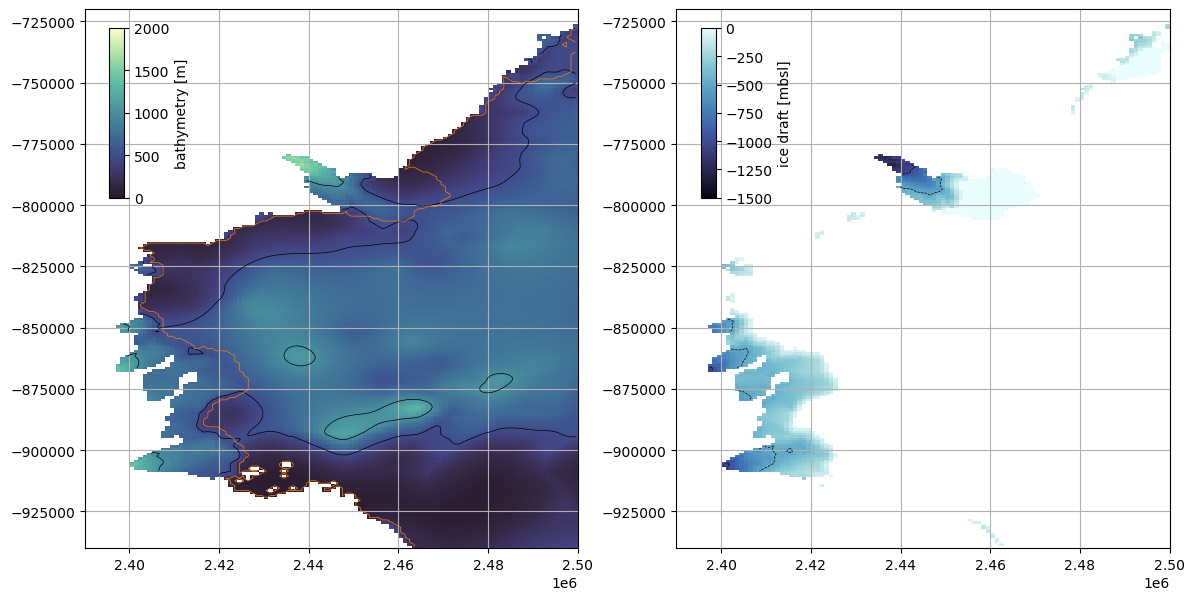

In [78]:
# plot of bathy and draft subset

nanMask = grd.mask_rho.where(grd.mask_rho!=0,np.NaN)
nanMaskZice = grd.mask_rho.where((grd.mask_rho!=0)&(grd.zice<0),np.NaN)

plt.close('all')
fig,axs=plt.subplots(ncols=2,figsize=(14,7))
im=axs[0].pcolormesh(grd.x_rho,grd.y_rho,(grd.h*nanMask),vmin=000,vmax=2000,cmap='cmo.deep_r')
axs[0].contour(grd.x_rho,grd.y_rho,(grd.h*nanMask),levels=[0,500,1000,2000,2500],colors='k',linewidths=0.5)
axs[0].contour(grd.x_rho,grd.y_rho,(grd.zice!=0 * nanMask),levels=[0,1],colors='C1',linewidths=0.5)

axs[0].grid()
# axs[0].set_aspect('equal','box')
# colorbar
cax = inset_axes(axs[0],
                 width="3%",  # width = 10% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.65, 1, .7),
                 bbox_transform=axs[0].transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('bathymetry [m]')

im=axs[1].pcolormesh(grd.x_rho,grd.y_rho,grd.zice*nanMask*nanMaskZice,vmin=-1500,vmax=000,cmap='cmo.ice')
axs[1].contour(grd.x_rho,grd.y_rho,grd.zice*nanMask*nanMaskZice,levels=[-1500,-1000,-500,0],colors='k',linewidths=0.5)

axs[1].grid()

cax = inset_axes(axs[1],
                 width="3%",  # width = 10% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.65, 1, .7),
                 bbox_transform=axs[1].transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('ice draft [mbsl]')
